# Exploration
--------------
In diesem Notebook wird eine erste Analyse bezüglich der vorliegenden Daten gemacht.
Dabei ist es das Ziel, für unsere Fragestellung relevante Daten zu extrapolieren, und festzustellen,
welche Spalten einen Einfluss auf vergangene Wahlergebnisse hatten. Ein weiteres zentrales Thema dieser ersten Untersuchung
ist es, aus den gewonnenen Erkenntnissen Hypothesen zu formulieren, welche wir nach einer weiteren aber genauer verlaufenden
Analyse zu falsifizieren oder verifizieren versuchen.

## Import der Libraries
Folgende Libraries werden genutzt:

In [29]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


## 1. Daten einlesen und erste Analyse

In [30]:
# CSV-Datei einlesen – wir verwenden Semikolon als Trennzeichen und UTF-8 Kodierung
df = pd.read_csv('Data/dataset.csv', delimiter=";", encoding="utf-8")

# Erste Zeilen des Datensatzes anzeigen, um einen Überblick zu bekommen
print("Erste 5 Zeilen:")
print(df.head())
# Strukturinformationen des DataFrames ausgeben (Spaltentypen, fehlende Werte, etc.)
print("\nInfo zum DataFrame:")
df.info()
# Deskriptive Statistik berechnen (Mittelwert, Standardabweichung, Min/Max, etc.)
print("\nDeskriptive Statistik:")
print(df.describe())

Erste 5 Zeilen:
   anr       datum                                       titel_kurz_d  \
0  1.0  12.09.1848  Bundesverfassung der schweizerischen Eidgenoss...   
1  2.0  14.01.1866                                   Mass und Gewicht   
2  3.0  14.01.1866  Gleichstellung der Juden und Naturalisierten m...   
3  4.0  14.01.1866  Stimmrecht der Niedergelassenen in Gemeindeang...   
4  5.0  14.01.1866  Besteuerung und zivilrechtliche Verhältnisse d...   

                                        titel_kurz_f  \
0   Constitution fédérale de la Confédération suisse   
1                                   Poids et mesures   
2                                  Egalité des Juifs   
3  Droit de vote des Suisses établis, en matière ...   
4      Impôts et rapports civils des Suisses établis   

                                        titel_kurz_e  \
0    Federal Constitution of the Swiss Confederation   
1                               Weights and measures   
2  Equal rights for Jews and naturalised

## 2. Filtern und Bereinigen der Daten

In [31]:
# Selektiere nur die Spalten, die "-annahme" enthalten (Abstimmungsergebnisse pro Kanton)
df_filtered = df[[col for col in df.columns if '-annahme' in col]]

# Problematische Werte ersetzen:
# - '.' und 'z' werden als fehlende Werte (NaN) interpretiert
# - '1' bedeutet Annahme der Vorlage
# - '0' bedeutet Ablehnung der Vorlage
df_filtered = df_filtered.replace({'.': np.nan, 'z': np.nan, '1': 1, '0': 0})
# Alle Werte in numerisches Format umwandeln; nicht-konvertierbare werden zu NaN
df_filtered = df_filtered.apply(pd.to_numeric, errors='coerce')

## 3. Visualisierungen: Gestapeltes Balkendiagramm

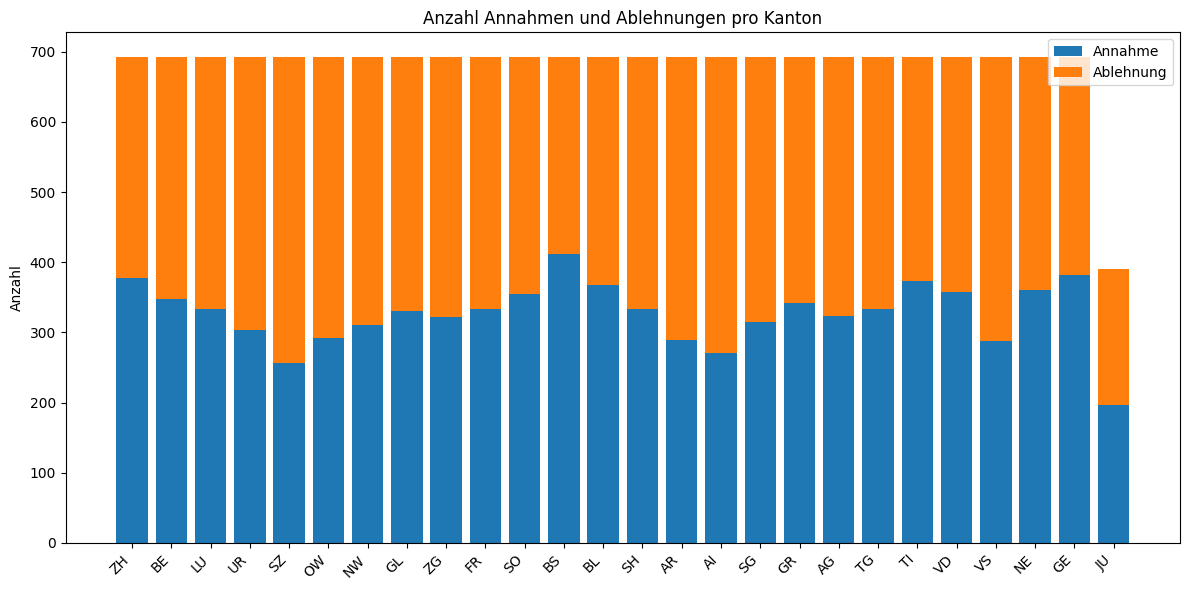

In [32]:
# Berechnung der Anzahl Annahmen und Ablehnungen pro Kanton
acceptance_counts = (df_filtered == 1).sum()  # Summe aller Annahmen
rejected_counts = (df_filtered == 0).sum()    # Summe aller Ablehnungen

# Formatiere die Kantonsnamen für die Visualisierung
# Ersetze "-annahme" und wandle in Großbuchstaben um (z.B. "zh-annahme" wird zu "ZH")
canton_names = acceptance_counts.index.str.replace("-annahme", "", regex=False).str.upper()

# Erstelle ein gestapeltes Balkendiagramm für Annahmen und Ablehnungen pro Kanton
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(canton_names, acceptance_counts.values, label='Annahme', color='tab:blue')
ax.bar(canton_names, rejected_counts.values, bottom=acceptance_counts.values, label='Ablehnung', color='tab:orange')

plt.xticks(rotation=45, ha='right')  # Drehe Beschriftungen für bessere Lesbarkeit
plt.title('Anzahl Annahmen und Ablehnungen pro Kanton')
plt.ylabel('Anzahl')
plt.legend()
plt.tight_layout()
plt.show()

## 4. Erweiterte Analyse: Annahmequote pro Kanton

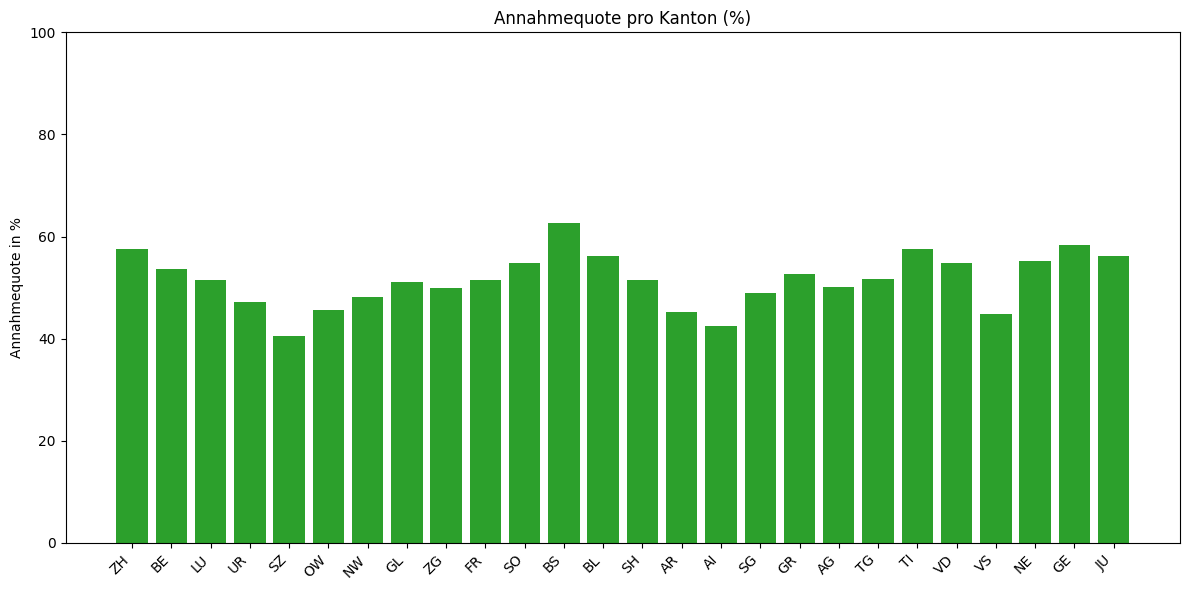

In [33]:
## 4. Erweiterte Analyse: Annahmequote pro Kanton
# Berechne die durchschnittliche Annahmequote pro Kanton
# Da die Werte 0 und 1 sind, gibt der Mittelwert direkt den Anteil der Annahmen an
acceptance_rate = df_filtered.mean()

# Visualisierung der Annahmequote als Prozentsatz in einem Balkendiagramm
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(canton_names, acceptance_rate.values * 100, color='tab:green')  # Umrechnung in Prozent
plt.xticks(rotation=45, ha='right')
plt.title('Annahmequote pro Kanton (%)')
plt.ylabel('Annahmequote in %')
plt.ylim(0, 100)  # Y-Achse von 0 bis 100%
plt.tight_layout()
plt.show()

## 5. Erweiterte Analyse: Korrelationsmatrix zwischen Kantonen


### Korrelationsmatrix der Abstimmungsergebnisse pro Kanton

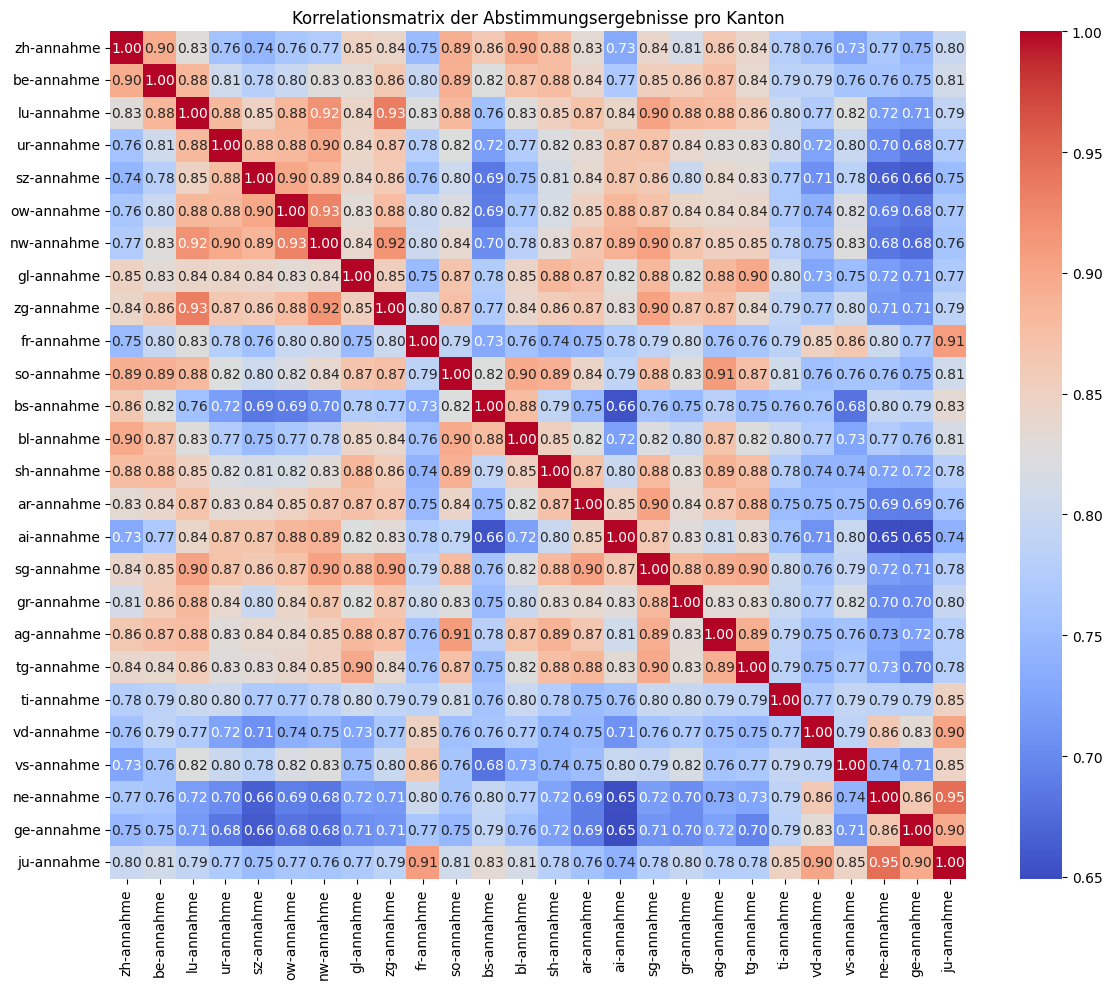

In [34]:
# Berechne Korrelationen zwischen Kantonen, um zu sehen, ob sie ähnlich abstimmen
# Positive Korrelation bedeutet, dass Kantone tendenziell ähnlich abstimmen
corr_matrix = df_filtered.corr()

# Visualisierung der Korrelationsmatrix als Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korrelationsmatrix der Abstimmungsergebnisse pro Kanton")
plt.tight_layout()
plt.show()

### Korrelationsmatrix der Abstimmungsergebnisse pro Kanton vor 1971

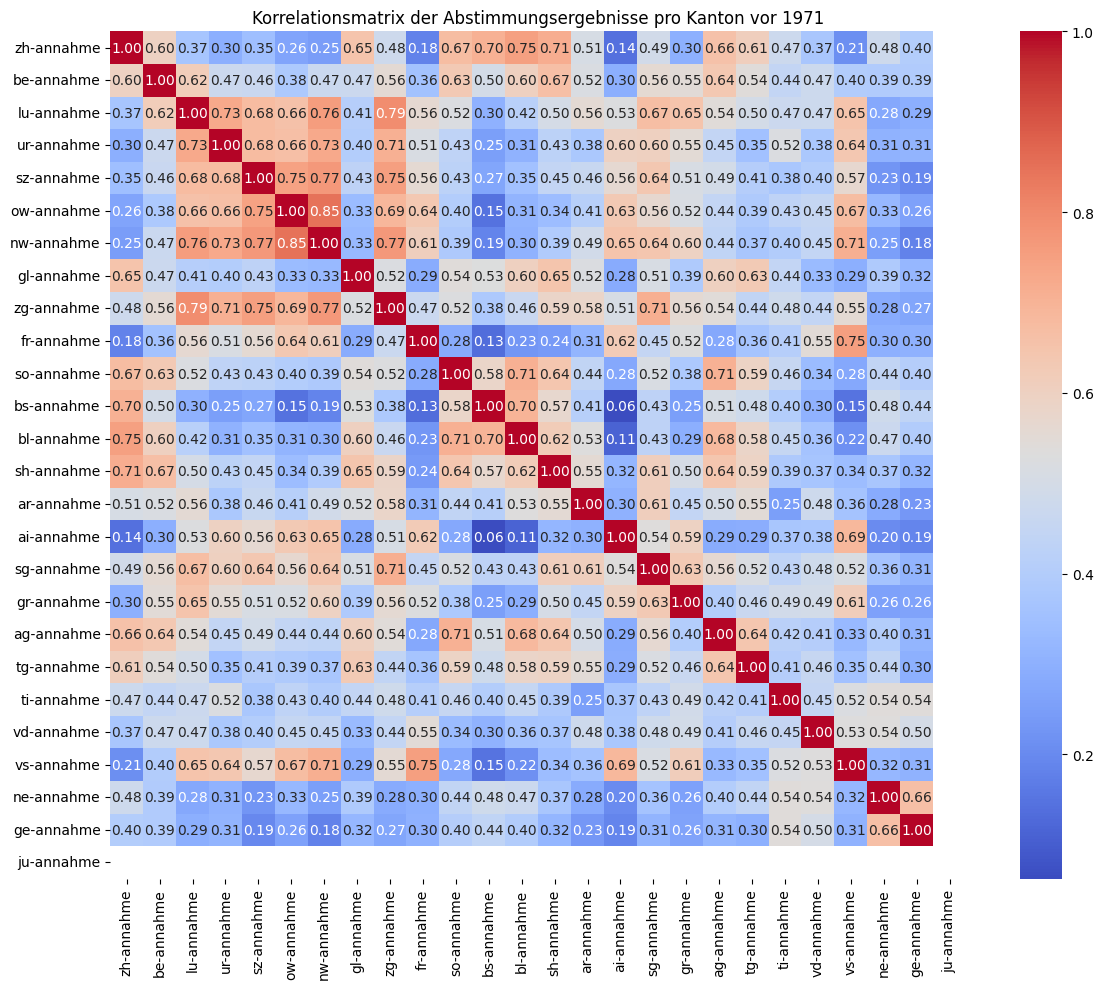

In [35]:
# Definiere das Datum für die Einführung des Frauenstimmrechts in der Schweiz
init_date = datetime(1971, 2, 7, 0, 0)

# Teile die Daten in Abstimmungen vor und nach der Einführung des Frauenstimmrechts
# Abstimmungen vor 1971 (ohne Frauenstimmrecht)
df_without_women = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') < init_date]
df_without_women.reset_index(drop=True, inplace=True)

# Berechne und visualisiere die Korrelationsmatrix für Abstimmungen vor 1971
corr_matrix = df_without_women.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korrelationsmatrix der Abstimmungsergebnisse pro Kanton vor 1971")
plt.tight_layout()
plt.show()

### Korrelationsmatrix der Abstimmungsergebnisse pro Kanton nach 1971

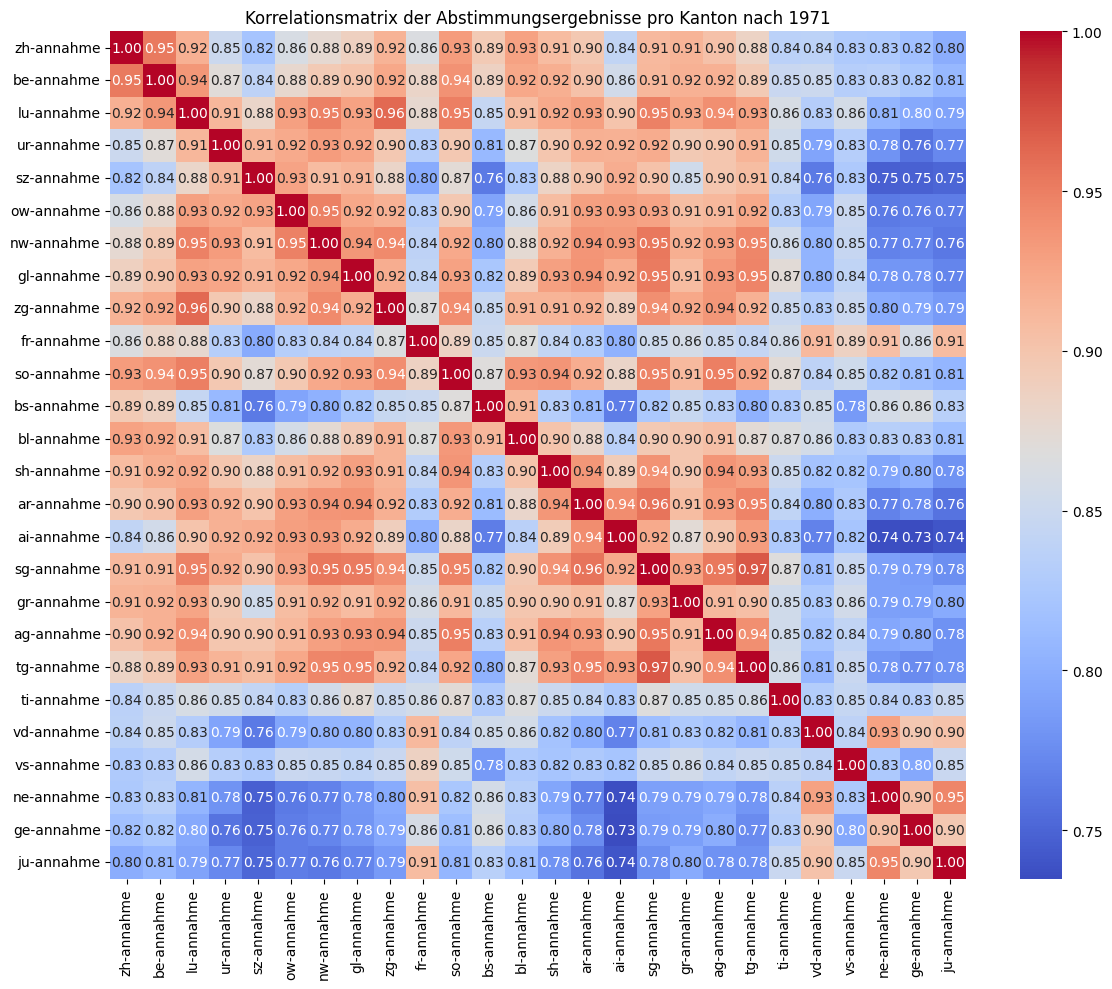

In [36]:
# Abstimmungen nach 1971 (mit Frauenstimmrecht)
df_with_women = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') > init_date]
df_with_women.reset_index(drop=True, inplace=True)

# Berechne und visualisiere die Korrelationsmatrix für Abstimmungen nach 1971
corr_matrix = df_with_women.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korrelationsmatrix der Abstimmungsergebnisse pro Kanton nach 1971")
plt.tight_layout()
plt.show()

C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_before = corr_before.fillna(corr_before.mean().mean())
C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:86: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_after = corr_after.fillna(corr_after.mean().mean())


Error downloading shapefile: File is not a zip file
Creating a simple visualization without the map...


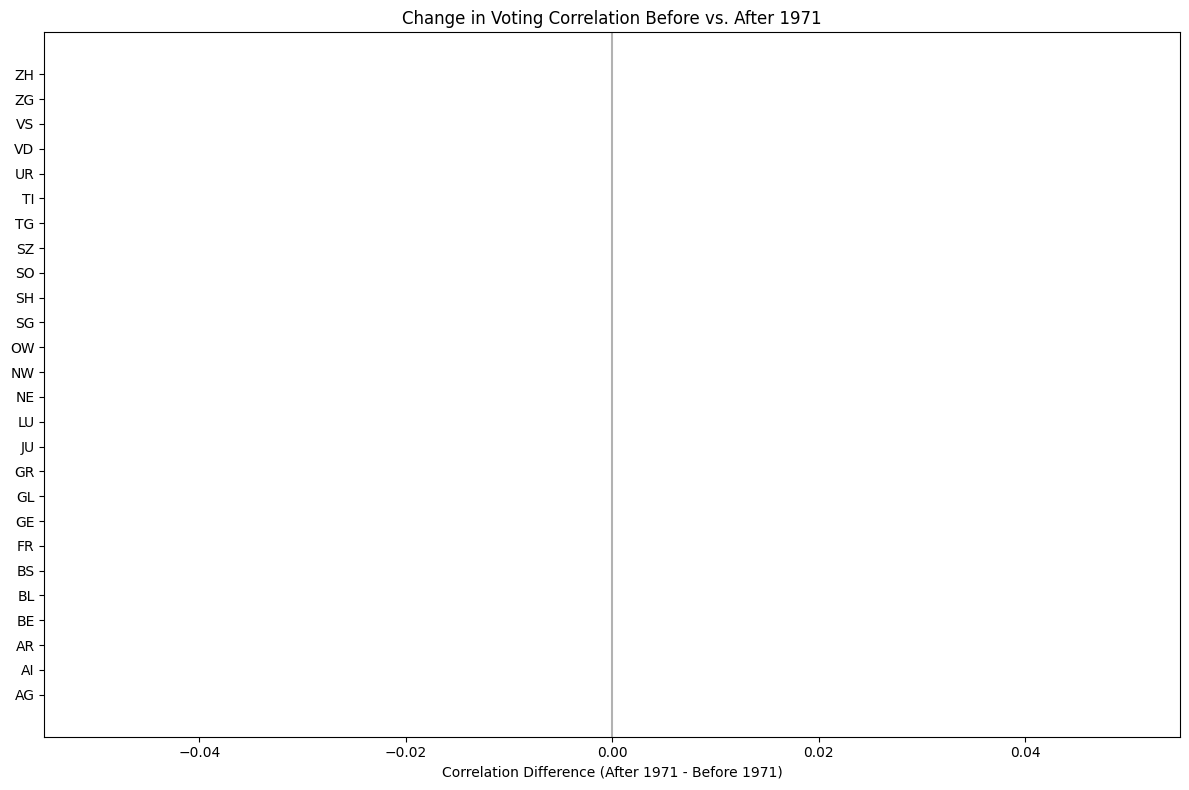

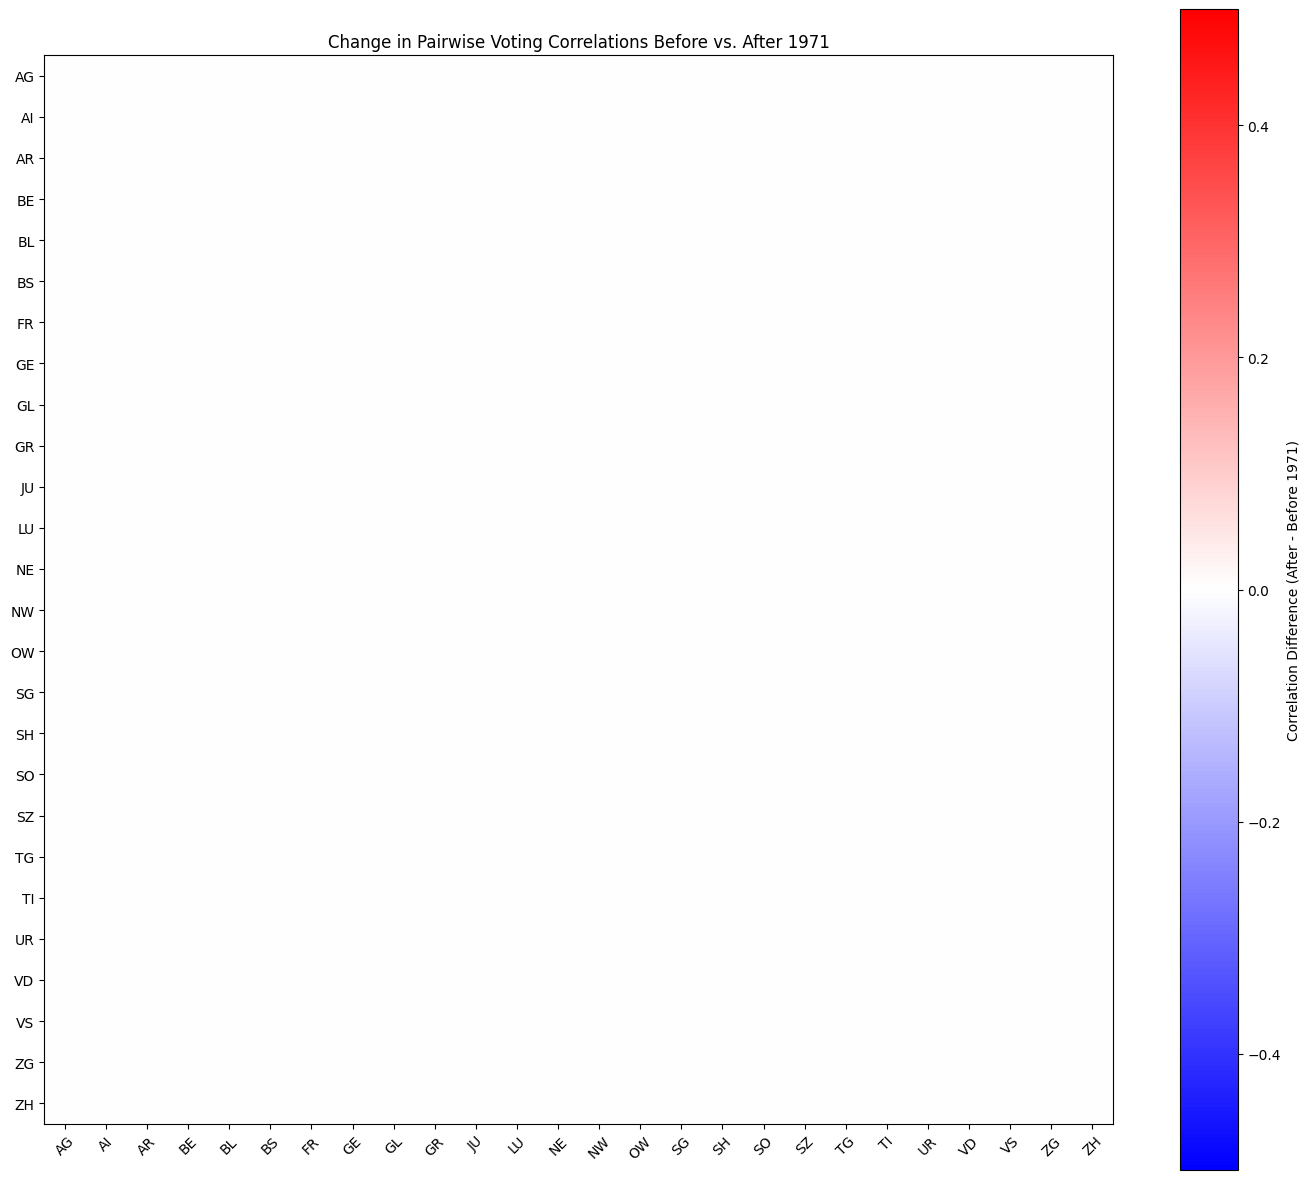

In [40]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import requests
import io
import zipfile
import os

# First, let's prepare the data
# Assuming 'df' is your dataframe with the voting data
# We need to extract the canton-level voting data before and after 1971

# First, let's split the data into before and after 1971
init_date = datetime(1971, 2, 7, 0, 0)

# Teile die Daten in Abstimmungen vor und nach der Einführung des Frauenstimmrechts
# Abstimmungen vor 1971 (ohne Frauenstimmrecht)
df_before_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') < init_date]
df_after_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') >= init_date]

# Create a list of all cantons
canton_codes = ['AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 
                'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 
                'TI', 'UR', 'VD', 'VS', 'ZG', 'ZH']

# Function to create a correlation matrix for a given time period
def create_correlation_matrix(data, canton_codes):
    # Create an empty correlation matrix
    corr_matrix = pd.DataFrame(index=canton_codes, columns=canton_codes)
    
    # For each pair of cantons, calculate the correlation of their voting patterns
    for i, canton1 in enumerate(canton_codes):
        for j, canton2 in enumerate(canton_codes):
            if i > j:  # Only calculate for the lower triangle
                continue
                
            # Get the voting data for both cantons
            canton1_col = f"{canton1.lower()}-japroz"
            canton2_col = f"{canton2.lower()}-japroz"
            
            # Check if both columns exist in the dataframe
            if canton1_col in data.columns and canton2_col in data.columns:
                # Get the voting percentages for both cantons
                votes1 = data[canton1_col].dropna()
                votes2 = data[canton2_col].dropna()
                
                # Find common votes (by index)
                common_indices = votes1.index.intersection(votes2.index)
                
                if len(common_indices) > 5:  # Only calculate if there are enough common votes
                    # Calculate correlation
                    correlation = np.corrcoef(
                        votes1.loc[common_indices], 
                        votes2.loc[common_indices]
                    )[0, 1]
                    
                    # Store in the matrix
                    corr_matrix.loc[canton1, canton2] = correlation
                    corr_matrix.loc[canton2, canton1] = correlation
                else:
                    corr_matrix.loc[canton1, canton2] = np.nan
                    corr_matrix.loc[canton2, canton1] = np.nan
            else:
                corr_matrix.loc[canton1, canton2] = np.nan
                corr_matrix.loc[canton2, canton1] = np.nan
                
    # Fill diagonal with 1s
    for canton in canton_codes:
        corr_matrix.loc[canton, canton] = 1.0
        
    return corr_matrix

# Create correlation matrices for both periods
corr_before = create_correlation_matrix(df_before_1971, canton_codes)
corr_after = create_correlation_matrix(df_after_1971, canton_codes)

# Handle the case of Jura (JU) which was created after 1971
if 'JU' in corr_before.index and corr_before.loc['JU'].isna().all():
    corr_before = corr_before.drop('JU', axis=0).drop('JU', axis=1)

# Fill NaN values with the mean of the respective matrix
corr_before = corr_before.fillna(corr_before.mean().mean())
corr_after = corr_after.fillna(corr_after.mean().mean())

# Calculate the difference in correlation patterns
# For each canton, we'll calculate the average correlation with all other cantons
corr_diff = {}
for canton in corr_before.index:
    if canton in corr_after.index:
        # Calculate average correlation with other cantons (excluding self-correlation)
        avg_corr_before = corr_before.loc[canton].drop(canton).mean()
        avg_corr_after = corr_after.loc[canton].drop(canton).mean()
        corr_diff[canton] = avg_corr_after - avg_corr_before

# Download Swiss cantons shapefile if not already available
shapefile_path = 'data/swiss_cantons'
if not os.path.exists(shapefile_path):
    os.makedirs(shapefile_path, exist_ok=True)
    
    # URL for Swiss cantons shapefile (this is an example URL, you may need to find the correct one)
    url = "https://www.swisstopo.admin.ch/content/swisstopo-internet/en/geodata/landscape/boundaries3d/_jcr_content/contentPar/tabs/items/documents_publicatio/tabPar/downloadlist/downloadItems/1_1547207224391.download/BOUNDARIES_2022-01-01_2056_EN.zip"
    
    try:
        print("Downloading Swiss cantons shapefile...")
        response = requests.get(url)
        if response.status_code == 200:
            z = zipfile.ZipFile(io.BytesIO(response.content))
            z.extractall(shapefile_path)
            print("Download and extraction complete.")
        else:
            print(f"Failed to download shapefile: HTTP {response.status_code}")
            raise Exception("Download failed")
    except Exception as e:
        print(f"Error downloading shapefile: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a mask for the upper triangle
        mask = np.triu(np.ones_like(diff_matrix, dtype=bool))
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()
else:
    try:
        # Try to load the shapefile
        shapefile = os.path.join(shapefile_path, 'swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp')
        swiss_map = gpd.read_file(shapefile)
        
        # Map the canton names to match the shapefile
        # This mapping might need adjustment based on your shapefile
        canton_mapping = {
            'AG': 'Aargau', 'AI': 'Appenzell Innerrhoden', 'AR': 'Appenzell Ausserrhoden',
            'BE': 'Bern', 'BL': 'Basel-Landschaft', 'BS': 'Basel-Stadt', 'FR': 'Fribourg',
            'GE': 'Genève', 'GL': 'Glarus', 'GR': 'Graubünden', 'JU': 'Jura', 'LU': 'Luzern',
            'NE': 'Neuchâtel', 'NW': 'Nidwalden', 'OW': 'Obwalden', 'SG': 'St. Gallen',
            'SH': 'Schaffhausen', 'SO': 'Solothurn', 'SZ': 'Schwyz', 'TG': 'Thurgau',
            'TI': 'Ticino', 'UR': 'Uri', 'VD': 'Vaud', 'VS': 'Valais', 'ZG': 'Zug', 'ZH': 'Zürich'
        }
        
        # Create a new column with the correlation differences
        swiss_map['corr_diff'] = swiss_map['NAME'].map(
            lambda x: corr_diff.get(next((k for k, v in canton_mapping.items() if v == x), None), 0)
        )
        
        # Create a custom colormap: blue for negative, white for zero, red for positive
        colors = ['blue', 'white', 'red']
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', colors, N=256)
        
        # Plot the map
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        
        # Find the maximum absolute value for symmetric color scaling
        vmax = max(abs(min(corr_diff.values())), abs(max(corr_diff.values())))
        
        swiss_map.plot(
            column='corr_diff',
            cmap=cmap,
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            vmin=-vmax,
            vmax=vmax,
            legend=True,
            legend_kwds={'label': 'Correlation Difference (After - Before 1971)'}
        )
        
        # Add canton labels
        for idx, row in swiss_map.iterrows():
            plt.annotate(text=row['NAME'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                        horizontalalignment='center', fontsize=8)
        
        plt.title('Change in Voting Correlation Patterns Before vs. After 1971')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating map: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()

C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_before = corr_before.fillna(corr_before.mean().mean())
C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:86: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_after = corr_after.fillna(corr_after.mean().mean())


Error downloading shapefile: File is not a zip file
Creating a simple visualization without the map...


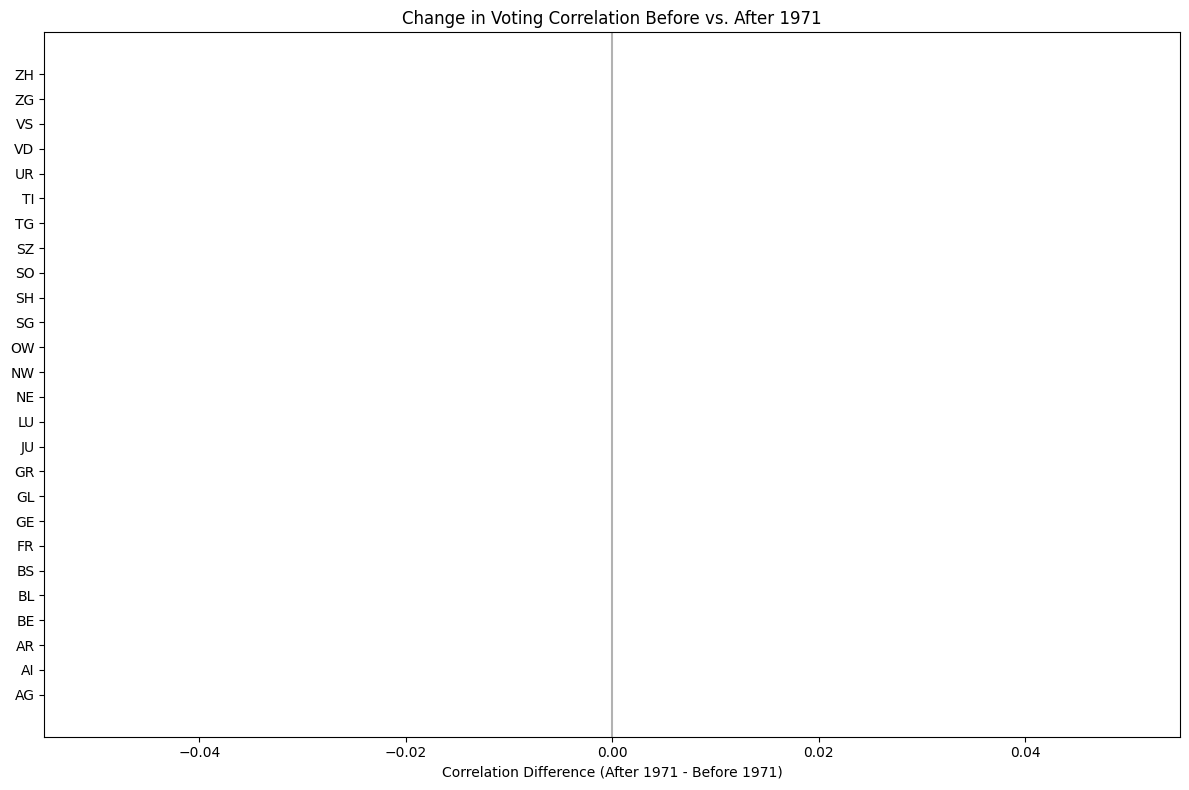

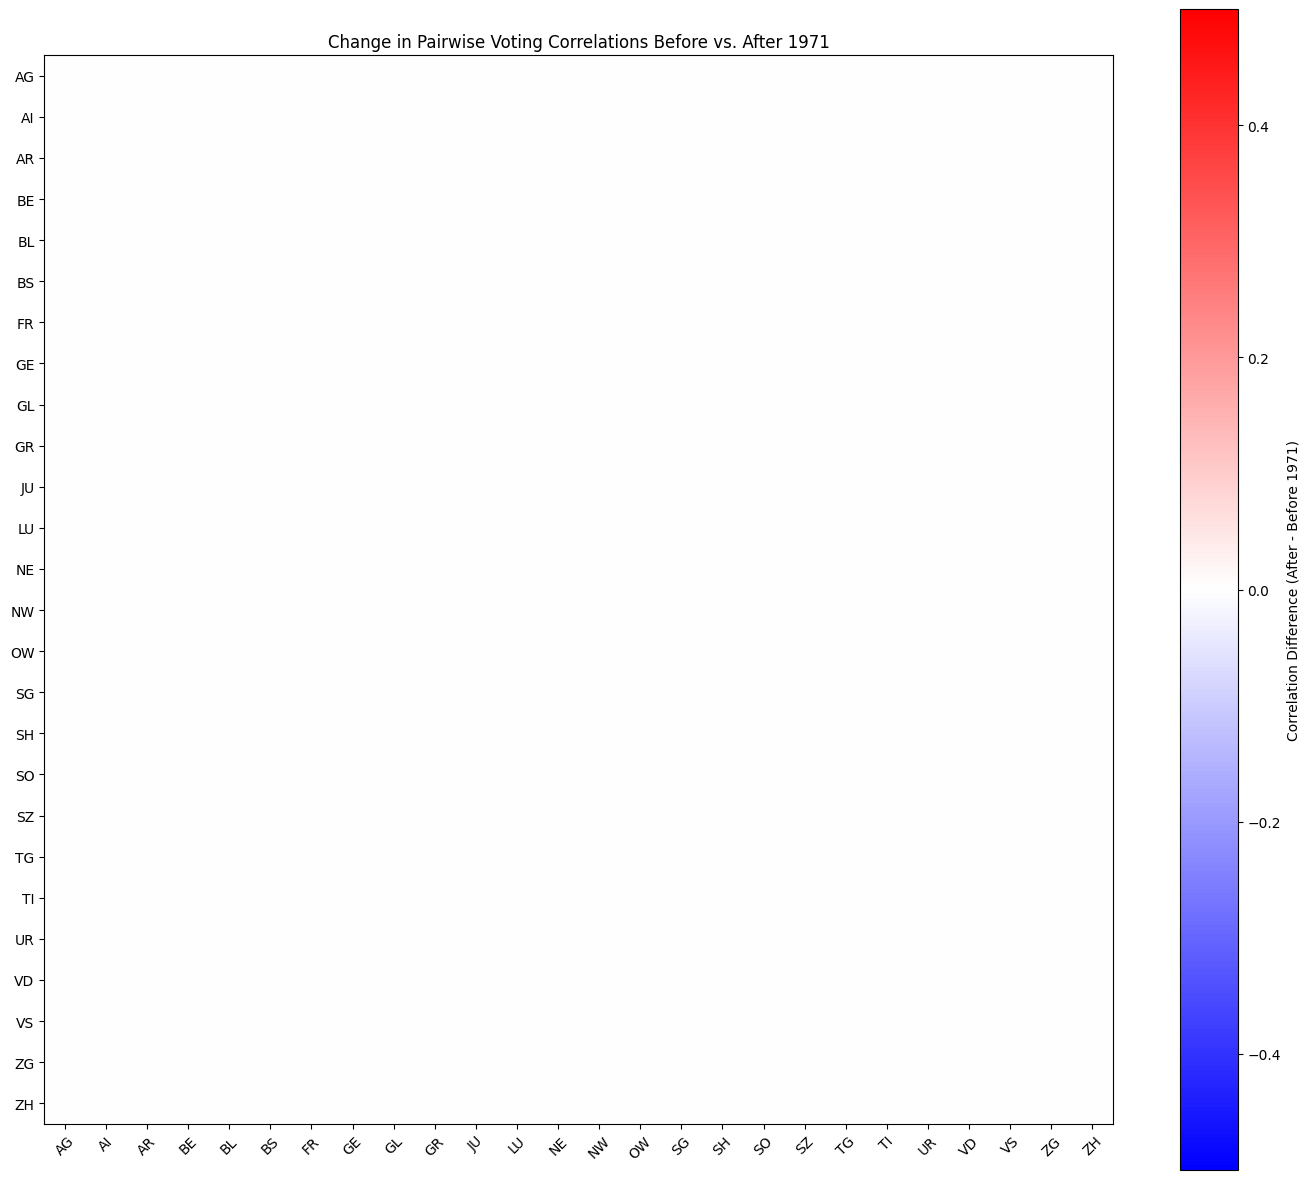

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd
import contextily as ctx
import warnings

# Suppress specific future warnings
warnings.filterwarnings('ignore', category=FutureWarning)

init_date = datetime(1971, 2, 7, 0, 0)

# Teile die Daten in Abstimmungen vor und nach der Einführung des Frauenstimmrechts
# Abstimmungen vor 1971 (ohne Frauenstimmrecht)
df_before_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') < init_date]
df_after_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') >= init_date]

# Create a list of all cantons
canton_codes = ['AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 
                'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 
                'TI', 'UR', 'VD', 'VS', 'ZG', 'ZH']

# Function to create a correlation matrix for a given time period
def create_correlation_matrix(data, canton_codes):
    # Create an empty correlation matrix
    corr_matrix = pd.DataFrame(index=canton_codes, columns=canton_codes)
    
    # For each pair of cantons, calculate the correlation of their voting patterns
    for i, canton1 in enumerate(canton_codes):
        for j, canton2 in enumerate(canton_codes):
            if i > j:  # Only calculate for the lower triangle
                continue
                
            # Get the voting data for both cantons
            canton1_col = f"{canton1.lower()}-japroz"
            canton2_col = f"{canton2.lower()}-japroz"
            
            # Check if both columns exist in the dataframe
            if canton1_col in data.columns and canton2_col in data.columns:
                # Get the voting percentages for both cantons
                votes1 = data[canton1_col].dropna()
                votes2 = data[canton2_col].dropna()
                
                # Find common votes (by index)
                common_indices = votes1.index.intersection(votes2.index)
                
                if len(common_indices) > 5:  # Only calculate if there are enough common votes
                    # Calculate correlation
                    correlation = np.corrcoef(
                        votes1.loc[common_indices], 
                        votes2.loc[common_indices]
                    )[0, 1]
                    
                    # Store in the matrix
                    corr_matrix.loc[canton1, canton2] = correlation
                    corr_matrix.loc[canton2, canton1] = correlation
                else:
                    corr_matrix.loc[canton1, canton2] = np.nan
                    corr_matrix.loc[canton2, canton1] = np.nan
            else:
                corr_matrix.loc[canton1, canton2] = np.nan
                corr_matrix.loc[canton2, canton1] = np.nan
                
    # Fill diagonal with 1s
    for canton in canton_codes:
        corr_matrix.loc[canton, canton] = 1.0
        
    return corr_matrix

# Create correlation matrices for both periods
corr_before = create_correlation_matrix(df_before_1971, canton_codes)
corr_after = create_correlation_matrix(df_after_1971, canton_codes)

# Handle the case of Jura (JU) which was created after 1971
if 'JU' in corr_before.index and corr_before.loc['JU'].isna().all():
    corr_before = corr_before.drop('JU', axis=0).drop('JU', axis=1)

# Fill NaN values with the mean of the respective matrix
# Using infer_objects() to avoid FutureWarning
corr_before = corr_before.fillna(corr_before.mean().mean()).infer_objects(copy=False)
corr_after = corr_after.fillna(corr_after.mean().mean()).infer_objects(copy=False)

# Calculate the difference in correlation patterns
# For each canton, we'll calculate the average correlation with all other cantons
corr_diff = {}
for canton in corr_before.index:
    if canton in corr_after.index:
        # Calculate average correlation with other cantons (excluding self-correlation)
        avg_corr_before = corr_before.loc[canton].drop(canton).mean()
        avg_corr_after = corr_after.loc[canton].drop(canton).mean()
        corr_diff[canton] = avg_corr_after - avg_corr_before

# Try to load Swiss cantons shapefile using GeoPandas
try:
    # Try to download Swiss cantons shapefile from a reliable source
    print("Loading Swiss cantons shapefile...")
    
    # Method 1: Use Natural Earth data (lower resolution but reliable)
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    swiss_map = world[world.name == 'Switzerland']
    
    if not swiss_map.empty:
        print("Using Natural Earth data for Switzerland outline.")
        
        # Create a simple choropleth with just the country outline
        fig, ax = plt.subplots(figsize=(12, 10))
        swiss_map.plot(ax=ax, color='lightgray', edgecolor='black')
        
        # Add a basemap for context
        try:
            ctx.add_basemap(ax, crs=swiss_map.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
        except:
            print("Could not add basemap. Continuing without it.")
        
        # Add text labels for each canton at approximate locations
        # These are approximate centroid coordinates for Swiss cantons (in lat/lon)
        canton_coords = {
            'ZH': (8.65, 47.37), 'BE': (7.44, 46.95), 'LU': (8.30, 47.05),
            'UR': (8.64, 46.78), 'SZ': (8.85, 47.02), 'OW': (8.24, 46.87),
            'NW': (8.38, 46.95), 'GL': (9.06, 46.98), 'ZG': (8.52, 47.17),
            'FR': (7.16, 46.80), 'SO': (7.64, 47.21), 'BS': (7.59, 47.56),
            'BL': (7.73, 47.44), 'SH': (8.52, 47.70), 'AR': (9.28, 47.38),
            'AI': (9.41, 47.33), 'SG': (9.36, 47.43), 'GR': (9.53, 46.65),
            'AG': (8.15, 47.40), 'TG': (9.10, 47.60), 'TI': (8.80, 46.33),
            'VD': (6.63, 46.62), 'VS': (7.55, 46.19), 'NE': (6.93, 47.05),
            'GE': (6.14, 46.20), 'JU': (7.14, 47.35)
        }
        
        # Create a colormap for the correlation differences
        norm = plt.Normalize(min(corr_diff.values()), max(corr_diff.values()))
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Add colored circles for each canton
        for canton, coords in canton_coords.items():
            if canton in corr_diff:
                color = cmap(norm(corr_diff[canton]))
                ax.scatter(coords[0], coords[1], color=color, s=300, 
                           edgecolor='black', zorder=5, alpha=0.8)
                ax.annotate(canton, xy=(coords[0], coords[1]), 
                           xytext=(0, 0), textcoords="offset points",
                           ha='center', va='center', fontsize=9, 
                           color='black', fontweight='bold')
        
        # Add a colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('Correlation Difference (After - Before 1971)')
        
        plt.title('Change in Voting Correlation Patterns Before vs. After 1971')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        raise Exception("Could not find Switzerland in Natural Earth data")
        
except Exception as e:
    print(f"Error creating map: {e}")
    print("Creating alternative visualizations...")
    
    # Create a bar chart
    plt.figure(figsize=(12, 8))
    cantons = list(corr_diff.keys())
    values = list(corr_diff.values())
    
    # Sort by correlation difference
    sorted_indices = np.argsort(values)
    sorted_cantons = [cantons[i] for i in sorted_indices]
    sorted_values = [values[i] for i in sorted_indices]
    
    # Create color mapping
    colors = ['blue' if v < 0 else 'red' for v in sorted_values]
    
    plt.barh(sorted_cantons, sorted_values, color=colors)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Change in Voting Correlation Before vs. After 1971')
    plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
    plt.tight_layout()
    plt.show()
    
    # Create a heatmap of the correlation differences
    plt.figure(figsize=(14, 12))
    diff_matrix = corr_after - corr_before
    
    # Create a custom colormap
    cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
    
    # Plot the heatmap
    im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
    plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
    
    # Add canton labels
    plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
    plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
    
    plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
    plt.tight_layout()
    plt.show()

C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_before = corr_before.fillna(corr_before.mean().mean())
C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:86: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_after = corr_after.fillna(corr_after.mean().mean())


Error downloading shapefile: File is not a zip file
Creating a simple visualization without the map...


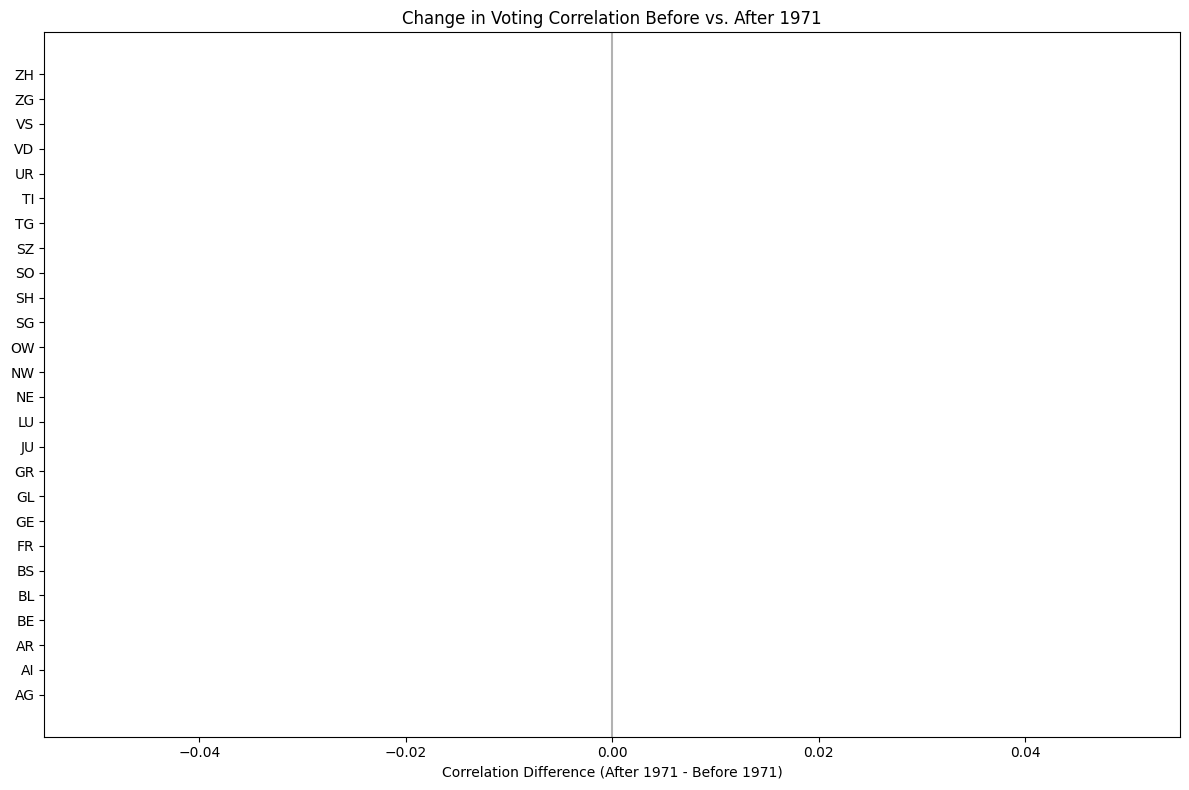

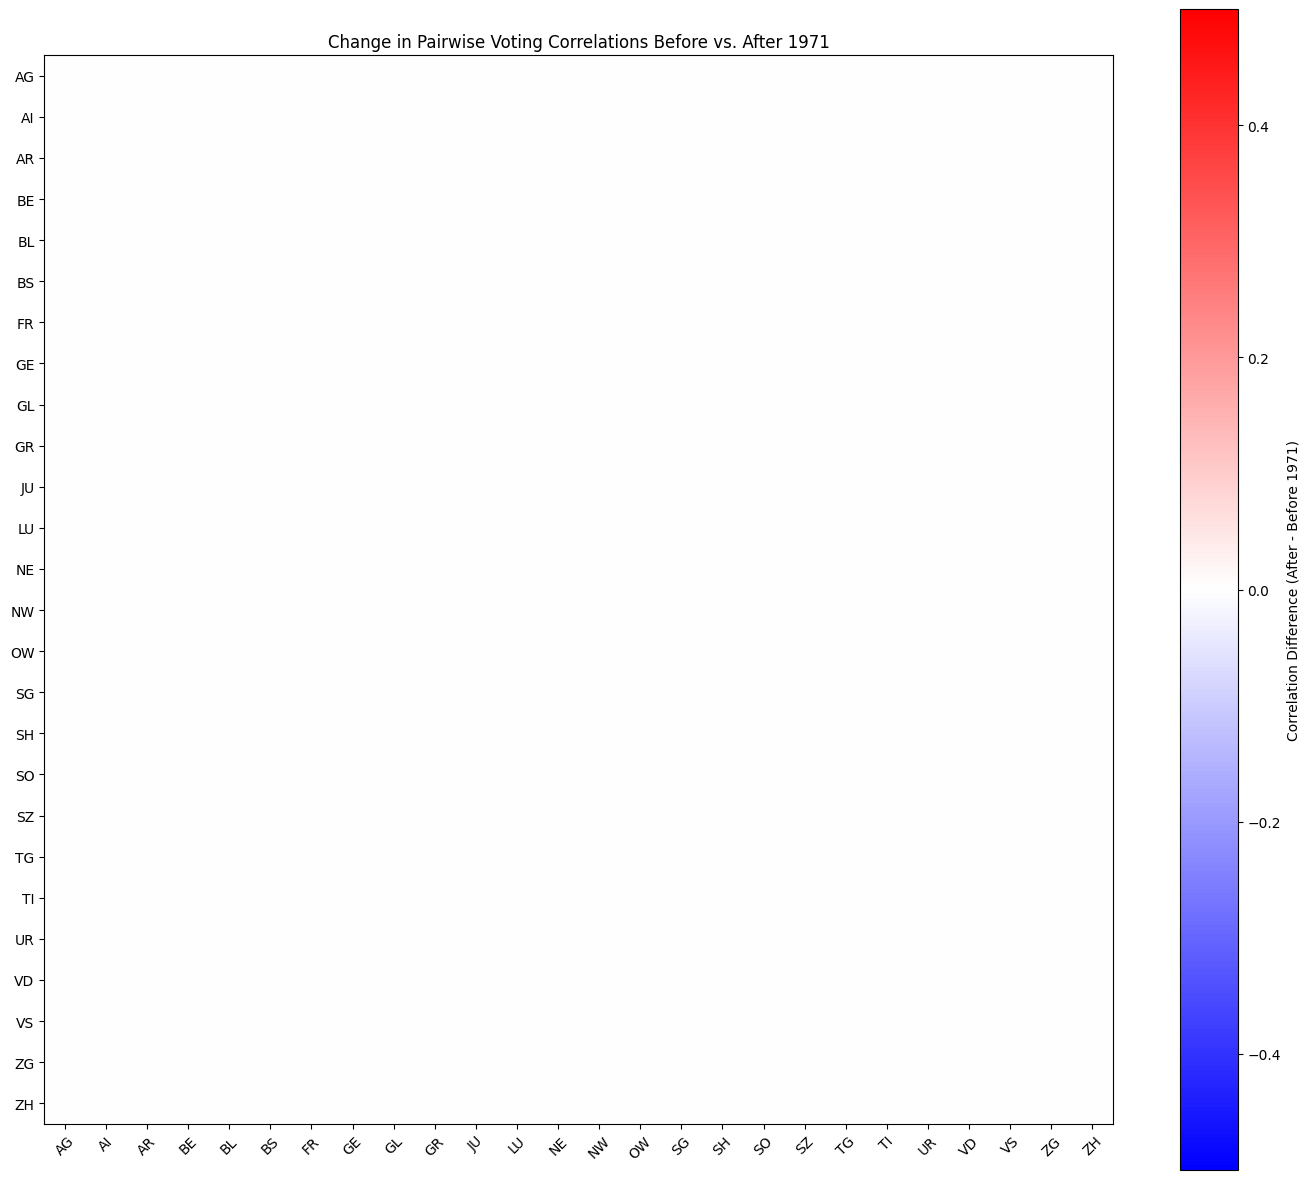

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import requests
import io
import zipfile
import os

# First, let's prepare the data
# Assuming 'df' is your dataframe with the voting data
# We need to extract the canton-level voting data before and after 1971

# First, let's split the data into before and after 1971
init_date = datetime(1971, 2, 7, 0, 0)

# Teile die Daten in Abstimmungen vor und nach der Einführung des Frauenstimmrechts
# Abstimmungen vor 1971 (ohne Frauenstimmrecht)
df_before_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') < init_date]
df_after_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') >= init_date]

# Create a list of all cantons
canton_codes = ['AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 
                'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 
                'TI', 'UR', 'VD', 'VS', 'ZG', 'ZH']

# Function to create a correlation matrix for a given time period
def create_correlation_matrix(data, canton_codes):
    # Create an empty correlation matrix
    corr_matrix = pd.DataFrame(index=canton_codes, columns=canton_codes)
    
    # For each pair of cantons, calculate the correlation of their voting patterns
    for i, canton1 in enumerate(canton_codes):
        for j, canton2 in enumerate(canton_codes):
            if i > j:  # Only calculate for the lower triangle
                continue
                
            # Get the voting data for both cantons
            canton1_col = f"{canton1.lower()}-japroz"
            canton2_col = f"{canton2.lower()}-japroz"
            
            # Check if both columns exist in the dataframe
            if canton1_col in data.columns and canton2_col in data.columns:
                # Get the voting percentages for both cantons
                votes1 = data[canton1_col].dropna()
                votes2 = data[canton2_col].dropna()
                
                # Find common votes (by index)
                common_indices = votes1.index.intersection(votes2.index)
                
                if len(common_indices) > 5:  # Only calculate if there are enough common votes
                    # Calculate correlation
                    correlation = np.corrcoef(
                        votes1.loc[common_indices], 
                        votes2.loc[common_indices]
                    )[0, 1]
                    
                    # Store in the matrix
                    corr_matrix.loc[canton1, canton2] = correlation
                    corr_matrix.loc[canton2, canton1] = correlation
                else:
                    corr_matrix.loc[canton1, canton2] = np.nan
                    corr_matrix.loc[canton2, canton1] = np.nan
            else:
                corr_matrix.loc[canton1, canton2] = np.nan
                corr_matrix.loc[canton2, canton1] = np.nan
                
    # Fill diagonal with 1s
    for canton in canton_codes:
        corr_matrix.loc[canton, canton] = 1.0
        
    return corr_matrix

# Create correlation matrices for both periods
corr_before = create_correlation_matrix(df_before_1971, canton_codes)
corr_after = create_correlation_matrix(df_after_1971, canton_codes)

# Handle the case of Jura (JU) which was created after 1971
if 'JU' in corr_before.index and corr_before.loc['JU'].isna().all():
    corr_before = corr_before.drop('JU', axis=0).drop('JU', axis=1)

# Fill NaN values with the mean of the respective matrix
corr_before = corr_before.fillna(corr_before.mean().mean())
corr_after = corr_after.fillna(corr_after.mean().mean())

# Calculate the difference in correlation patterns
# For each canton, we'll calculate the average correlation with all other cantons
corr_diff = {}
for canton in corr_before.index:
    if canton in corr_after.index:
        # Calculate average correlation with other cantons (excluding self-correlation)
        avg_corr_before = corr_before.loc[canton].drop(canton).mean()
        avg_corr_after = corr_after.loc[canton].drop(canton).mean()
        corr_diff[canton] = avg_corr_after - avg_corr_before

# Download Swiss cantons shapefile if not already available
shapefile_path = 'data/swiss_cantons'
if not os.path.exists(shapefile_path):
    os.makedirs(shapefile_path, exist_ok=True)
    
    # URL for Swiss cantons shapefile (this is an example URL, you may need to find the correct one)
    url = "https://www.swisstopo.admin.ch/content/swisstopo-internet/en/geodata/landscape/boundaries3d/_jcr_content/contentPar/tabs/items/documents_publicatio/tabPar/downloadlist/downloadItems/1_1547207224391.download/BOUNDARIES_2022-01-01_2056_EN.zip"
    
    try:
        print("Downloading Swiss cantons shapefile...")
        response = requests.get(url)
        if response.status_code == 200:
            z = zipfile.ZipFile(io.BytesIO(response.content))
            z.extractall(shapefile_path)
            print("Download and extraction complete.")
        else:
            print(f"Failed to download shapefile: HTTP {response.status_code}")
            raise Exception("Download failed")
    except Exception as e:
        print(f"Error downloading shapefile: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a mask for the upper triangle
        mask = np.triu(np.ones_like(diff_matrix, dtype=bool))
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()
else:
    try:
        # Try to load the shapefile
        shapefile = os.path.join(shapefile_path, 'swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp')
        swiss_map = gpd.read_file(shapefile)
        
        # Map the canton names to match the shapefile
        # This mapping might need adjustment based on your shapefile
        canton_mapping = {
            'AG': 'Aargau', 'AI': 'Appenzell Innerrhoden', 'AR': 'Appenzell Ausserrhoden',
            'BE': 'Bern', 'BL': 'Basel-Landschaft', 'BS': 'Basel-Stadt', 'FR': 'Fribourg',
            'GE': 'Genève', 'GL': 'Glarus', 'GR': 'Graubünden', 'JU': 'Jura', 'LU': 'Luzern',
            'NE': 'Neuchâtel', 'NW': 'Nidwalden', 'OW': 'Obwalden', 'SG': 'St. Gallen',
            'SH': 'Schaffhausen', 'SO': 'Solothurn', 'SZ': 'Schwyz', 'TG': 'Thurgau',
            'TI': 'Ticino', 'UR': 'Uri', 'VD': 'Vaud', 'VS': 'Valais', 'ZG': 'Zug', 'ZH': 'Zürich'
        }
        
        # Create a new column with the correlation differences
        swiss_map['corr_diff'] = swiss_map['NAME'].map(
            lambda x: corr_diff.get(next((k for k, v in canton_mapping.items() if v == x), None), 0)
        )
        
        # Create a custom colormap: blue for negative, white for zero, red for positive
        colors = ['blue', 'white', 'red']
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', colors, N=256)
        
        # Plot the map
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        
        # Find the maximum absolute value for symmetric color scaling
        vmax = max(abs(min(corr_diff.values())), abs(max(corr_diff.values())))
        
        swiss_map.plot(
            column='corr_diff',
            cmap=cmap,
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            vmin=-vmax,
            vmax=vmax,
            legend=True,
            legend_kwds={'label': 'Correlation Difference (After - Before 1971)'}
        )
        
        # Add canton labels
        for idx, row in swiss_map.iterrows():
            plt.annotate(text=row['NAME'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                        horizontalalignment='center', fontsize=8)
        
        plt.title('Change in Voting Correlation Patterns Before vs. After 1971')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating map: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()

C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_before = corr_before.fillna(corr_before.mean().mean())
C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:86: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_after = corr_after.fillna(corr_after.mean().mean())


Error downloading shapefile: File is not a zip file
Creating a simple visualization without the map...


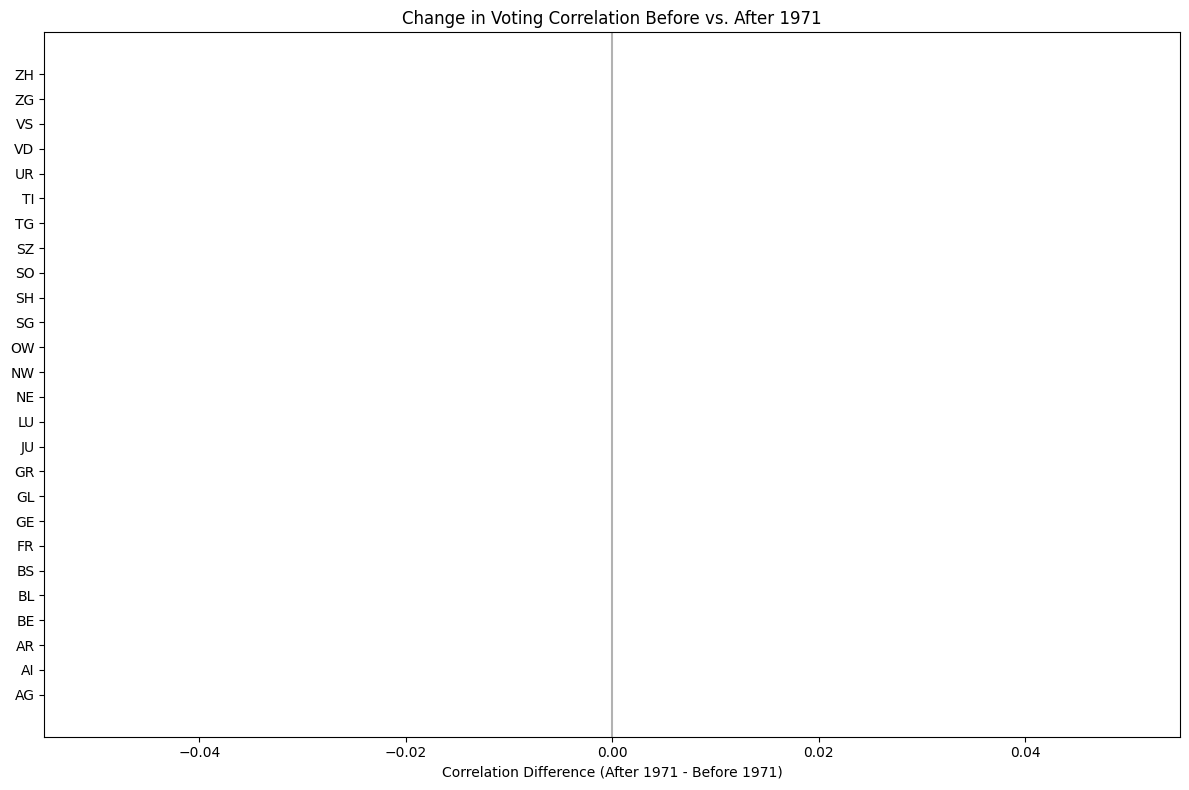

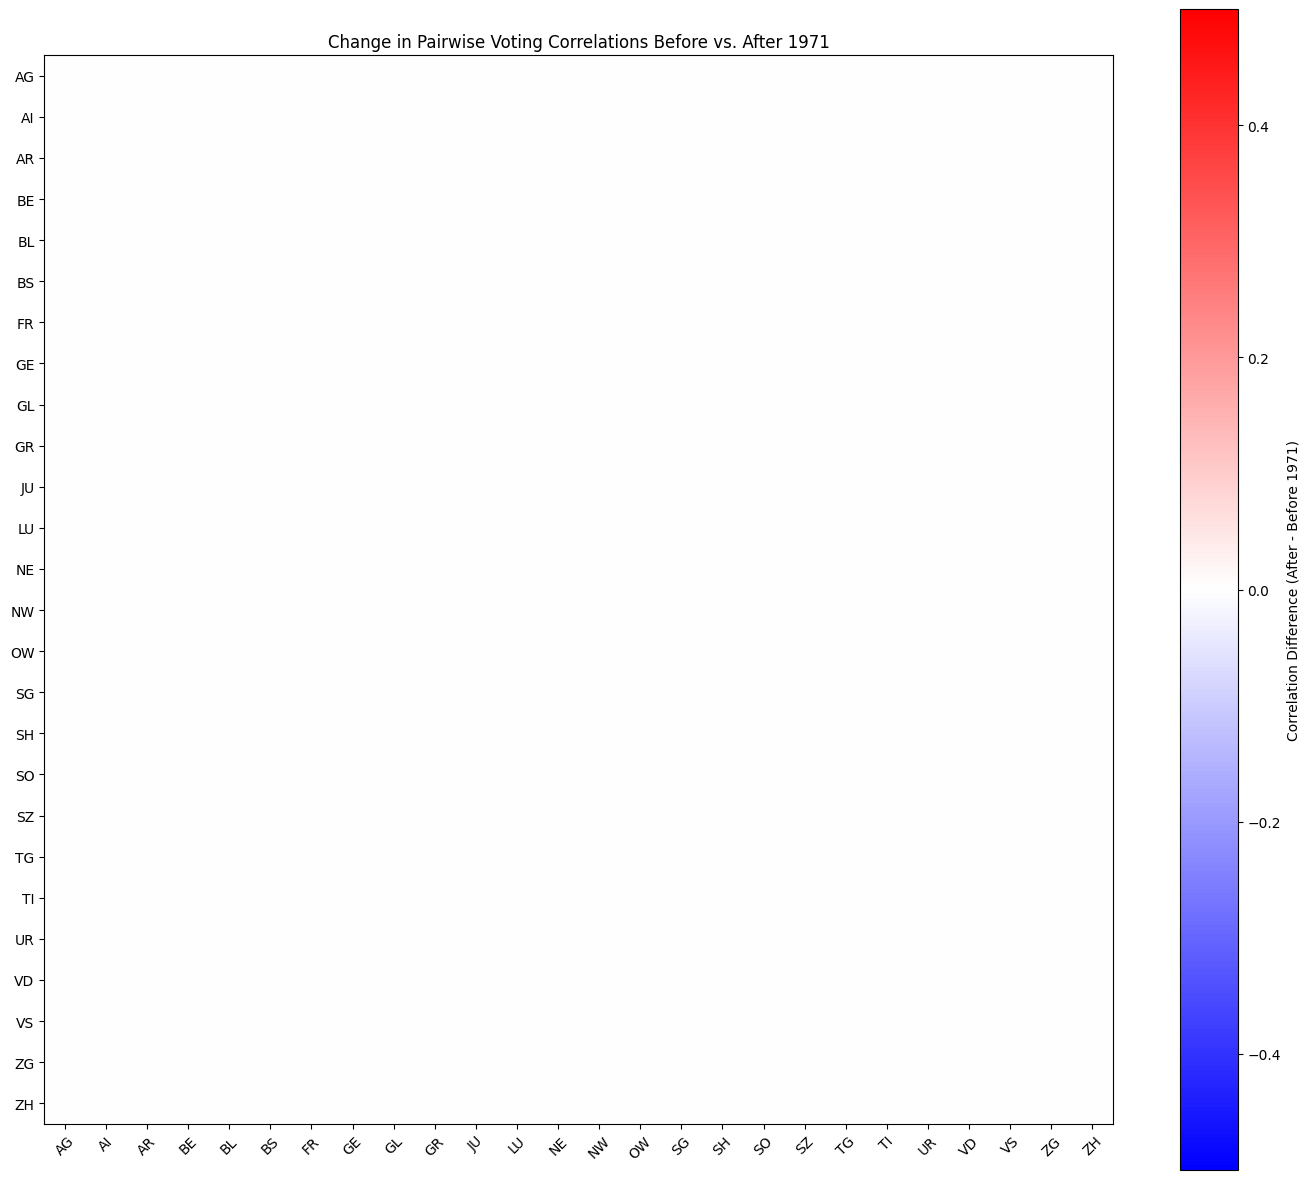

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import requests
import io
import zipfile
import os

# First, let's prepare the data
# Assuming 'df' is your dataframe with the voting data
# We need to extract the canton-level voting data before and after 1971

# First, let's split the data into before and after 1971
init_date = datetime(1971, 2, 7, 0, 0)

# Teile die Daten in Abstimmungen vor und nach der Einführung des Frauenstimmrechts
# Abstimmungen vor 1971 (ohne Frauenstimmrecht)
df_before_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') < init_date]
df_after_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') >= init_date]

# Create a list of all cantons
canton_codes = ['AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 
                'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 
                'TI', 'UR', 'VD', 'VS', 'ZG', 'ZH']

# Function to create a correlation matrix for a given time period
def create_correlation_matrix(data, canton_codes):
    # Create an empty correlation matrix
    corr_matrix = pd.DataFrame(index=canton_codes, columns=canton_codes)
    
    # For each pair of cantons, calculate the correlation of their voting patterns
    for i, canton1 in enumerate(canton_codes):
        for j, canton2 in enumerate(canton_codes):
            if i > j:  # Only calculate for the lower triangle
                continue
                
            # Get the voting data for both cantons
            canton1_col = f"{canton1.lower()}-japroz"
            canton2_col = f"{canton2.lower()}-japroz"
            
            # Check if both columns exist in the dataframe
            if canton1_col in data.columns and canton2_col in data.columns:
                # Get the voting percentages for both cantons
                votes1 = data[canton1_col].dropna()
                votes2 = data[canton2_col].dropna()
                
                # Find common votes (by index)
                common_indices = votes1.index.intersection(votes2.index)
                
                if len(common_indices) > 5:  # Only calculate if there are enough common votes
                    # Calculate correlation
                    correlation = np.corrcoef(
                        votes1.loc[common_indices], 
                        votes2.loc[common_indices]
                    )[0, 1]
                    
                    # Store in the matrix
                    corr_matrix.loc[canton1, canton2] = correlation
                    corr_matrix.loc[canton2, canton1] = correlation
                else:
                    corr_matrix.loc[canton1, canton2] = np.nan
                    corr_matrix.loc[canton2, canton1] = np.nan
            else:
                corr_matrix.loc[canton1, canton2] = np.nan
                corr_matrix.loc[canton2, canton1] = np.nan
                
    # Fill diagonal with 1s
    for canton in canton_codes:
        corr_matrix.loc[canton, canton] = 1.0
        
    return corr_matrix

# Create correlation matrices for both periods
corr_before = create_correlation_matrix(df_before_1971, canton_codes)
corr_after = create_correlation_matrix(df_after_1971, canton_codes)

# Handle the case of Jura (JU) which was created after 1971
if 'JU' in corr_before.index and corr_before.loc['JU'].isna().all():
    corr_before = corr_before.drop('JU', axis=0).drop('JU', axis=1)

# Fill NaN values with the mean of the respective matrix
corr_before = corr_before.fillna(corr_before.mean().mean())
corr_after = corr_after.fillna(corr_after.mean().mean())

# Calculate the difference in correlation patterns
# For each canton, we'll calculate the average correlation with all other cantons
corr_diff = {}
for canton in corr_before.index:
    if canton in corr_after.index:
        # Calculate average correlation with other cantons (excluding self-correlation)
        avg_corr_before = corr_before.loc[canton].drop(canton).mean()
        avg_corr_after = corr_after.loc[canton].drop(canton).mean()
        corr_diff[canton] = avg_corr_after - avg_corr_before

# Download Swiss cantons shapefile if not already available
shapefile_path = 'data/swiss_cantons'
if not os.path.exists(shapefile_path):
    os.makedirs(shapefile_path, exist_ok=True)
    
    # URL for Swiss cantons shapefile (this is an example URL, you may need to find the correct one)
    url = "https://www.swisstopo.admin.ch/content/swisstopo-internet/en/geodata/landscape/boundaries3d/_jcr_content/contentPar/tabs/items/documents_publicatio/tabPar/downloadlist/downloadItems/1_1547207224391.download/BOUNDARIES_2022-01-01_2056_EN.zip"
    
    try:
        print("Downloading Swiss cantons shapefile...")
        response = requests.get(url)
        if response.status_code == 200:
            z = zipfile.ZipFile(io.BytesIO(response.content))
            z.extractall(shapefile_path)
            print("Download and extraction complete.")
        else:
            print(f"Failed to download shapefile: HTTP {response.status_code}")
            raise Exception("Download failed")
    except Exception as e:
        print(f"Error downloading shapefile: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a mask for the upper triangle
        mask = np.triu(np.ones_like(diff_matrix, dtype=bool))
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()
else:
    try:
        # Try to load the shapefile
        shapefile = os.path.join(shapefile_path, 'swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp')
        swiss_map = gpd.read_file(shapefile)
        
        # Map the canton names to match the shapefile
        # This mapping might need adjustment based on your shapefile
        canton_mapping = {
            'AG': 'Aargau', 'AI': 'Appenzell Innerrhoden', 'AR': 'Appenzell Ausserrhoden',
            'BE': 'Bern', 'BL': 'Basel-Landschaft', 'BS': 'Basel-Stadt', 'FR': 'Fribourg',
            'GE': 'Genève', 'GL': 'Glarus', 'GR': 'Graubünden', 'JU': 'Jura', 'LU': 'Luzern',
            'NE': 'Neuchâtel', 'NW': 'Nidwalden', 'OW': 'Obwalden', 'SG': 'St. Gallen',
            'SH': 'Schaffhausen', 'SO': 'Solothurn', 'SZ': 'Schwyz', 'TG': 'Thurgau',
            'TI': 'Ticino', 'UR': 'Uri', 'VD': 'Vaud', 'VS': 'Valais', 'ZG': 'Zug', 'ZH': 'Zürich'
        }
        
        # Create a new column with the correlation differences
        swiss_map['corr_diff'] = swiss_map['NAME'].map(
            lambda x: corr_diff.get(next((k for k, v in canton_mapping.items() if v == x), None), 0)
        )
        
        # Create a custom colormap: blue for negative, white for zero, red for positive
        colors = ['blue', 'white', 'red']
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', colors, N=256)
        
        # Plot the map
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        
        # Find the maximum absolute value for symmetric color scaling
        vmax = max(abs(min(corr_diff.values())), abs(max(corr_diff.values())))
        
        swiss_map.plot(
            column='corr_diff',
            cmap=cmap,
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            vmin=-vmax,
            vmax=vmax,
            legend=True,
            legend_kwds={'label': 'Correlation Difference (After - Before 1971)'}
        )
        
        # Add canton labels
        for idx, row in swiss_map.iterrows():
            plt.annotate(text=row['NAME'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                        horizontalalignment='center', fontsize=8)
        
        plt.title('Change in Voting Correlation Patterns Before vs. After 1971')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating map: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()

C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_before = corr_before.fillna(corr_before.mean().mean())
C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:86: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_after = corr_after.fillna(corr_after.mean().mean())


Error downloading shapefile: File is not a zip file
Creating a simple visualization without the map...


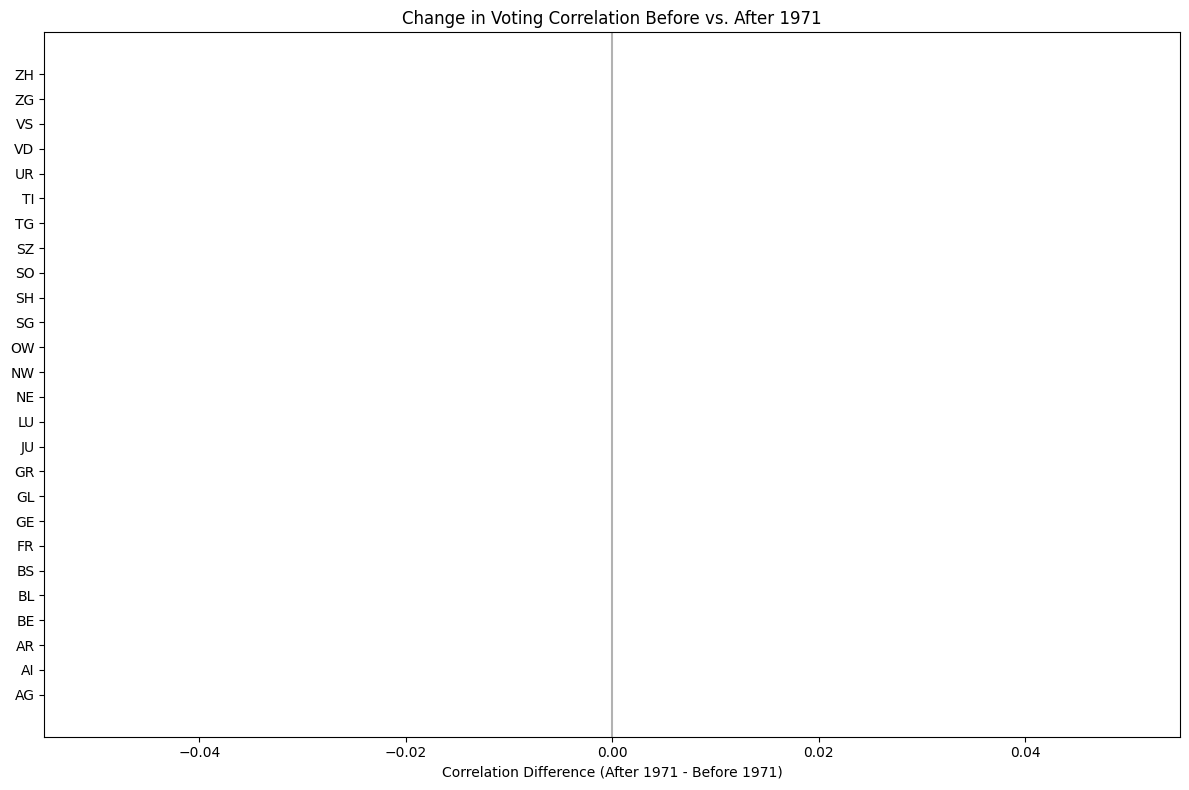

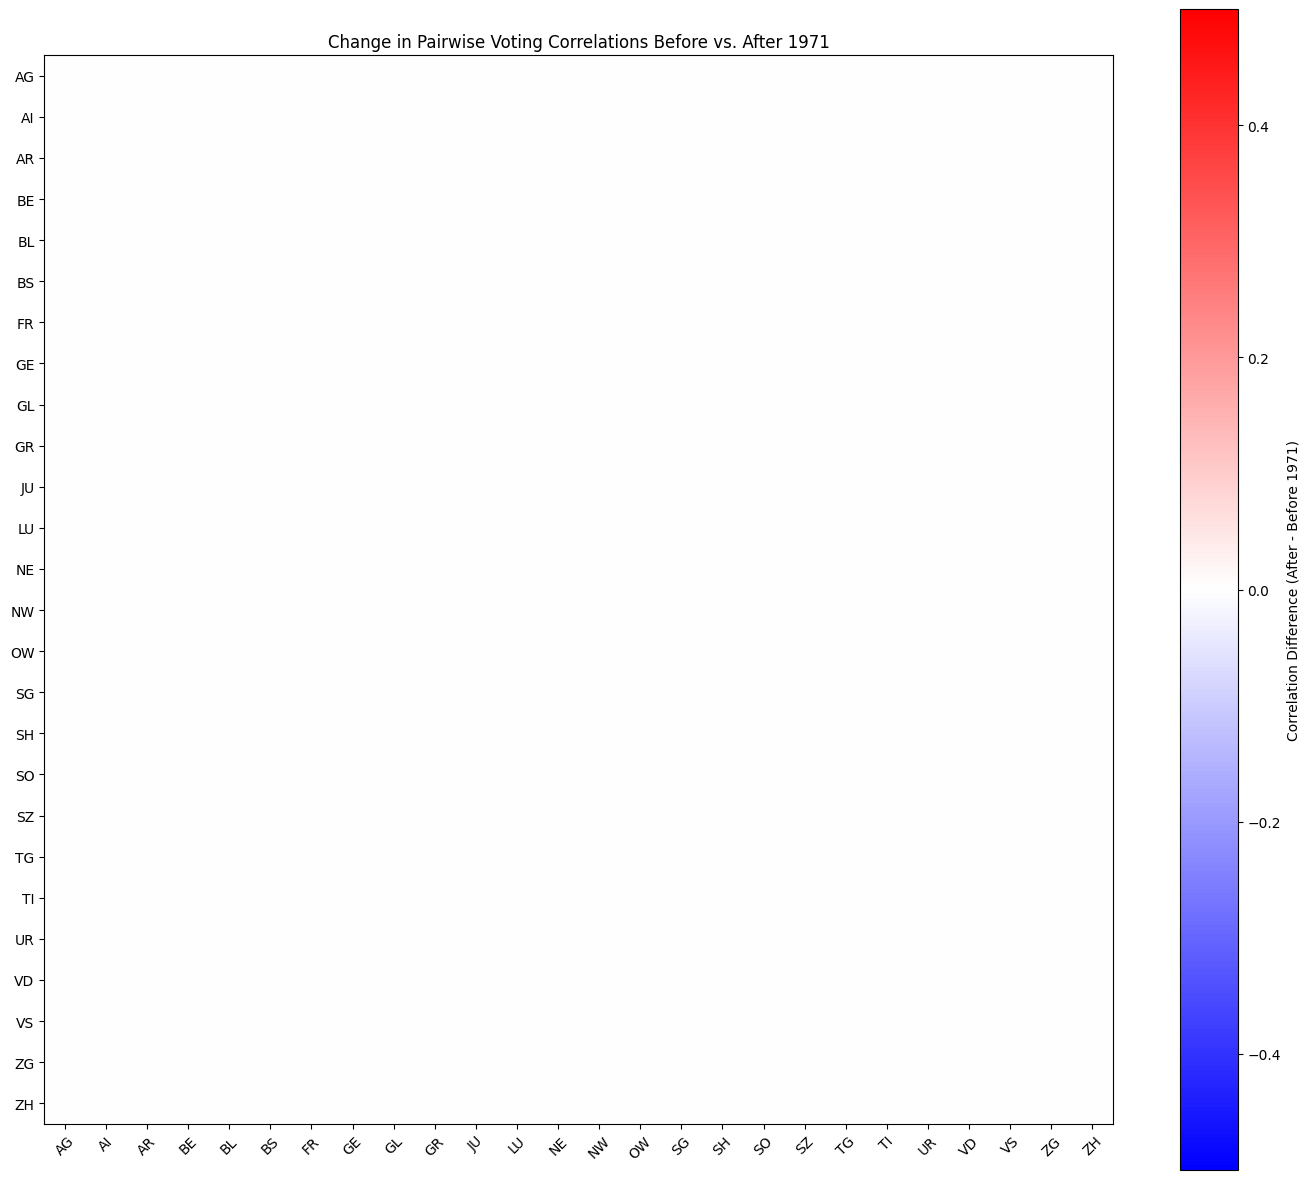

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import requests
import io
import zipfile
import os

# First, let's prepare the data
# Assuming 'df' is your dataframe with the voting data
# We need to extract the canton-level voting data before and after 1971

# First, let's split the data into before and after 1971
init_date = datetime(1971, 2, 7, 0, 0)

# Teile die Daten in Abstimmungen vor und nach der Einführung des Frauenstimmrechts
# Abstimmungen vor 1971 (ohne Frauenstimmrecht)
df_before_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') < init_date]
df_after_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') >= init_date]

# Create a list of all cantons
canton_codes = ['AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 
                'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 
                'TI', 'UR', 'VD', 'VS', 'ZG', 'ZH']

# Function to create a correlation matrix for a given time period
def create_correlation_matrix(data, canton_codes):
    # Create an empty correlation matrix
    corr_matrix = pd.DataFrame(index=canton_codes, columns=canton_codes)
    
    # For each pair of cantons, calculate the correlation of their voting patterns
    for i, canton1 in enumerate(canton_codes):
        for j, canton2 in enumerate(canton_codes):
            if i > j:  # Only calculate for the lower triangle
                continue
                
            # Get the voting data for both cantons
            canton1_col = f"{canton1.lower()}-japroz"
            canton2_col = f"{canton2.lower()}-japroz"
            
            # Check if both columns exist in the dataframe
            if canton1_col in data.columns and canton2_col in data.columns:
                # Get the voting percentages for both cantons
                votes1 = data[canton1_col].dropna()
                votes2 = data[canton2_col].dropna()
                
                # Find common votes (by index)
                common_indices = votes1.index.intersection(votes2.index)
                
                if len(common_indices) > 5:  # Only calculate if there are enough common votes
                    # Calculate correlation
                    correlation = np.corrcoef(
                        votes1.loc[common_indices], 
                        votes2.loc[common_indices]
                    )[0, 1]
                    
                    # Store in the matrix
                    corr_matrix.loc[canton1, canton2] = correlation
                    corr_matrix.loc[canton2, canton1] = correlation
                else:
                    corr_matrix.loc[canton1, canton2] = np.nan
                    corr_matrix.loc[canton2, canton1] = np.nan
            else:
                corr_matrix.loc[canton1, canton2] = np.nan
                corr_matrix.loc[canton2, canton1] = np.nan
                
    # Fill diagonal with 1s
    for canton in canton_codes:
        corr_matrix.loc[canton, canton] = 1.0
        
    return corr_matrix

# Create correlation matrices for both periods
corr_before = create_correlation_matrix(df_before_1971, canton_codes)
corr_after = create_correlation_matrix(df_after_1971, canton_codes)

# Handle the case of Jura (JU) which was created after 1971
if 'JU' in corr_before.index and corr_before.loc['JU'].isna().all():
    corr_before = corr_before.drop('JU', axis=0).drop('JU', axis=1)

# Fill NaN values with the mean of the respective matrix
corr_before = corr_before.fillna(corr_before.mean().mean())
corr_after = corr_after.fillna(corr_after.mean().mean())

# Calculate the difference in correlation patterns
# For each canton, we'll calculate the average correlation with all other cantons
corr_diff = {}
for canton in corr_before.index:
    if canton in corr_after.index:
        # Calculate average correlation with other cantons (excluding self-correlation)
        avg_corr_before = corr_before.loc[canton].drop(canton).mean()
        avg_corr_after = corr_after.loc[canton].drop(canton).mean()
        corr_diff[canton] = avg_corr_after - avg_corr_before

# Download Swiss cantons shapefile if not already available
shapefile_path = 'data/swiss_cantons'
if not os.path.exists(shapefile_path):
    os.makedirs(shapefile_path, exist_ok=True)
    
    # URL for Swiss cantons shapefile (this is an example URL, you may need to find the correct one)
    url = "https://www.swisstopo.admin.ch/content/swisstopo-internet/en/geodata/landscape/boundaries3d/_jcr_content/contentPar/tabs/items/documents_publicatio/tabPar/downloadlist/downloadItems/1_1547207224391.download/BOUNDARIES_2022-01-01_2056_EN.zip"
    
    try:
        print("Downloading Swiss cantons shapefile...")
        response = requests.get(url)
        if response.status_code == 200:
            z = zipfile.ZipFile(io.BytesIO(response.content))
            z.extractall(shapefile_path)
            print("Download and extraction complete.")
        else:
            print(f"Failed to download shapefile: HTTP {response.status_code}")
            raise Exception("Download failed")
    except Exception as e:
        print(f"Error downloading shapefile: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a mask for the upper triangle
        mask = np.triu(np.ones_like(diff_matrix, dtype=bool))
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()
else:
    try:
        # Try to load the shapefile
        shapefile = os.path.join(shapefile_path, 'swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp')
        swiss_map = gpd.read_file(shapefile)
        
        # Map the canton names to match the shapefile
        # This mapping might need adjustment based on your shapefile
        canton_mapping = {
            'AG': 'Aargau', 'AI': 'Appenzell Innerrhoden', 'AR': 'Appenzell Ausserrhoden',
            'BE': 'Bern', 'BL': 'Basel-Landschaft', 'BS': 'Basel-Stadt', 'FR': 'Fribourg',
            'GE': 'Genève', 'GL': 'Glarus', 'GR': 'Graubünden', 'JU': 'Jura', 'LU': 'Luzern',
            'NE': 'Neuchâtel', 'NW': 'Nidwalden', 'OW': 'Obwalden', 'SG': 'St. Gallen',
            'SH': 'Schaffhausen', 'SO': 'Solothurn', 'SZ': 'Schwyz', 'TG': 'Thurgau',
            'TI': 'Ticino', 'UR': 'Uri', 'VD': 'Vaud', 'VS': 'Valais', 'ZG': 'Zug', 'ZH': 'Zürich'
        }
        
        # Create a new column with the correlation differences
        swiss_map['corr_diff'] = swiss_map['NAME'].map(
            lambda x: corr_diff.get(next((k for k, v in canton_mapping.items() if v == x), None), 0)
        )
        
        # Create a custom colormap: blue for negative, white for zero, red for positive
        colors = ['blue', 'white', 'red']
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', colors, N=256)
        
        # Plot the map
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        
        # Find the maximum absolute value for symmetric color scaling
        vmax = max(abs(min(corr_diff.values())), abs(max(corr_diff.values())))
        
        swiss_map.plot(
            column='corr_diff',
            cmap=cmap,
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            vmin=-vmax,
            vmax=vmax,
            legend=True,
            legend_kwds={'label': 'Correlation Difference (After - Before 1971)'}
        )
        
        # Add canton labels
        for idx, row in swiss_map.iterrows():
            plt.annotate(text=row['NAME'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                        horizontalalignment='center', fontsize=8)
        
        plt.title('Change in Voting Correlation Patterns Before vs. After 1971')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating map: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()

C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_before = corr_before.fillna(corr_before.mean().mean())
C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:86: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_after = corr_after.fillna(corr_after.mean().mean())


Error downloading shapefile: File is not a zip file
Creating a simple visualization without the map...


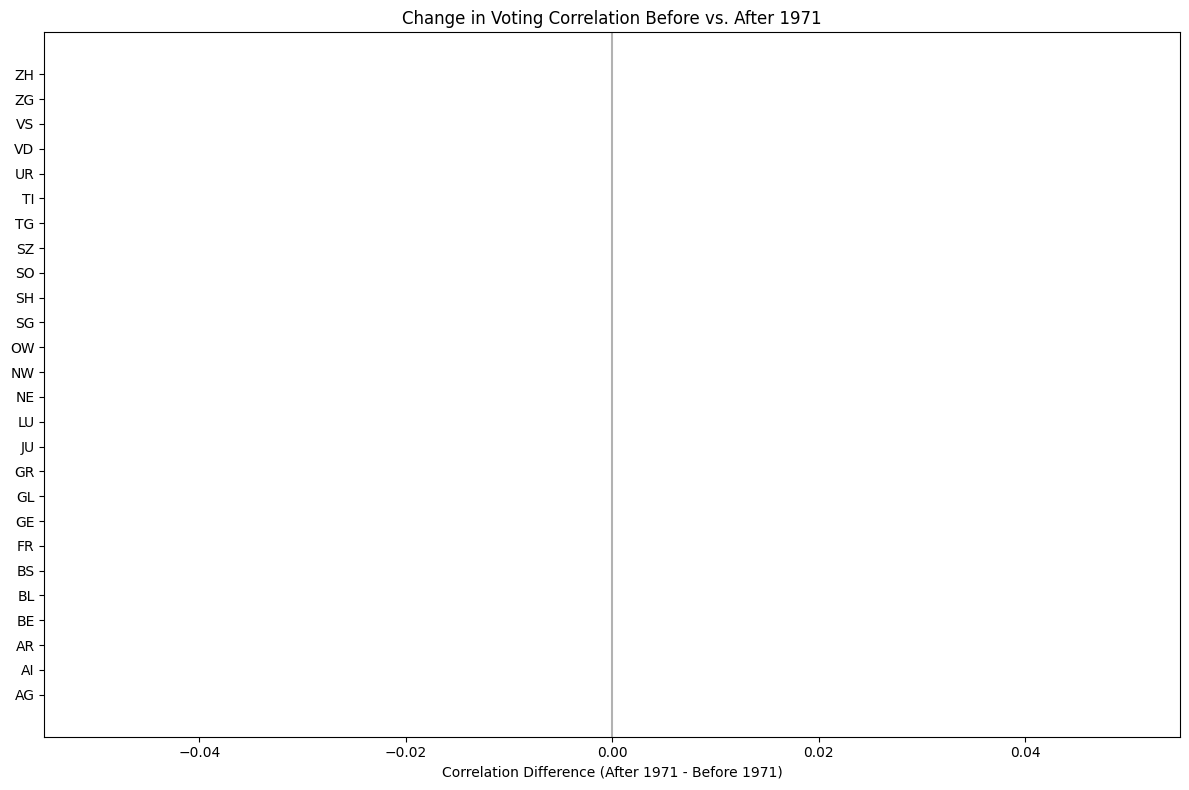

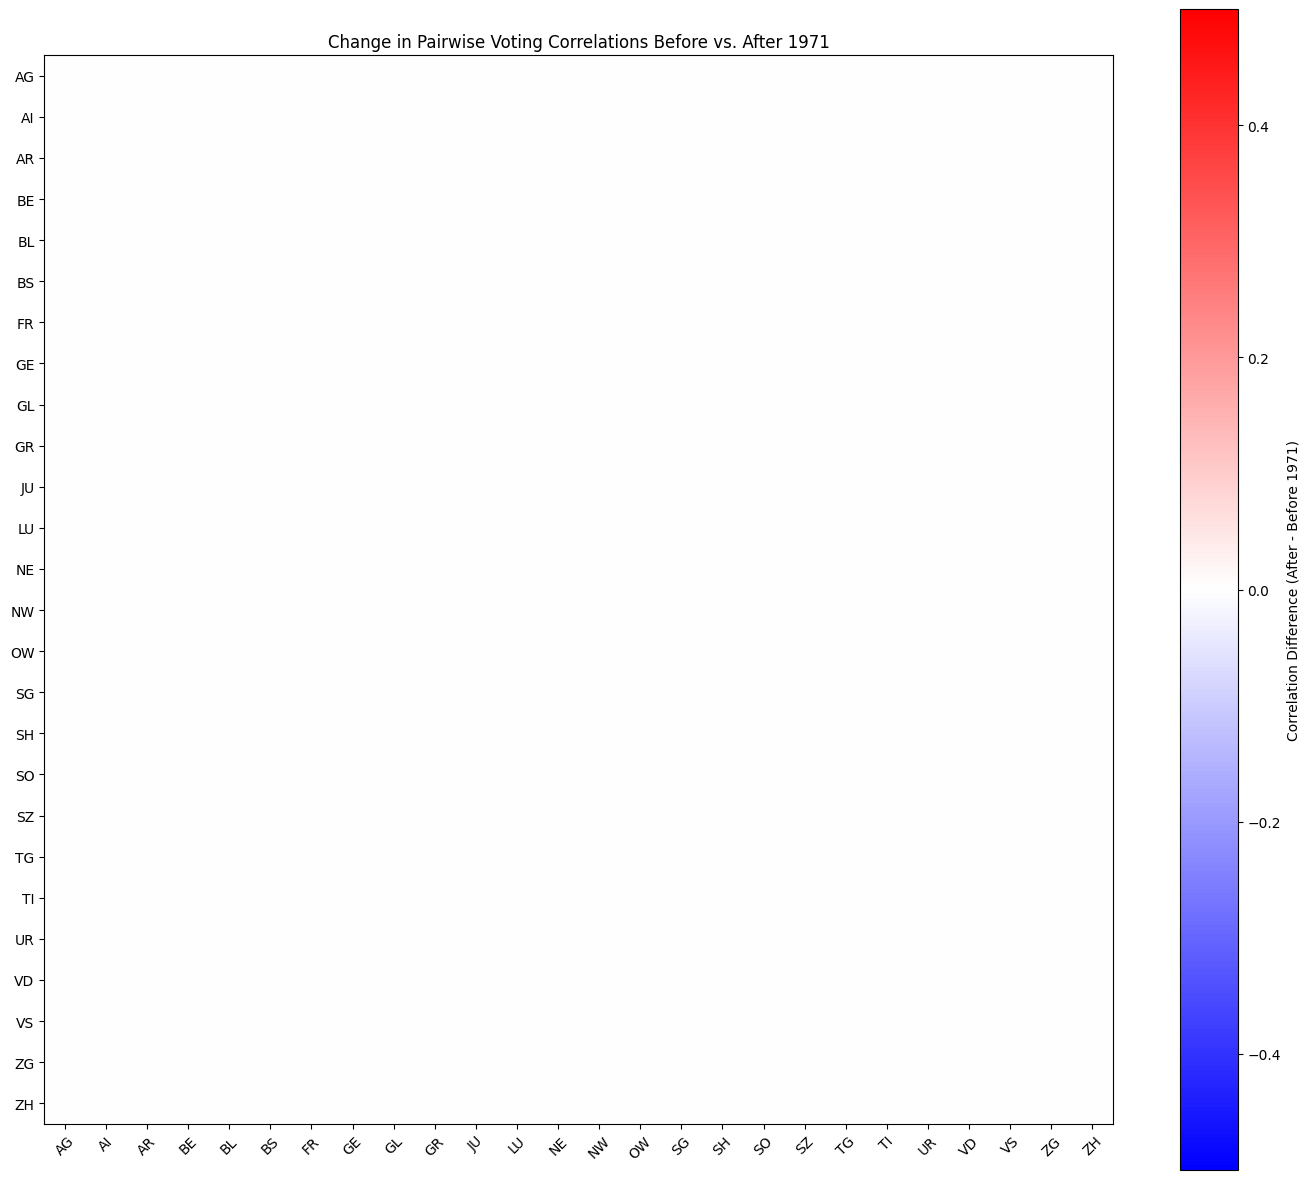

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import requests
import io
import zipfile
import os

# First, let's prepare the data
# Assuming 'df' is your dataframe with the voting data
# We need to extract the canton-level voting data before and after 1971

# First, let's split the data into before and after 1971
init_date = datetime(1971, 2, 7, 0, 0)

# Teile die Daten in Abstimmungen vor und nach der Einführung des Frauenstimmrechts
# Abstimmungen vor 1971 (ohne Frauenstimmrecht)
df_before_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') < init_date]
df_after_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') >= init_date]

# Create a list of all cantons
canton_codes = ['AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 
                'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 
                'TI', 'UR', 'VD', 'VS', 'ZG', 'ZH']

# Function to create a correlation matrix for a given time period
def create_correlation_matrix(data, canton_codes):
    # Create an empty correlation matrix
    corr_matrix = pd.DataFrame(index=canton_codes, columns=canton_codes)
    
    # For each pair of cantons, calculate the correlation of their voting patterns
    for i, canton1 in enumerate(canton_codes):
        for j, canton2 in enumerate(canton_codes):
            if i > j:  # Only calculate for the lower triangle
                continue
                
            # Get the voting data for both cantons
            canton1_col = f"{canton1.lower()}-japroz"
            canton2_col = f"{canton2.lower()}-japroz"
            
            # Check if both columns exist in the dataframe
            if canton1_col in data.columns and canton2_col in data.columns:
                # Get the voting percentages for both cantons
                votes1 = data[canton1_col].dropna()
                votes2 = data[canton2_col].dropna()
                
                # Find common votes (by index)
                common_indices = votes1.index.intersection(votes2.index)
                
                if len(common_indices) > 5:  # Only calculate if there are enough common votes
                    # Calculate correlation
                    correlation = np.corrcoef(
                        votes1.loc[common_indices], 
                        votes2.loc[common_indices]
                    )[0, 1]
                    
                    # Store in the matrix
                    corr_matrix.loc[canton1, canton2] = correlation
                    corr_matrix.loc[canton2, canton1] = correlation
                else:
                    corr_matrix.loc[canton1, canton2] = np.nan
                    corr_matrix.loc[canton2, canton1] = np.nan
            else:
                corr_matrix.loc[canton1, canton2] = np.nan
                corr_matrix.loc[canton2, canton1] = np.nan
                
    # Fill diagonal with 1s
    for canton in canton_codes:
        corr_matrix.loc[canton, canton] = 1.0
        
    return corr_matrix

# Create correlation matrices for both periods
corr_before = create_correlation_matrix(df_before_1971, canton_codes)
corr_after = create_correlation_matrix(df_after_1971, canton_codes)

# Handle the case of Jura (JU) which was created after 1971
if 'JU' in corr_before.index and corr_before.loc['JU'].isna().all():
    corr_before = corr_before.drop('JU', axis=0).drop('JU', axis=1)

# Fill NaN values with the mean of the respective matrix
corr_before = corr_before.fillna(corr_before.mean().mean())
corr_after = corr_after.fillna(corr_after.mean().mean())

# Calculate the difference in correlation patterns
# For each canton, we'll calculate the average correlation with all other cantons
corr_diff = {}
for canton in corr_before.index:
    if canton in corr_after.index:
        # Calculate average correlation with other cantons (excluding self-correlation)
        avg_corr_before = corr_before.loc[canton].drop(canton).mean()
        avg_corr_after = corr_after.loc[canton].drop(canton).mean()
        corr_diff[canton] = avg_corr_after - avg_corr_before

# Download Swiss cantons shapefile if not already available
shapefile_path = 'data/swiss_cantons'
if not os.path.exists(shapefile_path):
    os.makedirs(shapefile_path, exist_ok=True)
    
    # URL for Swiss cantons shapefile (this is an example URL, you may need to find the correct one)
    url = "https://www.swisstopo.admin.ch/content/swisstopo-internet/en/geodata/landscape/boundaries3d/_jcr_content/contentPar/tabs/items/documents_publicatio/tabPar/downloadlist/downloadItems/1_1547207224391.download/BOUNDARIES_2022-01-01_2056_EN.zip"
    
    try:
        print("Downloading Swiss cantons shapefile...")
        response = requests.get(url)
        if response.status_code == 200:
            z = zipfile.ZipFile(io.BytesIO(response.content))
            z.extractall(shapefile_path)
            print("Download and extraction complete.")
        else:
            print(f"Failed to download shapefile: HTTP {response.status_code}")
            raise Exception("Download failed")
    except Exception as e:
        print(f"Error downloading shapefile: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a mask for the upper triangle
        mask = np.triu(np.ones_like(diff_matrix, dtype=bool))
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()
else:
    try:
        # Try to load the shapefile
        shapefile = os.path.join(shapefile_path, 'swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp')
        swiss_map = gpd.read_file(shapefile)
        
        # Map the canton names to match the shapefile
        # This mapping might need adjustment based on your shapefile
        canton_mapping = {
            'AG': 'Aargau', 'AI': 'Appenzell Innerrhoden', 'AR': 'Appenzell Ausserrhoden',
            'BE': 'Bern', 'BL': 'Basel-Landschaft', 'BS': 'Basel-Stadt', 'FR': 'Fribourg',
            'GE': 'Genève', 'GL': 'Glarus', 'GR': 'Graubünden', 'JU': 'Jura', 'LU': 'Luzern',
            'NE': 'Neuchâtel', 'NW': 'Nidwalden', 'OW': 'Obwalden', 'SG': 'St. Gallen',
            'SH': 'Schaffhausen', 'SO': 'Solothurn', 'SZ': 'Schwyz', 'TG': 'Thurgau',
            'TI': 'Ticino', 'UR': 'Uri', 'VD': 'Vaud', 'VS': 'Valais', 'ZG': 'Zug', 'ZH': 'Zürich'
        }
        
        # Create a new column with the correlation differences
        swiss_map['corr_diff'] = swiss_map['NAME'].map(
            lambda x: corr_diff.get(next((k for k, v in canton_mapping.items() if v == x), None), 0)
        )
        
        # Create a custom colormap: blue for negative, white for zero, red for positive
        colors = ['blue', 'white', 'red']
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', colors, N=256)
        
        # Plot the map
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        
        # Find the maximum absolute value for symmetric color scaling
        vmax = max(abs(min(corr_diff.values())), abs(max(corr_diff.values())))
        
        swiss_map.plot(
            column='corr_diff',
            cmap=cmap,
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            vmin=-vmax,
            vmax=vmax,
            legend=True,
            legend_kwds={'label': 'Correlation Difference (After - Before 1971)'}
        )
        
        # Add canton labels
        for idx, row in swiss_map.iterrows():
            plt.annotate(text=row['NAME'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                        horizontalalignment='center', fontsize=8)
        
        plt.title('Change in Voting Correlation Patterns Before vs. After 1971')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating map: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()

C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_before = corr_before.fillna(corr_before.mean().mean())
C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:86: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_after = corr_after.fillna(corr_after.mean().mean())


Error downloading shapefile: File is not a zip file
Creating a simple visualization without the map...


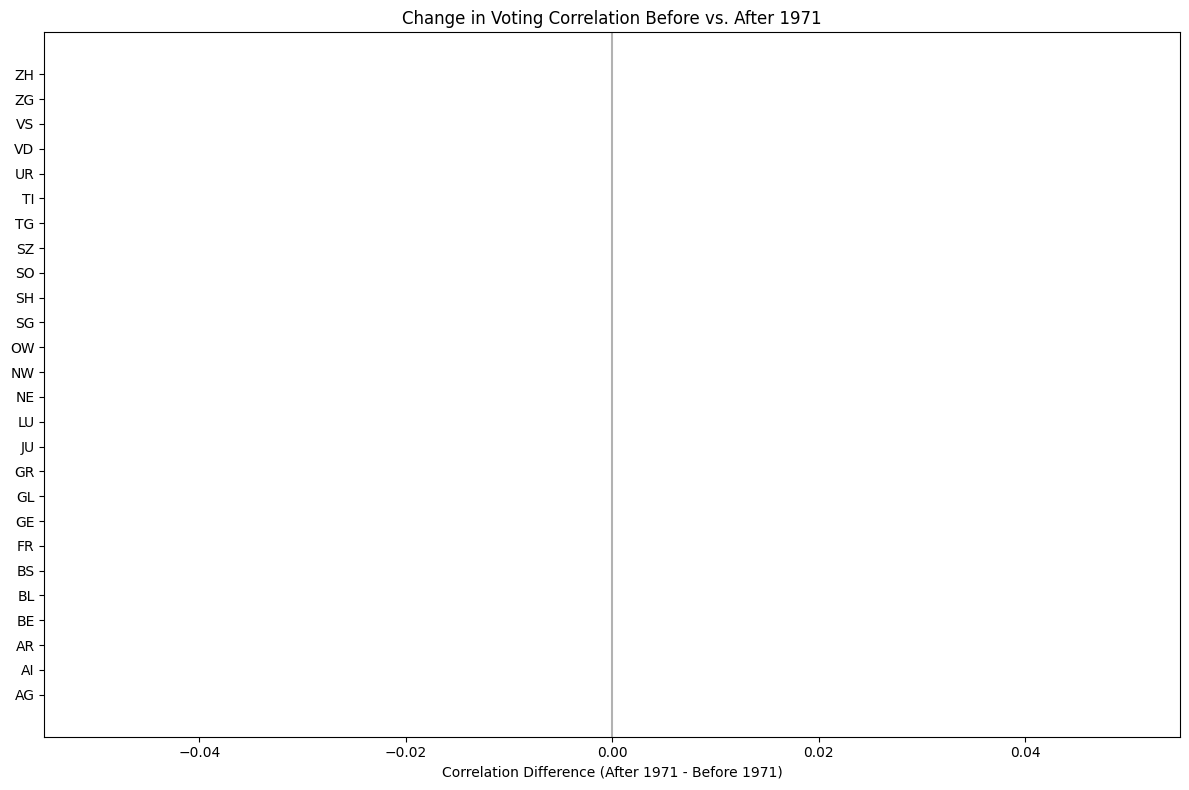

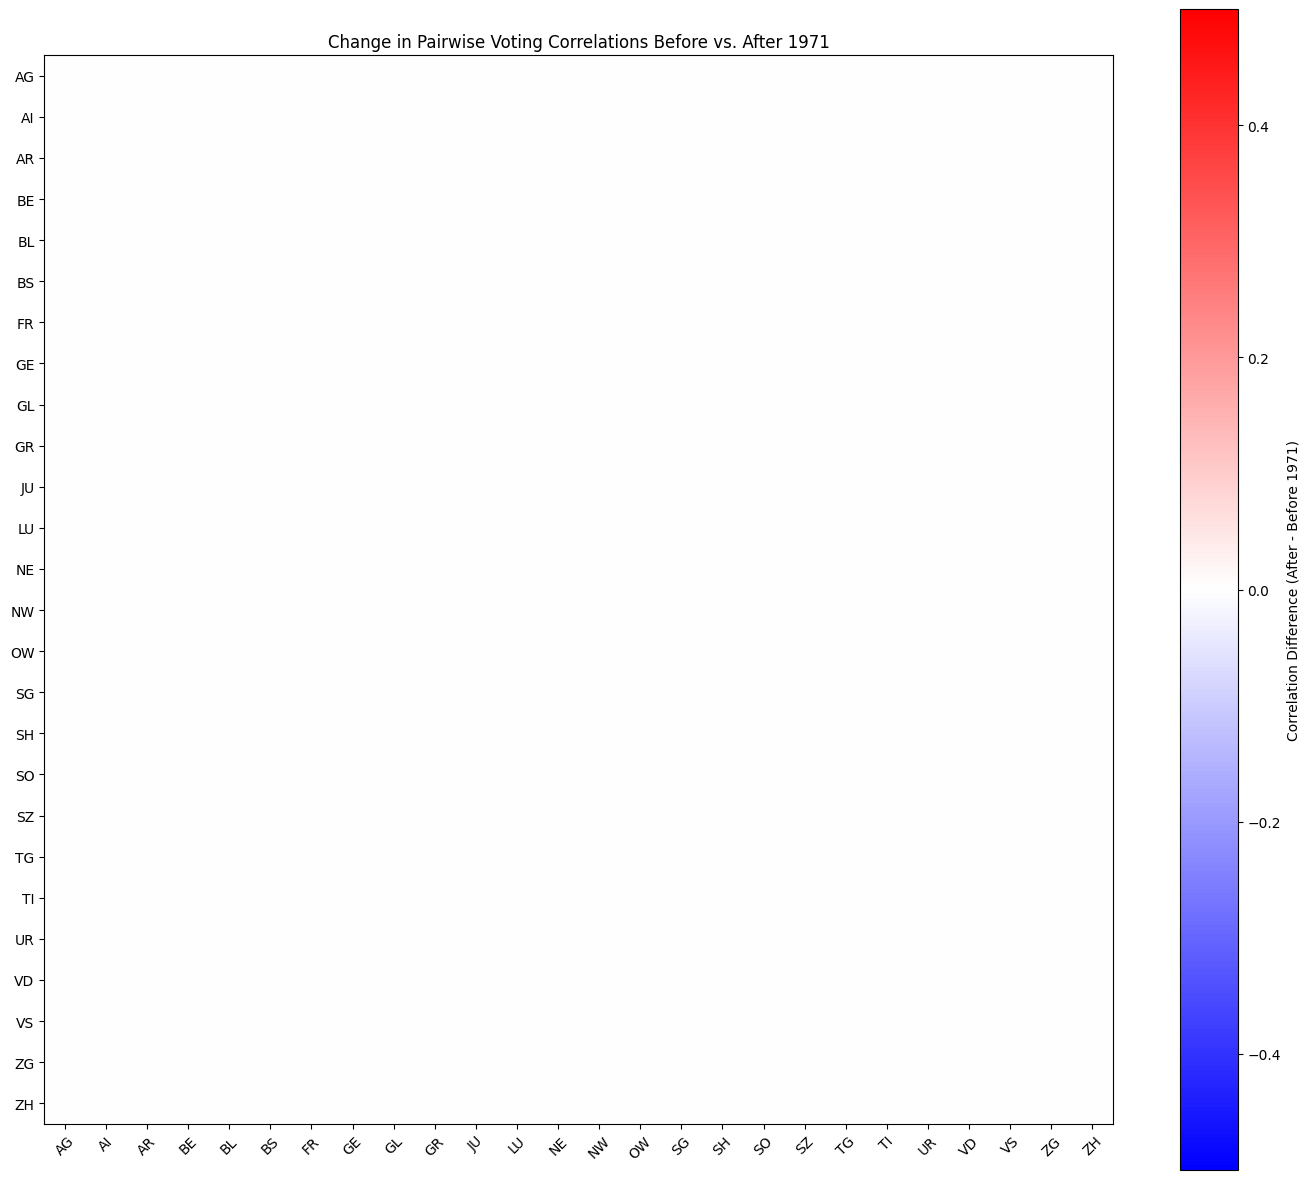

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import requests
import io
import zipfile
import os

# First, let's prepare the data
# Assuming 'df' is your dataframe with the voting data
# We need to extract the canton-level voting data before and after 1971

# First, let's split the data into before and after 1971
init_date = datetime(1971, 2, 7, 0, 0)

# Teile die Daten in Abstimmungen vor und nach der Einführung des Frauenstimmrechts
# Abstimmungen vor 1971 (ohne Frauenstimmrecht)
df_before_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') < init_date]
df_after_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') >= init_date]

# Create a list of all cantons
canton_codes = ['AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 
                'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 
                'TI', 'UR', 'VD', 'VS', 'ZG', 'ZH']

# Function to create a correlation matrix for a given time period
def create_correlation_matrix(data, canton_codes):
    # Create an empty correlation matrix
    corr_matrix = pd.DataFrame(index=canton_codes, columns=canton_codes)
    
    # For each pair of cantons, calculate the correlation of their voting patterns
    for i, canton1 in enumerate(canton_codes):
        for j, canton2 in enumerate(canton_codes):
            if i > j:  # Only calculate for the lower triangle
                continue
                
            # Get the voting data for both cantons
            canton1_col = f"{canton1.lower()}-japroz"
            canton2_col = f"{canton2.lower()}-japroz"
            
            # Check if both columns exist in the dataframe
            if canton1_col in data.columns and canton2_col in data.columns:
                # Get the voting percentages for both cantons
                votes1 = data[canton1_col].dropna()
                votes2 = data[canton2_col].dropna()
                
                # Find common votes (by index)
                common_indices = votes1.index.intersection(votes2.index)
                
                if len(common_indices) > 5:  # Only calculate if there are enough common votes
                    # Calculate correlation
                    correlation = np.corrcoef(
                        votes1.loc[common_indices], 
                        votes2.loc[common_indices]
                    )[0, 1]
                    
                    # Store in the matrix
                    corr_matrix.loc[canton1, canton2] = correlation
                    corr_matrix.loc[canton2, canton1] = correlation
                else:
                    corr_matrix.loc[canton1, canton2] = np.nan
                    corr_matrix.loc[canton2, canton1] = np.nan
            else:
                corr_matrix.loc[canton1, canton2] = np.nan
                corr_matrix.loc[canton2, canton1] = np.nan
                
    # Fill diagonal with 1s
    for canton in canton_codes:
        corr_matrix.loc[canton, canton] = 1.0
        
    return corr_matrix

# Create correlation matrices for both periods
corr_before = create_correlation_matrix(df_before_1971, canton_codes)
corr_after = create_correlation_matrix(df_after_1971, canton_codes)

# Handle the case of Jura (JU) which was created after 1971
if 'JU' in corr_before.index and corr_before.loc['JU'].isna().all():
    corr_before = corr_before.drop('JU', axis=0).drop('JU', axis=1)

# Fill NaN values with the mean of the respective matrix
corr_before = corr_before.fillna(corr_before.mean().mean())
corr_after = corr_after.fillna(corr_after.mean().mean())

# Calculate the difference in correlation patterns
# For each canton, we'll calculate the average correlation with all other cantons
corr_diff = {}
for canton in corr_before.index:
    if canton in corr_after.index:
        # Calculate average correlation with other cantons (excluding self-correlation)
        avg_corr_before = corr_before.loc[canton].drop(canton).mean()
        avg_corr_after = corr_after.loc[canton].drop(canton).mean()
        corr_diff[canton] = avg_corr_after - avg_corr_before

# Download Swiss cantons shapefile if not already available
shapefile_path = 'data/swiss_cantons'
if not os.path.exists(shapefile_path):
    os.makedirs(shapefile_path, exist_ok=True)
    
    # URL for Swiss cantons shapefile (this is an example URL, you may need to find the correct one)
    url = "https://www.swisstopo.admin.ch/content/swisstopo-internet/en/geodata/landscape/boundaries3d/_jcr_content/contentPar/tabs/items/documents_publicatio/tabPar/downloadlist/downloadItems/1_1547207224391.download/BOUNDARIES_2022-01-01_2056_EN.zip"
    
    try:
        print("Downloading Swiss cantons shapefile...")
        response = requests.get(url)
        if response.status_code == 200:
            z = zipfile.ZipFile(io.BytesIO(response.content))
            z.extractall(shapefile_path)
            print("Download and extraction complete.")
        else:
            print(f"Failed to download shapefile: HTTP {response.status_code}")
            raise Exception("Download failed")
    except Exception as e:
        print(f"Error downloading shapefile: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a mask for the upper triangle
        mask = np.triu(np.ones_like(diff_matrix, dtype=bool))
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()
else:
    try:
        # Try to load the shapefile
        shapefile = os.path.join(shapefile_path, 'swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp')
        swiss_map = gpd.read_file(shapefile)
        
        # Map the canton names to match the shapefile
        # This mapping might need adjustment based on your shapefile
        canton_mapping = {
            'AG': 'Aargau', 'AI': 'Appenzell Innerrhoden', 'AR': 'Appenzell Ausserrhoden',
            'BE': 'Bern', 'BL': 'Basel-Landschaft', 'BS': 'Basel-Stadt', 'FR': 'Fribourg',
            'GE': 'Genève', 'GL': 'Glarus', 'GR': 'Graubünden', 'JU': 'Jura', 'LU': 'Luzern',
            'NE': 'Neuchâtel', 'NW': 'Nidwalden', 'OW': 'Obwalden', 'SG': 'St. Gallen',
            'SH': 'Schaffhausen', 'SO': 'Solothurn', 'SZ': 'Schwyz', 'TG': 'Thurgau',
            'TI': 'Ticino', 'UR': 'Uri', 'VD': 'Vaud', 'VS': 'Valais', 'ZG': 'Zug', 'ZH': 'Zürich'
        }
        
        # Create a new column with the correlation differences
        swiss_map['corr_diff'] = swiss_map['NAME'].map(
            lambda x: corr_diff.get(next((k for k, v in canton_mapping.items() if v == x), None), 0)
        )
        
        # Create a custom colormap: blue for negative, white for zero, red for positive
        colors = ['blue', 'white', 'red']
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', colors, N=256)
        
        # Plot the map
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        
        # Find the maximum absolute value for symmetric color scaling
        vmax = max(abs(min(corr_diff.values())), abs(max(corr_diff.values())))
        
        swiss_map.plot(
            column='corr_diff',
            cmap=cmap,
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            vmin=-vmax,
            vmax=vmax,
            legend=True,
            legend_kwds={'label': 'Correlation Difference (After - Before 1971)'}
        )
        
        # Add canton labels
        for idx, row in swiss_map.iterrows():
            plt.annotate(text=row['NAME'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                        horizontalalignment='center', fontsize=8)
        
        plt.title('Change in Voting Correlation Patterns Before vs. After 1971')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating map: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()

C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_before = corr_before.fillna(corr_before.mean().mean())
C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:86: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_after = corr_after.fillna(corr_after.mean().mean())


Error downloading shapefile: File is not a zip file
Creating a simple visualization without the map...


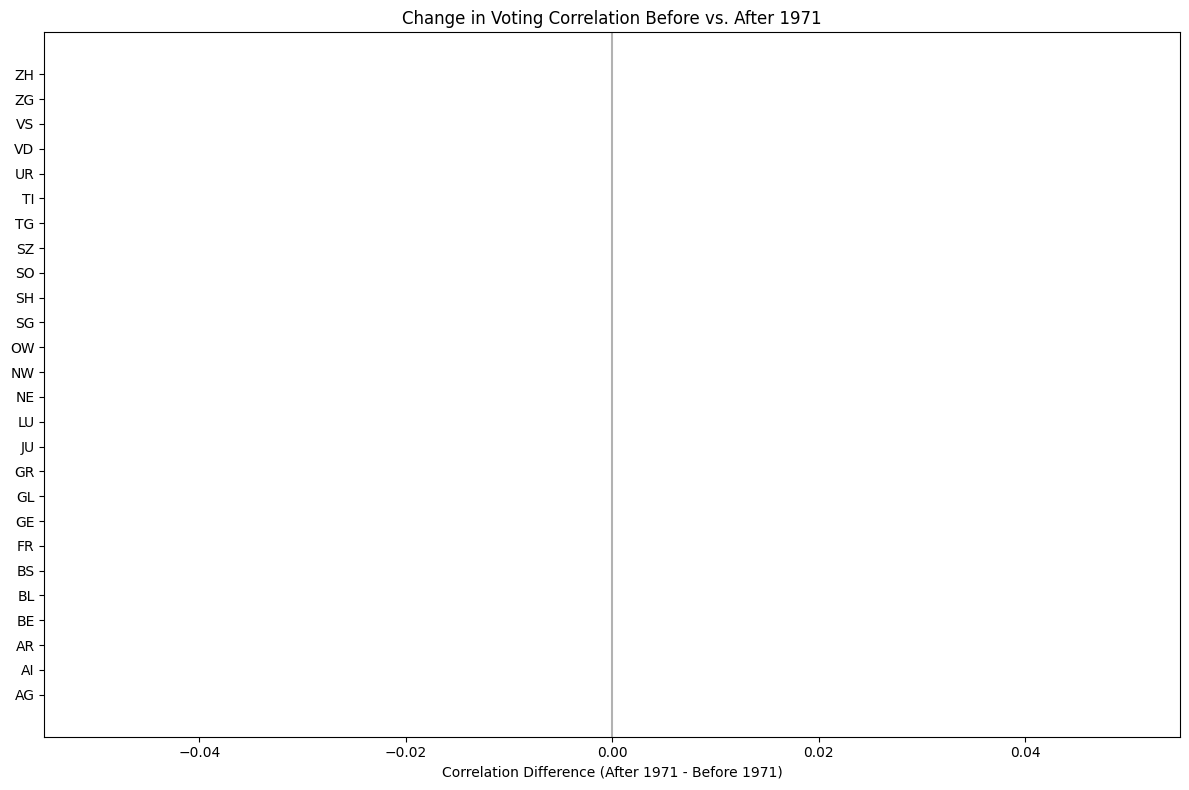

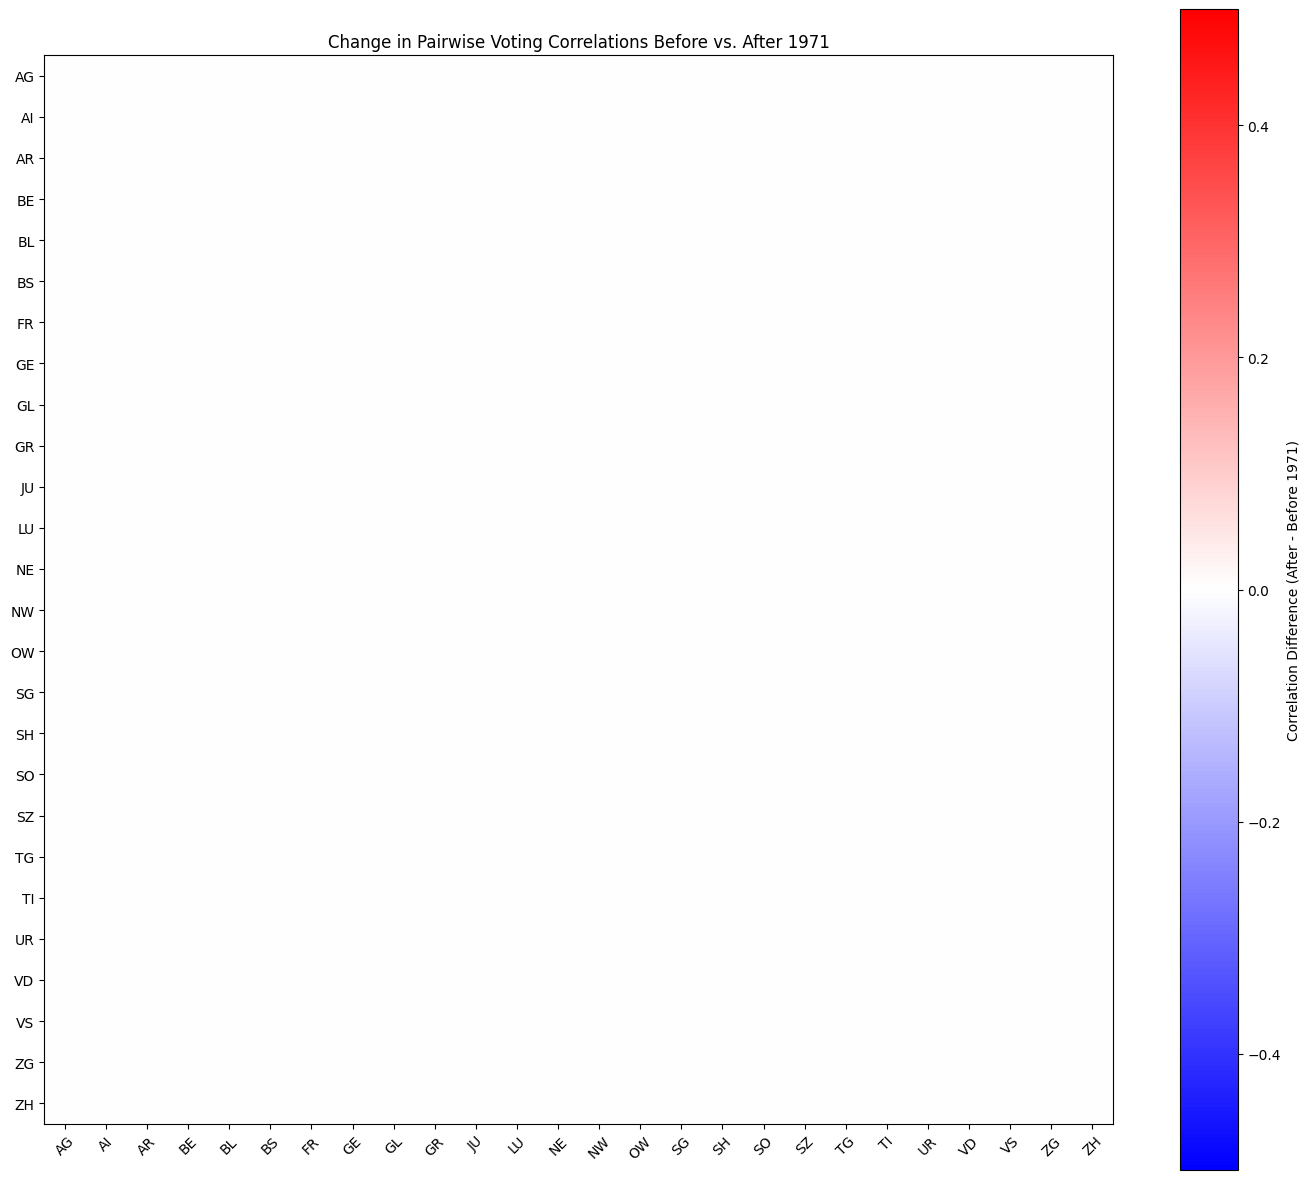

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import requests
import io
import zipfile
import os

# First, let's prepare the data
# Assuming 'df' is your dataframe with the voting data
# We need to extract the canton-level voting data before and after 1971

# First, let's split the data into before and after 1971
init_date = datetime(1971, 2, 7, 0, 0)

# Teile die Daten in Abstimmungen vor und nach der Einführung des Frauenstimmrechts
# Abstimmungen vor 1971 (ohne Frauenstimmrecht)
df_before_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') < init_date]
df_after_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') >= init_date]

# Create a list of all cantons
canton_codes = ['AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 
                'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 
                'TI', 'UR', 'VD', 'VS', 'ZG', 'ZH']

# Function to create a correlation matrix for a given time period
def create_correlation_matrix(data, canton_codes):
    # Create an empty correlation matrix
    corr_matrix = pd.DataFrame(index=canton_codes, columns=canton_codes)
    
    # For each pair of cantons, calculate the correlation of their voting patterns
    for i, canton1 in enumerate(canton_codes):
        for j, canton2 in enumerate(canton_codes):
            if i > j:  # Only calculate for the lower triangle
                continue
                
            # Get the voting data for both cantons
            canton1_col = f"{canton1.lower()}-japroz"
            canton2_col = f"{canton2.lower()}-japroz"
            
            # Check if both columns exist in the dataframe
            if canton1_col in data.columns and canton2_col in data.columns:
                # Get the voting percentages for both cantons
                votes1 = data[canton1_col].dropna()
                votes2 = data[canton2_col].dropna()
                
                # Find common votes (by index)
                common_indices = votes1.index.intersection(votes2.index)
                
                if len(common_indices) > 5:  # Only calculate if there are enough common votes
                    # Calculate correlation
                    correlation = np.corrcoef(
                        votes1.loc[common_indices], 
                        votes2.loc[common_indices]
                    )[0, 1]
                    
                    # Store in the matrix
                    corr_matrix.loc[canton1, canton2] = correlation
                    corr_matrix.loc[canton2, canton1] = correlation
                else:
                    corr_matrix.loc[canton1, canton2] = np.nan
                    corr_matrix.loc[canton2, canton1] = np.nan
            else:
                corr_matrix.loc[canton1, canton2] = np.nan
                corr_matrix.loc[canton2, canton1] = np.nan
                
    # Fill diagonal with 1s
    for canton in canton_codes:
        corr_matrix.loc[canton, canton] = 1.0
        
    return corr_matrix

# Create correlation matrices for both periods
corr_before = create_correlation_matrix(df_before_1971, canton_codes)
corr_after = create_correlation_matrix(df_after_1971, canton_codes)

# Handle the case of Jura (JU) which was created after 1971
if 'JU' in corr_before.index and corr_before.loc['JU'].isna().all():
    corr_before = corr_before.drop('JU', axis=0).drop('JU', axis=1)

# Fill NaN values with the mean of the respective matrix
corr_before = corr_before.fillna(corr_before.mean().mean())
corr_after = corr_after.fillna(corr_after.mean().mean())

# Calculate the difference in correlation patterns
# For each canton, we'll calculate the average correlation with all other cantons
corr_diff = {}
for canton in corr_before.index:
    if canton in corr_after.index:
        # Calculate average correlation with other cantons (excluding self-correlation)
        avg_corr_before = corr_before.loc[canton].drop(canton).mean()
        avg_corr_after = corr_after.loc[canton].drop(canton).mean()
        corr_diff[canton] = avg_corr_after - avg_corr_before

# Download Swiss cantons shapefile if not already available
shapefile_path = 'data/swiss_cantons'
if not os.path.exists(shapefile_path):
    os.makedirs(shapefile_path, exist_ok=True)
    
    # URL for Swiss cantons shapefile (this is an example URL, you may need to find the correct one)
    url = "https://www.swisstopo.admin.ch/content/swisstopo-internet/en/geodata/landscape/boundaries3d/_jcr_content/contentPar/tabs/items/documents_publicatio/tabPar/downloadlist/downloadItems/1_1547207224391.download/BOUNDARIES_2022-01-01_2056_EN.zip"
    
    try:
        print("Downloading Swiss cantons shapefile...")
        response = requests.get(url)
        if response.status_code == 200:
            z = zipfile.ZipFile(io.BytesIO(response.content))
            z.extractall(shapefile_path)
            print("Download and extraction complete.")
        else:
            print(f"Failed to download shapefile: HTTP {response.status_code}")
            raise Exception("Download failed")
    except Exception as e:
        print(f"Error downloading shapefile: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a mask for the upper triangle
        mask = np.triu(np.ones_like(diff_matrix, dtype=bool))
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()
else:
    try:
        # Try to load the shapefile
        shapefile = os.path.join(shapefile_path, 'swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp')
        swiss_map = gpd.read_file(shapefile)
        
        # Map the canton names to match the shapefile
        # This mapping might need adjustment based on your shapefile
        canton_mapping = {
            'AG': 'Aargau', 'AI': 'Appenzell Innerrhoden', 'AR': 'Appenzell Ausserrhoden',
            'BE': 'Bern', 'BL': 'Basel-Landschaft', 'BS': 'Basel-Stadt', 'FR': 'Fribourg',
            'GE': 'Genève', 'GL': 'Glarus', 'GR': 'Graubünden', 'JU': 'Jura', 'LU': 'Luzern',
            'NE': 'Neuchâtel', 'NW': 'Nidwalden', 'OW': 'Obwalden', 'SG': 'St. Gallen',
            'SH': 'Schaffhausen', 'SO': 'Solothurn', 'SZ': 'Schwyz', 'TG': 'Thurgau',
            'TI': 'Ticino', 'UR': 'Uri', 'VD': 'Vaud', 'VS': 'Valais', 'ZG': 'Zug', 'ZH': 'Zürich'
        }
        
        # Create a new column with the correlation differences
        swiss_map['corr_diff'] = swiss_map['NAME'].map(
            lambda x: corr_diff.get(next((k for k, v in canton_mapping.items() if v == x), None), 0)
        )
        
        # Create a custom colormap: blue for negative, white for zero, red for positive
        colors = ['blue', 'white', 'red']
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', colors, N=256)
        
        # Plot the map
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        
        # Find the maximum absolute value for symmetric color scaling
        vmax = max(abs(min(corr_diff.values())), abs(max(corr_diff.values())))
        
        swiss_map.plot(
            column='corr_diff',
            cmap=cmap,
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            vmin=-vmax,
            vmax=vmax,
            legend=True,
            legend_kwds={'label': 'Correlation Difference (After - Before 1971)'}
        )
        
        # Add canton labels
        for idx, row in swiss_map.iterrows():
            plt.annotate(text=row['NAME'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                        horizontalalignment='center', fontsize=8)
        
        plt.title('Change in Voting Correlation Patterns Before vs. After 1971')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating map: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()

C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_before = corr_before.fillna(corr_before.mean().mean())
C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:86: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_after = corr_after.fillna(corr_after.mean().mean())


Error downloading shapefile: File is not a zip file
Creating a simple visualization without the map...


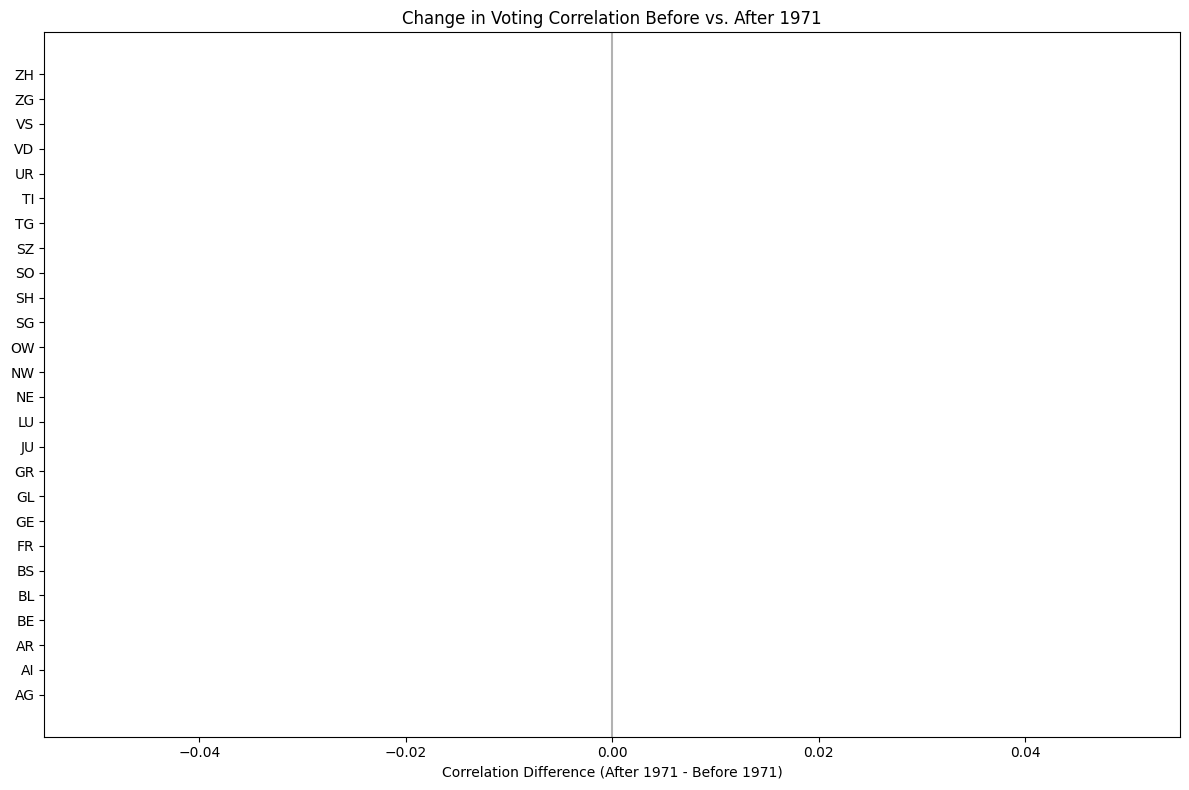

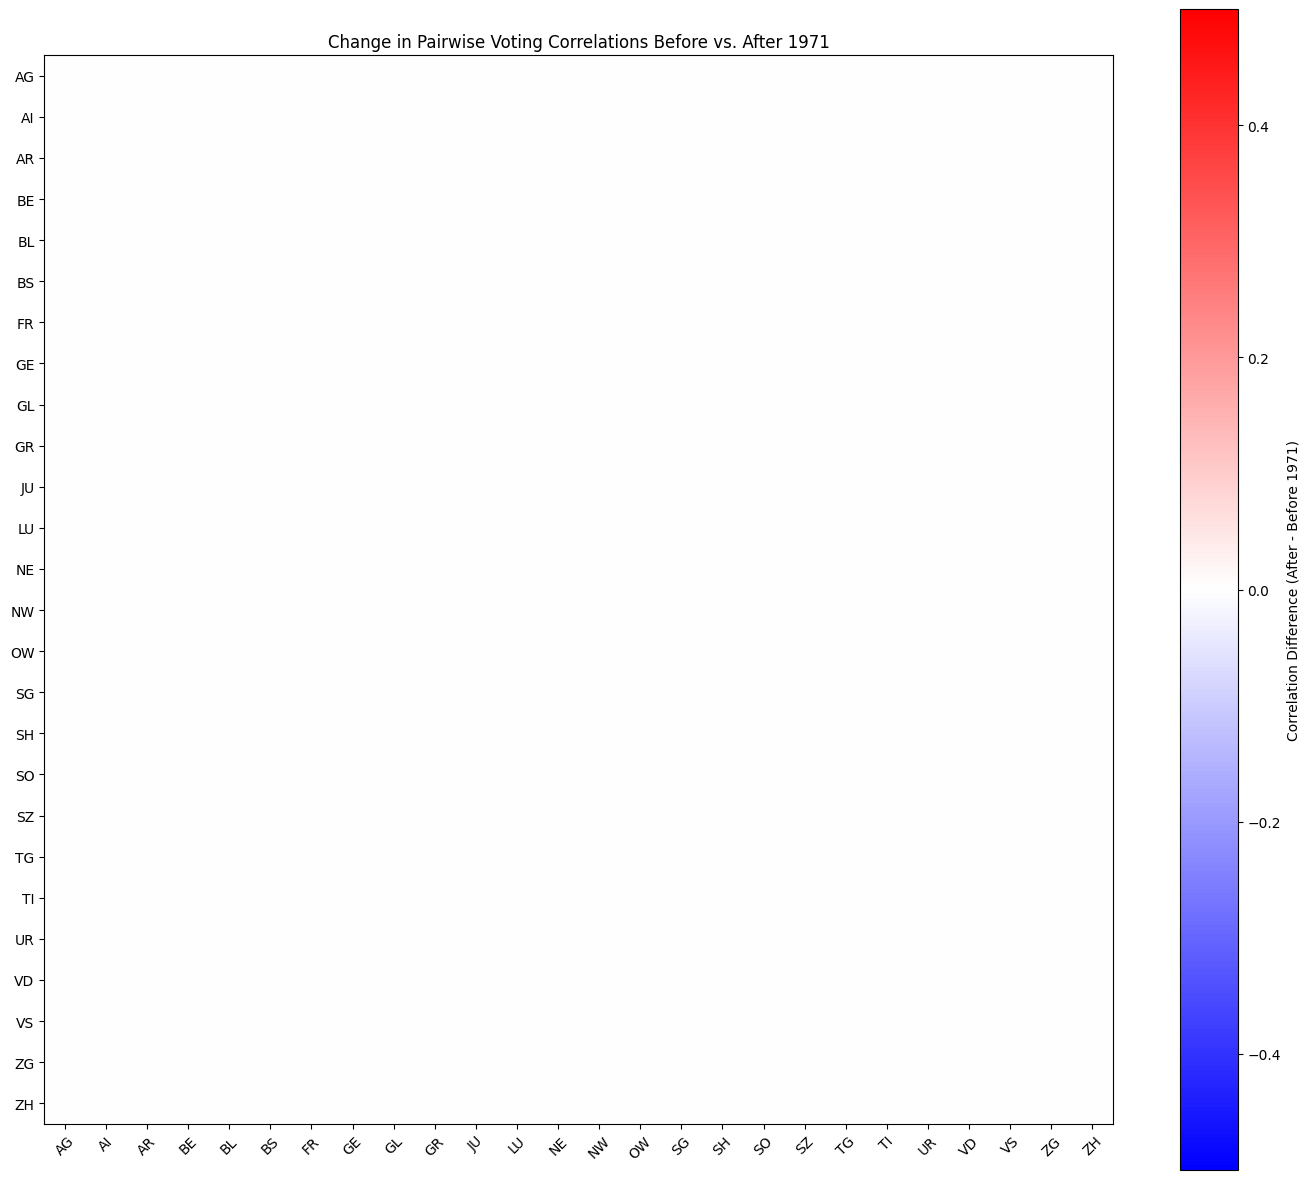

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import requests
import io
import zipfile
import os

# First, let's prepare the data
# Assuming 'df' is your dataframe with the voting data
# We need to extract the canton-level voting data before and after 1971

# First, let's split the data into before and after 1971
init_date = datetime(1971, 2, 7, 0, 0)

# Teile die Daten in Abstimmungen vor und nach der Einführung des Frauenstimmrechts
# Abstimmungen vor 1971 (ohne Frauenstimmrecht)
df_before_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') < init_date]
df_after_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') >= init_date]

# Create a list of all cantons
canton_codes = ['AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 
                'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 
                'TI', 'UR', 'VD', 'VS', 'ZG', 'ZH']

# Function to create a correlation matrix for a given time period
def create_correlation_matrix(data, canton_codes):
    # Create an empty correlation matrix
    corr_matrix = pd.DataFrame(index=canton_codes, columns=canton_codes)
    
    # For each pair of cantons, calculate the correlation of their voting patterns
    for i, canton1 in enumerate(canton_codes):
        for j, canton2 in enumerate(canton_codes):
            if i > j:  # Only calculate for the lower triangle
                continue
                
            # Get the voting data for both cantons
            canton1_col = f"{canton1.lower()}-japroz"
            canton2_col = f"{canton2.lower()}-japroz"
            
            # Check if both columns exist in the dataframe
            if canton1_col in data.columns and canton2_col in data.columns:
                # Get the voting percentages for both cantons
                votes1 = data[canton1_col].dropna()
                votes2 = data[canton2_col].dropna()
                
                # Find common votes (by index)
                common_indices = votes1.index.intersection(votes2.index)
                
                if len(common_indices) > 5:  # Only calculate if there are enough common votes
                    # Calculate correlation
                    correlation = np.corrcoef(
                        votes1.loc[common_indices], 
                        votes2.loc[common_indices]
                    )[0, 1]
                    
                    # Store in the matrix
                    corr_matrix.loc[canton1, canton2] = correlation
                    corr_matrix.loc[canton2, canton1] = correlation
                else:
                    corr_matrix.loc[canton1, canton2] = np.nan
                    corr_matrix.loc[canton2, canton1] = np.nan
            else:
                corr_matrix.loc[canton1, canton2] = np.nan
                corr_matrix.loc[canton2, canton1] = np.nan
                
    # Fill diagonal with 1s
    for canton in canton_codes:
        corr_matrix.loc[canton, canton] = 1.0
        
    return corr_matrix

# Create correlation matrices for both periods
corr_before = create_correlation_matrix(df_before_1971, canton_codes)
corr_after = create_correlation_matrix(df_after_1971, canton_codes)

# Handle the case of Jura (JU) which was created after 1971
if 'JU' in corr_before.index and corr_before.loc['JU'].isna().all():
    corr_before = corr_before.drop('JU', axis=0).drop('JU', axis=1)

# Fill NaN values with the mean of the respective matrix
corr_before = corr_before.fillna(corr_before.mean().mean())
corr_after = corr_after.fillna(corr_after.mean().mean())

# Calculate the difference in correlation patterns
# For each canton, we'll calculate the average correlation with all other cantons
corr_diff = {}
for canton in corr_before.index:
    if canton in corr_after.index:
        # Calculate average correlation with other cantons (excluding self-correlation)
        avg_corr_before = corr_before.loc[canton].drop(canton).mean()
        avg_corr_after = corr_after.loc[canton].drop(canton).mean()
        corr_diff[canton] = avg_corr_after - avg_corr_before

# Download Swiss cantons shapefile if not already available
shapefile_path = 'data/swiss_cantons'
if not os.path.exists(shapefile_path):
    os.makedirs(shapefile_path, exist_ok=True)
    
    # URL for Swiss cantons shapefile (this is an example URL, you may need to find the correct one)
    url = "https://www.swisstopo.admin.ch/content/swisstopo-internet/en/geodata/landscape/boundaries3d/_jcr_content/contentPar/tabs/items/documents_publicatio/tabPar/downloadlist/downloadItems/1_1547207224391.download/BOUNDARIES_2022-01-01_2056_EN.zip"
    
    try:
        print("Downloading Swiss cantons shapefile...")
        response = requests.get(url)
        if response.status_code == 200:
            z = zipfile.ZipFile(io.BytesIO(response.content))
            z.extractall(shapefile_path)
            print("Download and extraction complete.")
        else:
            print(f"Failed to download shapefile: HTTP {response.status_code}")
            raise Exception("Download failed")
    except Exception as e:
        print(f"Error downloading shapefile: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a mask for the upper triangle
        mask = np.triu(np.ones_like(diff_matrix, dtype=bool))
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()
else:
    try:
        # Try to load the shapefile
        shapefile = os.path.join(shapefile_path, 'swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp')
        swiss_map = gpd.read_file(shapefile)
        
        # Map the canton names to match the shapefile
        # This mapping might need adjustment based on your shapefile
        canton_mapping = {
            'AG': 'Aargau', 'AI': 'Appenzell Innerrhoden', 'AR': 'Appenzell Ausserrhoden',
            'BE': 'Bern', 'BL': 'Basel-Landschaft', 'BS': 'Basel-Stadt', 'FR': 'Fribourg',
            'GE': 'Genève', 'GL': 'Glarus', 'GR': 'Graubünden', 'JU': 'Jura', 'LU': 'Luzern',
            'NE': 'Neuchâtel', 'NW': 'Nidwalden', 'OW': 'Obwalden', 'SG': 'St. Gallen',
            'SH': 'Schaffhausen', 'SO': 'Solothurn', 'SZ': 'Schwyz', 'TG': 'Thurgau',
            'TI': 'Ticino', 'UR': 'Uri', 'VD': 'Vaud', 'VS': 'Valais', 'ZG': 'Zug', 'ZH': 'Zürich'
        }
        
        # Create a new column with the correlation differences
        swiss_map['corr_diff'] = swiss_map['NAME'].map(
            lambda x: corr_diff.get(next((k for k, v in canton_mapping.items() if v == x), None), 0)
        )
        
        # Create a custom colormap: blue for negative, white for zero, red for positive
        colors = ['blue', 'white', 'red']
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', colors, N=256)
        
        # Plot the map
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        
        # Find the maximum absolute value for symmetric color scaling
        vmax = max(abs(min(corr_diff.values())), abs(max(corr_diff.values())))
        
        swiss_map.plot(
            column='corr_diff',
            cmap=cmap,
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            vmin=-vmax,
            vmax=vmax,
            legend=True,
            legend_kwds={'label': 'Correlation Difference (After - Before 1971)'}
        )
        
        # Add canton labels
        for idx, row in swiss_map.iterrows():
            plt.annotate(text=row['NAME'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                        horizontalalignment='center', fontsize=8)
        
        plt.title('Change in Voting Correlation Patterns Before vs. After 1971')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating map: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()

C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_before = corr_before.fillna(corr_before.mean().mean())
C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:86: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_after = corr_after.fillna(corr_after.mean().mean())


Error downloading shapefile: File is not a zip file
Creating a simple visualization without the map...


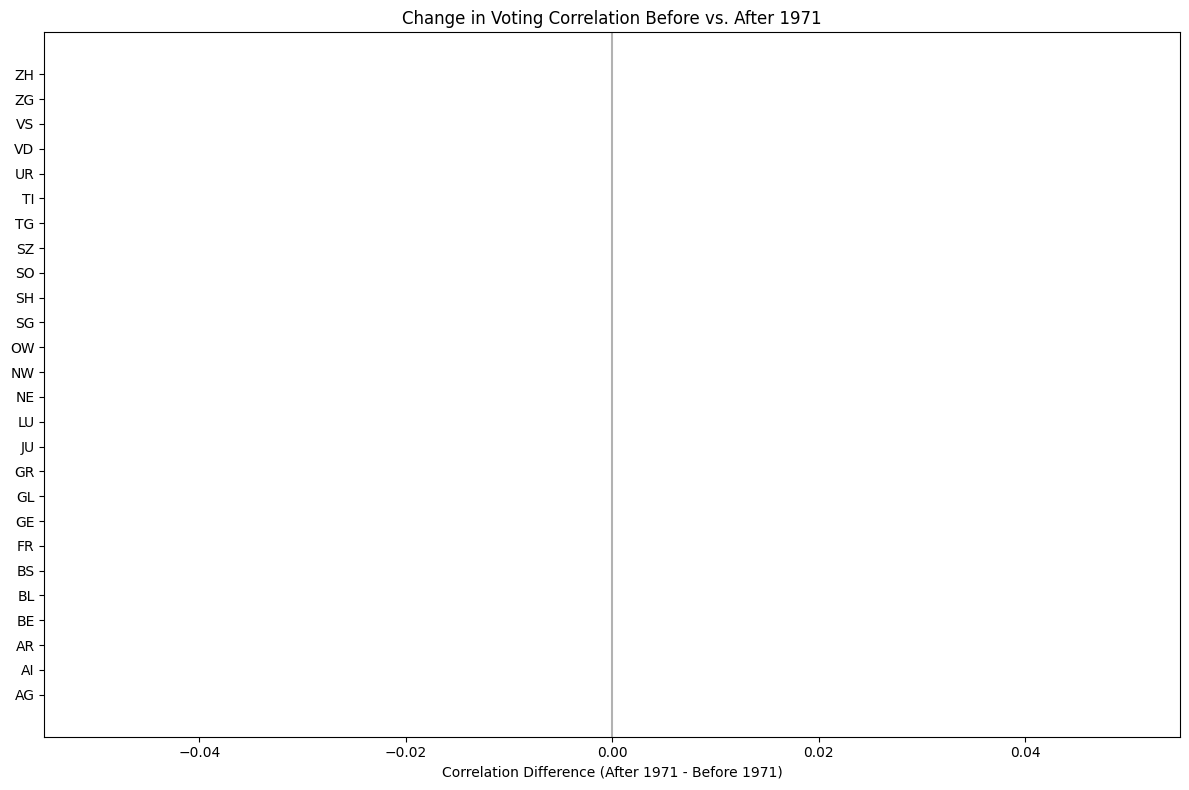

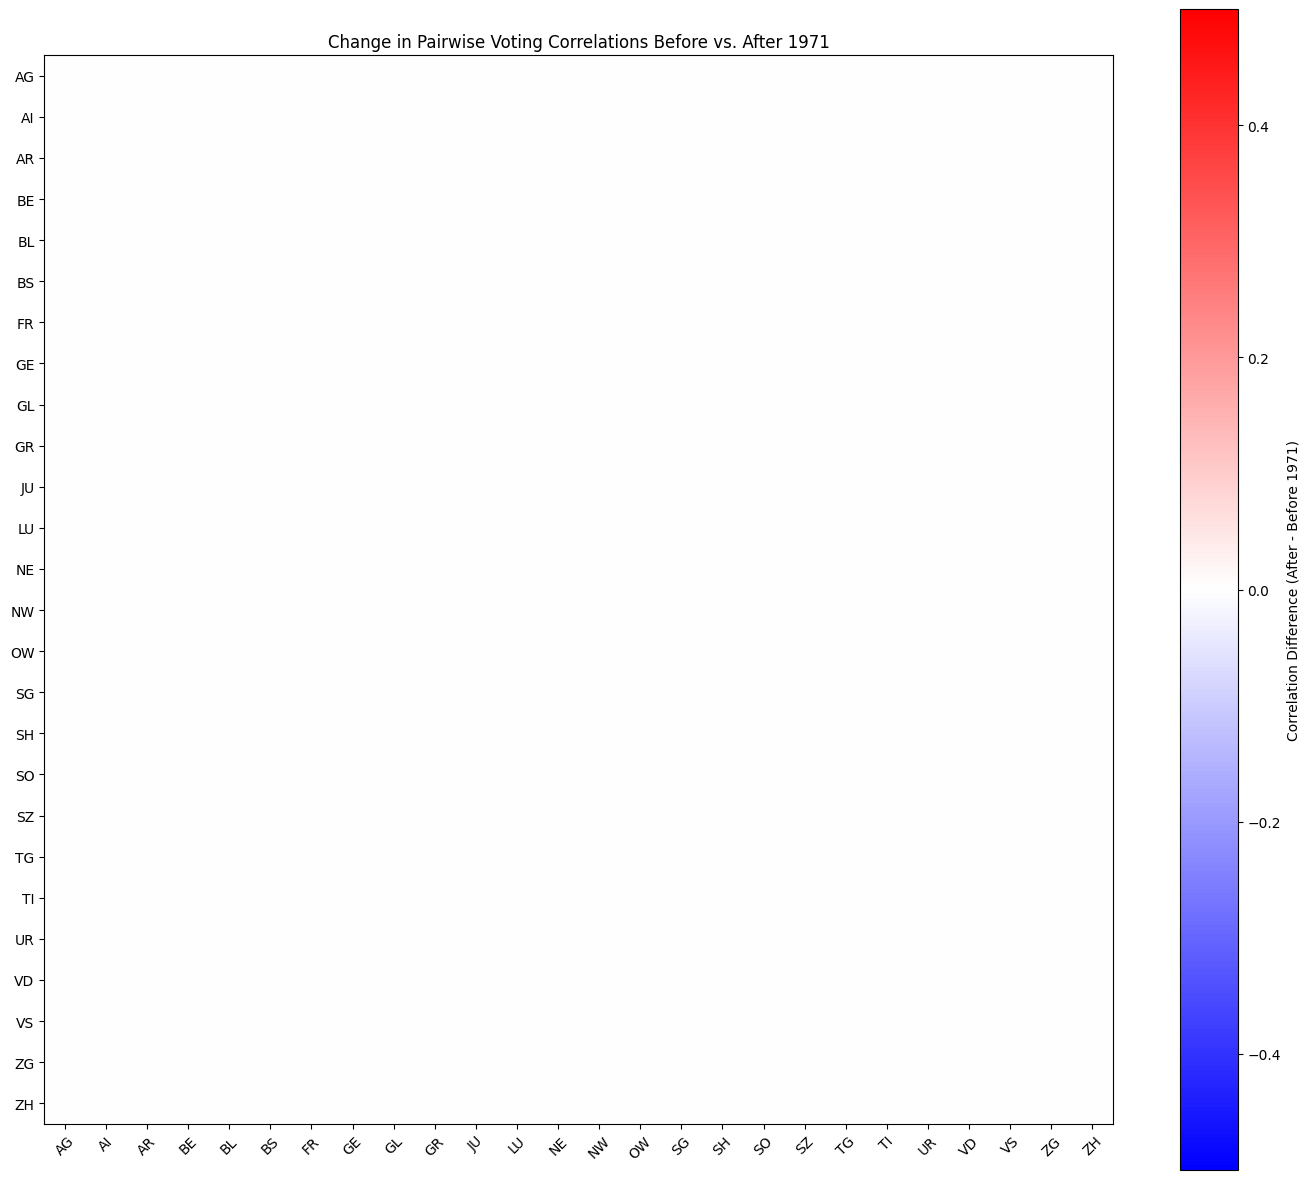

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import requests
import io
import zipfile
import os

# First, let's prepare the data
# Assuming 'df' is your dataframe with the voting data
# We need to extract the canton-level voting data before and after 1971

# First, let's split the data into before and after 1971
init_date = datetime(1971, 2, 7, 0, 0)

# Teile die Daten in Abstimmungen vor und nach der Einführung des Frauenstimmrechts
# Abstimmungen vor 1971 (ohne Frauenstimmrecht)
df_before_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') < init_date]
df_after_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') >= init_date]

# Create a list of all cantons
canton_codes = ['AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 
                'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 
                'TI', 'UR', 'VD', 'VS', 'ZG', 'ZH']

# Function to create a correlation matrix for a given time period
def create_correlation_matrix(data, canton_codes):
    # Create an empty correlation matrix
    corr_matrix = pd.DataFrame(index=canton_codes, columns=canton_codes)
    
    # For each pair of cantons, calculate the correlation of their voting patterns
    for i, canton1 in enumerate(canton_codes):
        for j, canton2 in enumerate(canton_codes):
            if i > j:  # Only calculate for the lower triangle
                continue
                
            # Get the voting data for both cantons
            canton1_col = f"{canton1.lower()}-japroz"
            canton2_col = f"{canton2.lower()}-japroz"
            
            # Check if both columns exist in the dataframe
            if canton1_col in data.columns and canton2_col in data.columns:
                # Get the voting percentages for both cantons
                votes1 = data[canton1_col].dropna()
                votes2 = data[canton2_col].dropna()
                
                # Find common votes (by index)
                common_indices = votes1.index.intersection(votes2.index)
                
                if len(common_indices) > 5:  # Only calculate if there are enough common votes
                    # Calculate correlation
                    correlation = np.corrcoef(
                        votes1.loc[common_indices], 
                        votes2.loc[common_indices]
                    )[0, 1]
                    
                    # Store in the matrix
                    corr_matrix.loc[canton1, canton2] = correlation
                    corr_matrix.loc[canton2, canton1] = correlation
                else:
                    corr_matrix.loc[canton1, canton2] = np.nan
                    corr_matrix.loc[canton2, canton1] = np.nan
            else:
                corr_matrix.loc[canton1, canton2] = np.nan
                corr_matrix.loc[canton2, canton1] = np.nan
                
    # Fill diagonal with 1s
    for canton in canton_codes:
        corr_matrix.loc[canton, canton] = 1.0
        
    return corr_matrix

# Create correlation matrices for both periods
corr_before = create_correlation_matrix(df_before_1971, canton_codes)
corr_after = create_correlation_matrix(df_after_1971, canton_codes)

# Handle the case of Jura (JU) which was created after 1971
if 'JU' in corr_before.index and corr_before.loc['JU'].isna().all():
    corr_before = corr_before.drop('JU', axis=0).drop('JU', axis=1)

# Fill NaN values with the mean of the respective matrix
corr_before = corr_before.fillna(corr_before.mean().mean())
corr_after = corr_after.fillna(corr_after.mean().mean())

# Calculate the difference in correlation patterns
# For each canton, we'll calculate the average correlation with all other cantons
corr_diff = {}
for canton in corr_before.index:
    if canton in corr_after.index:
        # Calculate average correlation with other cantons (excluding self-correlation)
        avg_corr_before = corr_before.loc[canton].drop(canton).mean()
        avg_corr_after = corr_after.loc[canton].drop(canton).mean()
        corr_diff[canton] = avg_corr_after - avg_corr_before

# Download Swiss cantons shapefile if not already available
shapefile_path = 'data/swiss_cantons'
if not os.path.exists(shapefile_path):
    os.makedirs(shapefile_path, exist_ok=True)
    
    # URL for Swiss cantons shapefile (this is an example URL, you may need to find the correct one)
    url = "https://www.swisstopo.admin.ch/content/swisstopo-internet/en/geodata/landscape/boundaries3d/_jcr_content/contentPar/tabs/items/documents_publicatio/tabPar/downloadlist/downloadItems/1_1547207224391.download/BOUNDARIES_2022-01-01_2056_EN.zip"
    
    try:
        print("Downloading Swiss cantons shapefile...")
        response = requests.get(url)
        if response.status_code == 200:
            z = zipfile.ZipFile(io.BytesIO(response.content))
            z.extractall(shapefile_path)
            print("Download and extraction complete.")
        else:
            print(f"Failed to download shapefile: HTTP {response.status_code}")
            raise Exception("Download failed")
    except Exception as e:
        print(f"Error downloading shapefile: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a mask for the upper triangle
        mask = np.triu(np.ones_like(diff_matrix, dtype=bool))
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()
else:
    try:
        # Try to load the shapefile
        shapefile = os.path.join(shapefile_path, 'swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp')
        swiss_map = gpd.read_file(shapefile)
        
        # Map the canton names to match the shapefile
        # This mapping might need adjustment based on your shapefile
        canton_mapping = {
            'AG': 'Aargau', 'AI': 'Appenzell Innerrhoden', 'AR': 'Appenzell Ausserrhoden',
            'BE': 'Bern', 'BL': 'Basel-Landschaft', 'BS': 'Basel-Stadt', 'FR': 'Fribourg',
            'GE': 'Genève', 'GL': 'Glarus', 'GR': 'Graubünden', 'JU': 'Jura', 'LU': 'Luzern',
            'NE': 'Neuchâtel', 'NW': 'Nidwalden', 'OW': 'Obwalden', 'SG': 'St. Gallen',
            'SH': 'Schaffhausen', 'SO': 'Solothurn', 'SZ': 'Schwyz', 'TG': 'Thurgau',
            'TI': 'Ticino', 'UR': 'Uri', 'VD': 'Vaud', 'VS': 'Valais', 'ZG': 'Zug', 'ZH': 'Zürich'
        }
        
        # Create a new column with the correlation differences
        swiss_map['corr_diff'] = swiss_map['NAME'].map(
            lambda x: corr_diff.get(next((k for k, v in canton_mapping.items() if v == x), None), 0)
        )
        
        # Create a custom colormap: blue for negative, white for zero, red for positive
        colors = ['blue', 'white', 'red']
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', colors, N=256)
        
        # Plot the map
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        
        # Find the maximum absolute value for symmetric color scaling
        vmax = max(abs(min(corr_diff.values())), abs(max(corr_diff.values())))
        
        swiss_map.plot(
            column='corr_diff',
            cmap=cmap,
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            vmin=-vmax,
            vmax=vmax,
            legend=True,
            legend_kwds={'label': 'Correlation Difference (After - Before 1971)'}
        )
        
        # Add canton labels
        for idx, row in swiss_map.iterrows():
            plt.annotate(text=row['NAME'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                        horizontalalignment='center', fontsize=8)
        
        plt.title('Change in Voting Correlation Patterns Before vs. After 1971')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating map: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()

C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_before = corr_before.fillna(corr_before.mean().mean())
C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:86: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_after = corr_after.fillna(corr_after.mean().mean())


Error downloading shapefile: File is not a zip file
Creating a simple visualization without the map...


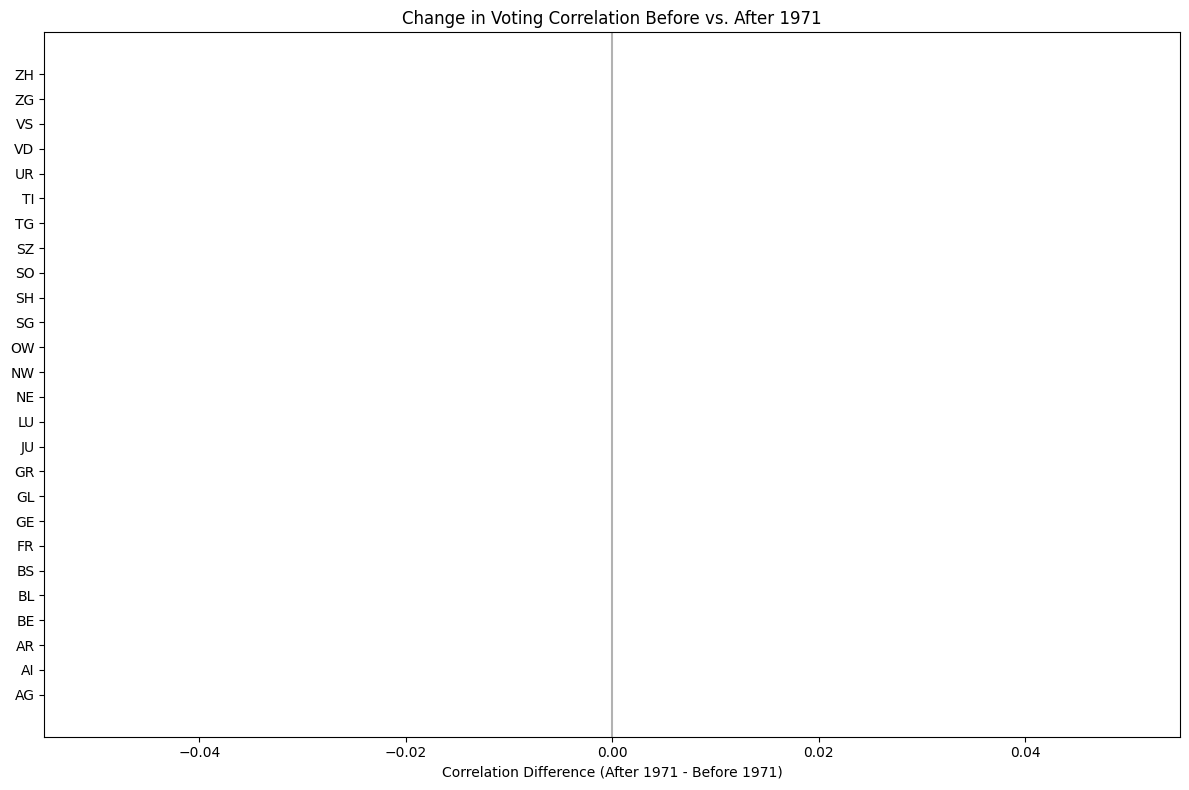

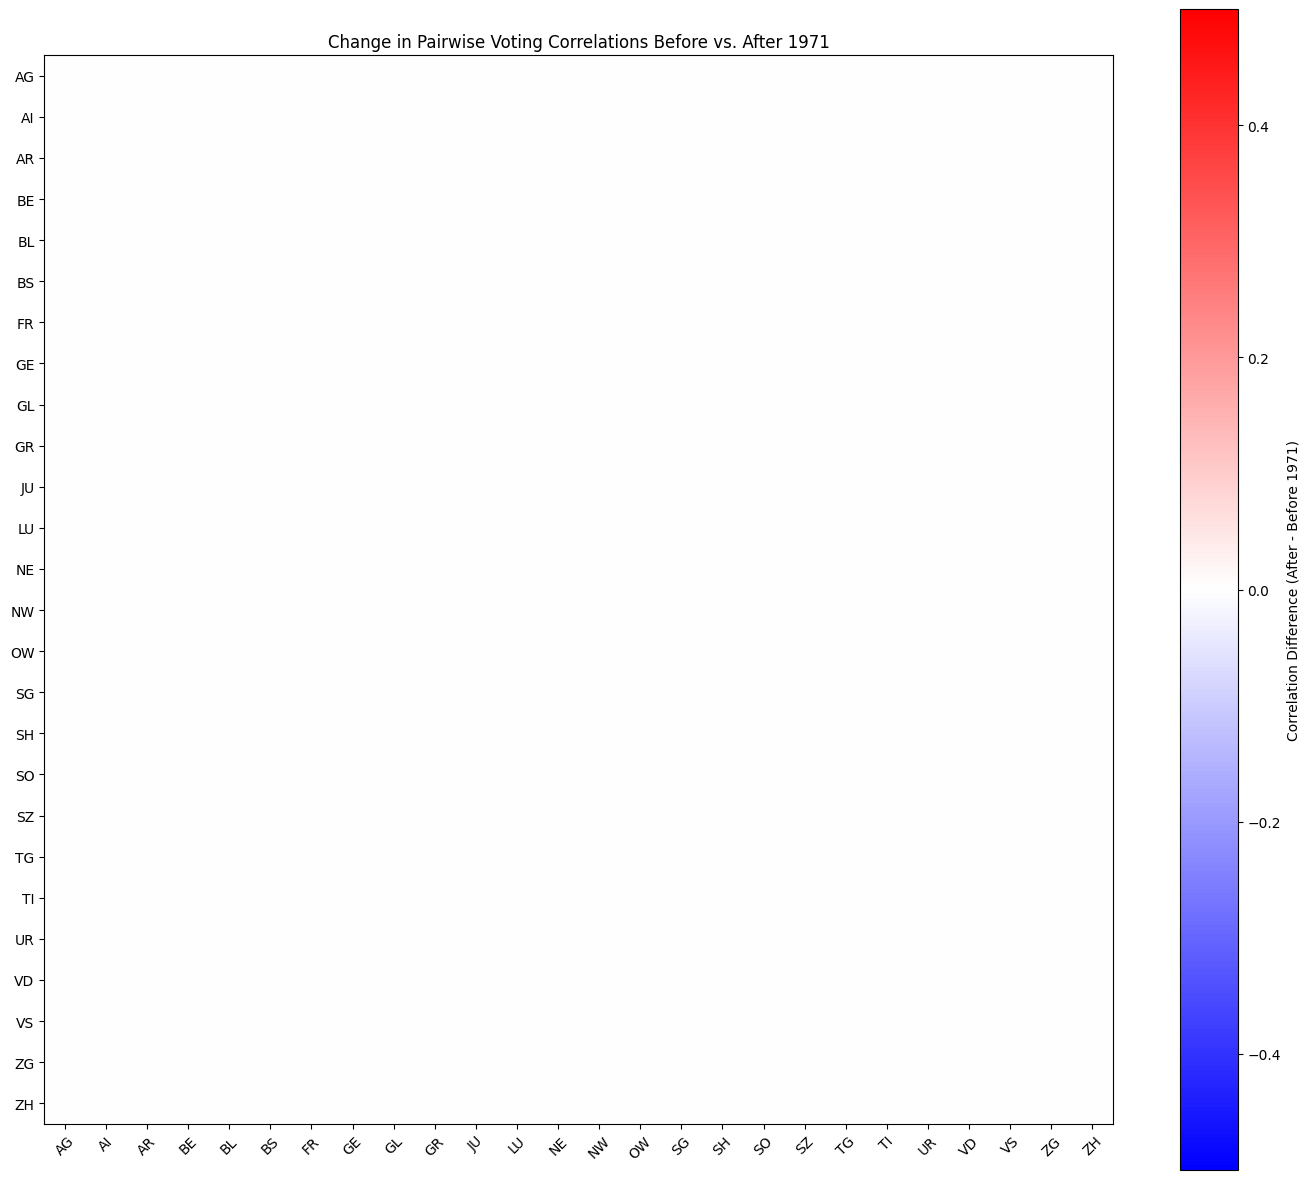

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import requests
import io
import zipfile
import os

# First, let's prepare the data
# Assuming 'df' is your dataframe with the voting data
# We need to extract the canton-level voting data before and after 1971

# First, let's split the data into before and after 1971
init_date = datetime(1971, 2, 7, 0, 0)

# Teile die Daten in Abstimmungen vor und nach der Einführung des Frauenstimmrechts
# Abstimmungen vor 1971 (ohne Frauenstimmrecht)
df_before_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') < init_date]
df_after_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') >= init_date]

# Create a list of all cantons
canton_codes = ['AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 
                'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 
                'TI', 'UR', 'VD', 'VS', 'ZG', 'ZH']

# Function to create a correlation matrix for a given time period
def create_correlation_matrix(data, canton_codes):
    # Create an empty correlation matrix
    corr_matrix = pd.DataFrame(index=canton_codes, columns=canton_codes)
    
    # For each pair of cantons, calculate the correlation of their voting patterns
    for i, canton1 in enumerate(canton_codes):
        for j, canton2 in enumerate(canton_codes):
            if i > j:  # Only calculate for the lower triangle
                continue
                
            # Get the voting data for both cantons
            canton1_col = f"{canton1.lower()}-japroz"
            canton2_col = f"{canton2.lower()}-japroz"
            
            # Check if both columns exist in the dataframe
            if canton1_col in data.columns and canton2_col in data.columns:
                # Get the voting percentages for both cantons
                votes1 = data[canton1_col].dropna()
                votes2 = data[canton2_col].dropna()
                
                # Find common votes (by index)
                common_indices = votes1.index.intersection(votes2.index)
                
                if len(common_indices) > 5:  # Only calculate if there are enough common votes
                    # Calculate correlation
                    correlation = np.corrcoef(
                        votes1.loc[common_indices], 
                        votes2.loc[common_indices]
                    )[0, 1]
                    
                    # Store in the matrix
                    corr_matrix.loc[canton1, canton2] = correlation
                    corr_matrix.loc[canton2, canton1] = correlation
                else:
                    corr_matrix.loc[canton1, canton2] = np.nan
                    corr_matrix.loc[canton2, canton1] = np.nan
            else:
                corr_matrix.loc[canton1, canton2] = np.nan
                corr_matrix.loc[canton2, canton1] = np.nan
                
    # Fill diagonal with 1s
    for canton in canton_codes:
        corr_matrix.loc[canton, canton] = 1.0
        
    return corr_matrix

# Create correlation matrices for both periods
corr_before = create_correlation_matrix(df_before_1971, canton_codes)
corr_after = create_correlation_matrix(df_after_1971, canton_codes)

# Handle the case of Jura (JU) which was created after 1971
if 'JU' in corr_before.index and corr_before.loc['JU'].isna().all():
    corr_before = corr_before.drop('JU', axis=0).drop('JU', axis=1)

# Fill NaN values with the mean of the respective matrix
corr_before = corr_before.fillna(corr_before.mean().mean())
corr_after = corr_after.fillna(corr_after.mean().mean())

# Calculate the difference in correlation patterns
# For each canton, we'll calculate the average correlation with all other cantons
corr_diff = {}
for canton in corr_before.index:
    if canton in corr_after.index:
        # Calculate average correlation with other cantons (excluding self-correlation)
        avg_corr_before = corr_before.loc[canton].drop(canton).mean()
        avg_corr_after = corr_after.loc[canton].drop(canton).mean()
        corr_diff[canton] = avg_corr_after - avg_corr_before

# Download Swiss cantons shapefile if not already available
shapefile_path = 'data/swiss_cantons'
if not os.path.exists(shapefile_path):
    os.makedirs(shapefile_path, exist_ok=True)
    
    # URL for Swiss cantons shapefile (this is an example URL, you may need to find the correct one)
    url = "https://www.swisstopo.admin.ch/content/swisstopo-internet/en/geodata/landscape/boundaries3d/_jcr_content/contentPar/tabs/items/documents_publicatio/tabPar/downloadlist/downloadItems/1_1547207224391.download/BOUNDARIES_2022-01-01_2056_EN.zip"
    
    try:
        print("Downloading Swiss cantons shapefile...")
        response = requests.get(url)
        if response.status_code == 200:
            z = zipfile.ZipFile(io.BytesIO(response.content))
            z.extractall(shapefile_path)
            print("Download and extraction complete.")
        else:
            print(f"Failed to download shapefile: HTTP {response.status_code}")
            raise Exception("Download failed")
    except Exception as e:
        print(f"Error downloading shapefile: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a mask for the upper triangle
        mask = np.triu(np.ones_like(diff_matrix, dtype=bool))
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()
else:
    try:
        # Try to load the shapefile
        shapefile = os.path.join(shapefile_path, 'swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp')
        swiss_map = gpd.read_file(shapefile)
        
        # Map the canton names to match the shapefile
        # This mapping might need adjustment based on your shapefile
        canton_mapping = {
            'AG': 'Aargau', 'AI': 'Appenzell Innerrhoden', 'AR': 'Appenzell Ausserrhoden',
            'BE': 'Bern', 'BL': 'Basel-Landschaft', 'BS': 'Basel-Stadt', 'FR': 'Fribourg',
            'GE': 'Genève', 'GL': 'Glarus', 'GR': 'Graubünden', 'JU': 'Jura', 'LU': 'Luzern',
            'NE': 'Neuchâtel', 'NW': 'Nidwalden', 'OW': 'Obwalden', 'SG': 'St. Gallen',
            'SH': 'Schaffhausen', 'SO': 'Solothurn', 'SZ': 'Schwyz', 'TG': 'Thurgau',
            'TI': 'Ticino', 'UR': 'Uri', 'VD': 'Vaud', 'VS': 'Valais', 'ZG': 'Zug', 'ZH': 'Zürich'
        }
        
        # Create a new column with the correlation differences
        swiss_map['corr_diff'] = swiss_map['NAME'].map(
            lambda x: corr_diff.get(next((k for k, v in canton_mapping.items() if v == x), None), 0)
        )
        
        # Create a custom colormap: blue for negative, white for zero, red for positive
        colors = ['blue', 'white', 'red']
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', colors, N=256)
        
        # Plot the map
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        
        # Find the maximum absolute value for symmetric color scaling
        vmax = max(abs(min(corr_diff.values())), abs(max(corr_diff.values())))
        
        swiss_map.plot(
            column='corr_diff',
            cmap=cmap,
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            vmin=-vmax,
            vmax=vmax,
            legend=True,
            legend_kwds={'label': 'Correlation Difference (After - Before 1971)'}
        )
        
        # Add canton labels
        for idx, row in swiss_map.iterrows():
            plt.annotate(text=row['NAME'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                        horizontalalignment='center', fontsize=8)
        
        plt.title('Change in Voting Correlation Patterns Before vs. After 1971')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating map: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()

C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_before = corr_before.fillna(corr_before.mean().mean())
C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:86: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_after = corr_after.fillna(corr_after.mean().mean())


Error downloading shapefile: File is not a zip file
Creating a simple visualization without the map...


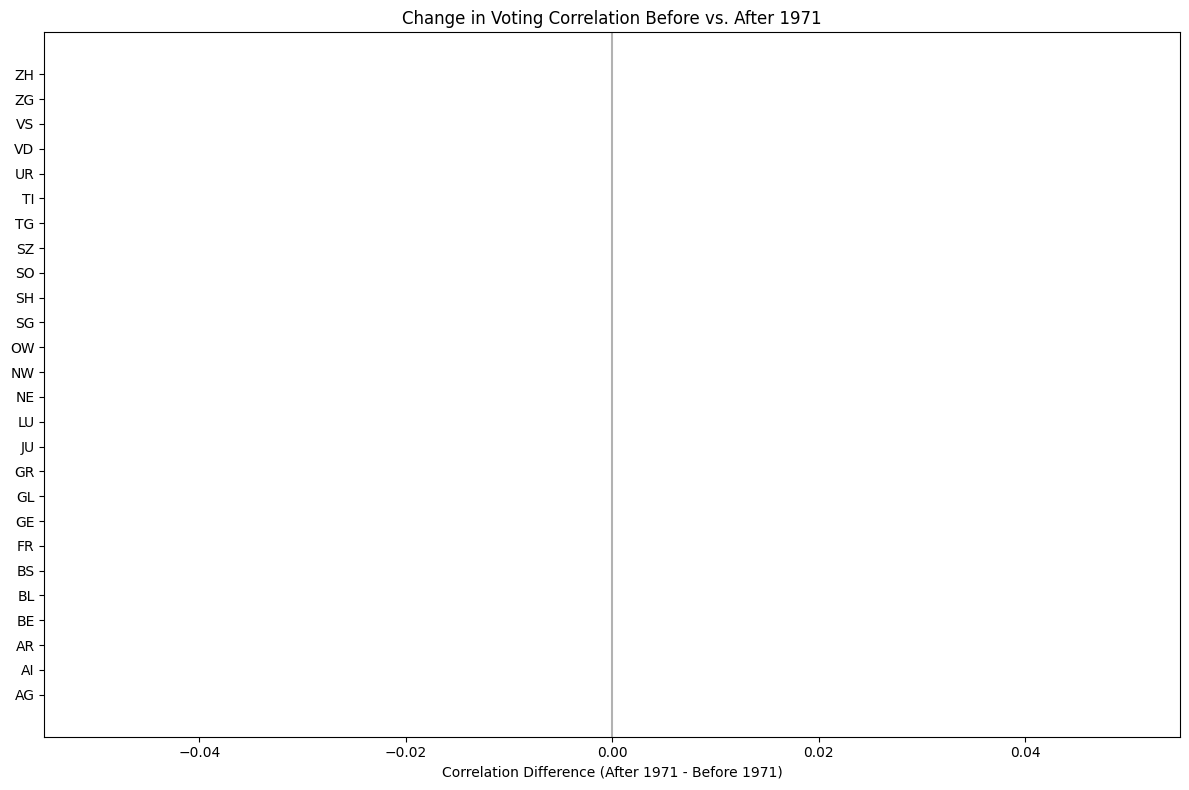

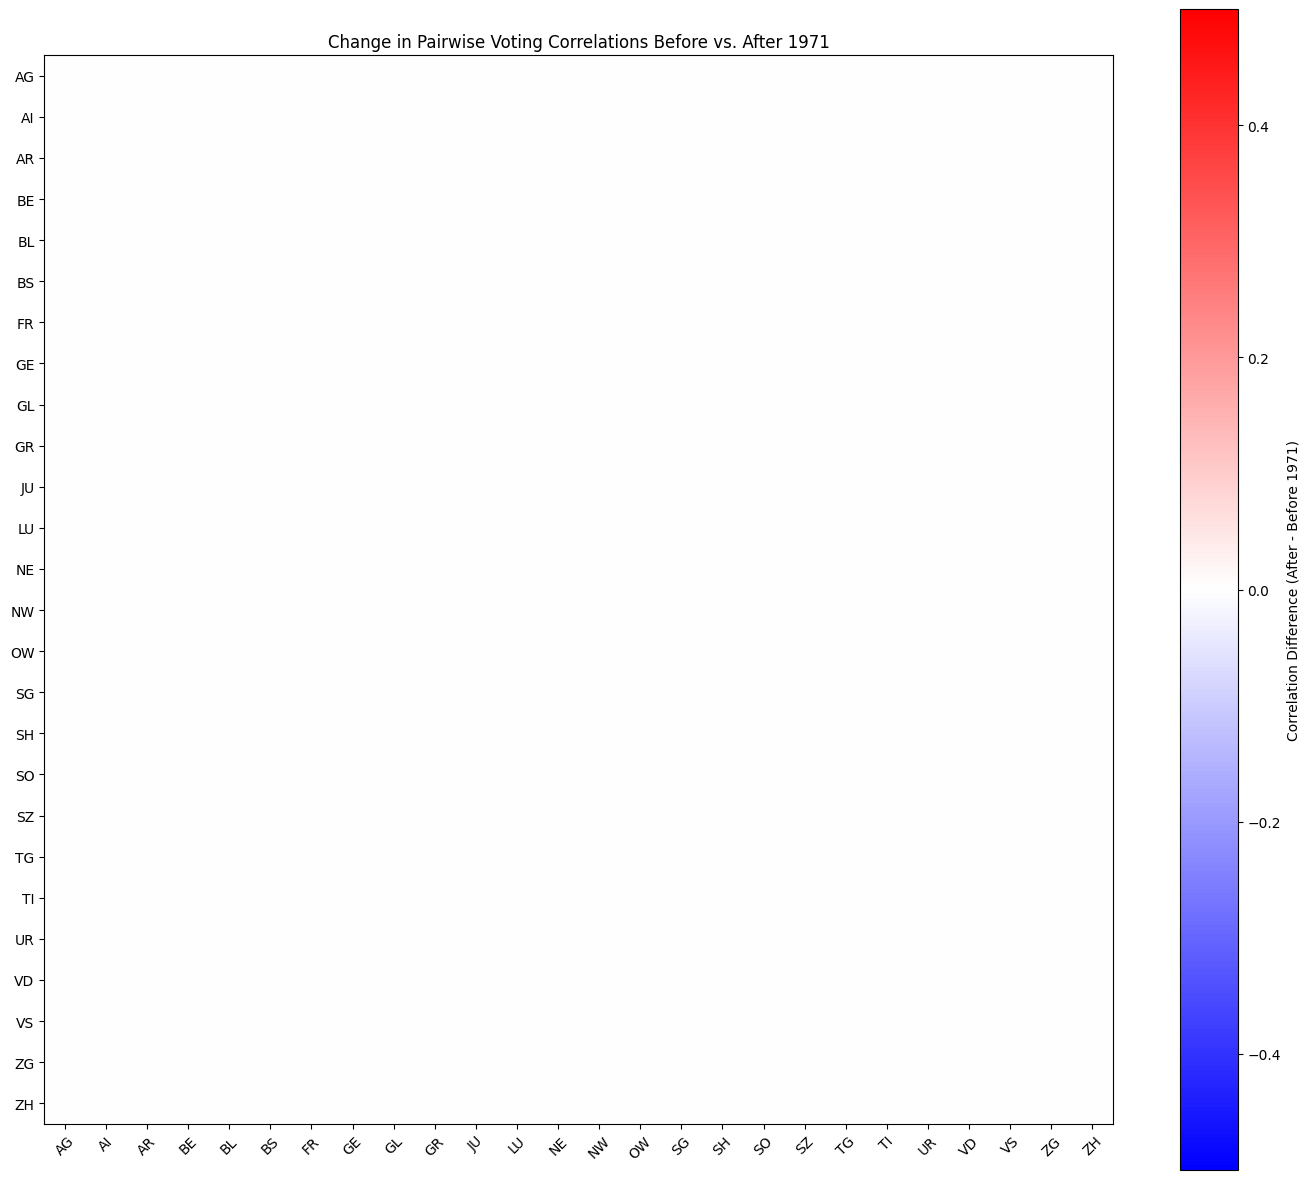

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import requests
import io
import zipfile
import os

# First, let's prepare the data
# Assuming 'df' is your dataframe with the voting data
# We need to extract the canton-level voting data before and after 1971

# First, let's split the data into before and after 1971
init_date = datetime(1971, 2, 7, 0, 0)

# Teile die Daten in Abstimmungen vor und nach der Einführung des Frauenstimmrechts
# Abstimmungen vor 1971 (ohne Frauenstimmrecht)
df_before_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') < init_date]
df_after_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') >= init_date]

# Create a list of all cantons
canton_codes = ['AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 
                'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 
                'TI', 'UR', 'VD', 'VS', 'ZG', 'ZH']

# Function to create a correlation matrix for a given time period
def create_correlation_matrix(data, canton_codes):
    # Create an empty correlation matrix
    corr_matrix = pd.DataFrame(index=canton_codes, columns=canton_codes)
    
    # For each pair of cantons, calculate the correlation of their voting patterns
    for i, canton1 in enumerate(canton_codes):
        for j, canton2 in enumerate(canton_codes):
            if i > j:  # Only calculate for the lower triangle
                continue
                
            # Get the voting data for both cantons
            canton1_col = f"{canton1.lower()}-japroz"
            canton2_col = f"{canton2.lower()}-japroz"
            
            # Check if both columns exist in the dataframe
            if canton1_col in data.columns and canton2_col in data.columns:
                # Get the voting percentages for both cantons
                votes1 = data[canton1_col].dropna()
                votes2 = data[canton2_col].dropna()
                
                # Find common votes (by index)
                common_indices = votes1.index.intersection(votes2.index)
                
                if len(common_indices) > 5:  # Only calculate if there are enough common votes
                    # Calculate correlation
                    correlation = np.corrcoef(
                        votes1.loc[common_indices], 
                        votes2.loc[common_indices]
                    )[0, 1]
                    
                    # Store in the matrix
                    corr_matrix.loc[canton1, canton2] = correlation
                    corr_matrix.loc[canton2, canton1] = correlation
                else:
                    corr_matrix.loc[canton1, canton2] = np.nan
                    corr_matrix.loc[canton2, canton1] = np.nan
            else:
                corr_matrix.loc[canton1, canton2] = np.nan
                corr_matrix.loc[canton2, canton1] = np.nan
                
    # Fill diagonal with 1s
    for canton in canton_codes:
        corr_matrix.loc[canton, canton] = 1.0
        
    return corr_matrix

# Create correlation matrices for both periods
corr_before = create_correlation_matrix(df_before_1971, canton_codes)
corr_after = create_correlation_matrix(df_after_1971, canton_codes)

# Handle the case of Jura (JU) which was created after 1971
if 'JU' in corr_before.index and corr_before.loc['JU'].isna().all():
    corr_before = corr_before.drop('JU', axis=0).drop('JU', axis=1)

# Fill NaN values with the mean of the respective matrix
corr_before = corr_before.fillna(corr_before.mean().mean())
corr_after = corr_after.fillna(corr_after.mean().mean())

# Calculate the difference in correlation patterns
# For each canton, we'll calculate the average correlation with all other cantons
corr_diff = {}
for canton in corr_before.index:
    if canton in corr_after.index:
        # Calculate average correlation with other cantons (excluding self-correlation)
        avg_corr_before = corr_before.loc[canton].drop(canton).mean()
        avg_corr_after = corr_after.loc[canton].drop(canton).mean()
        corr_diff[canton] = avg_corr_after - avg_corr_before

# Download Swiss cantons shapefile if not already available
shapefile_path = 'data/swiss_cantons'
if not os.path.exists(shapefile_path):
    os.makedirs(shapefile_path, exist_ok=True)
    
    # URL for Swiss cantons shapefile (this is an example URL, you may need to find the correct one)
    url = "https://www.swisstopo.admin.ch/content/swisstopo-internet/en/geodata/landscape/boundaries3d/_jcr_content/contentPar/tabs/items/documents_publicatio/tabPar/downloadlist/downloadItems/1_1547207224391.download/BOUNDARIES_2022-01-01_2056_EN.zip"
    
    try:
        print("Downloading Swiss cantons shapefile...")
        response = requests.get(url)
        if response.status_code == 200:
            z = zipfile.ZipFile(io.BytesIO(response.content))
            z.extractall(shapefile_path)
            print("Download and extraction complete.")
        else:
            print(f"Failed to download shapefile: HTTP {response.status_code}")
            raise Exception("Download failed")
    except Exception as e:
        print(f"Error downloading shapefile: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a mask for the upper triangle
        mask = np.triu(np.ones_like(diff_matrix, dtype=bool))
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()
else:
    try:
        # Try to load the shapefile
        shapefile = os.path.join(shapefile_path, 'swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp')
        swiss_map = gpd.read_file(shapefile)
        
        # Map the canton names to match the shapefile
        # This mapping might need adjustment based on your shapefile
        canton_mapping = {
            'AG': 'Aargau', 'AI': 'Appenzell Innerrhoden', 'AR': 'Appenzell Ausserrhoden',
            'BE': 'Bern', 'BL': 'Basel-Landschaft', 'BS': 'Basel-Stadt', 'FR': 'Fribourg',
            'GE': 'Genève', 'GL': 'Glarus', 'GR': 'Graubünden', 'JU': 'Jura', 'LU': 'Luzern',
            'NE': 'Neuchâtel', 'NW': 'Nidwalden', 'OW': 'Obwalden', 'SG': 'St. Gallen',
            'SH': 'Schaffhausen', 'SO': 'Solothurn', 'SZ': 'Schwyz', 'TG': 'Thurgau',
            'TI': 'Ticino', 'UR': 'Uri', 'VD': 'Vaud', 'VS': 'Valais', 'ZG': 'Zug', 'ZH': 'Zürich'
        }
        
        # Create a new column with the correlation differences
        swiss_map['corr_diff'] = swiss_map['NAME'].map(
            lambda x: corr_diff.get(next((k for k, v in canton_mapping.items() if v == x), None), 0)
        )
        
        # Create a custom colormap: blue for negative, white for zero, red for positive
        colors = ['blue', 'white', 'red']
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', colors, N=256)
        
        # Plot the map
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        
        # Find the maximum absolute value for symmetric color scaling
        vmax = max(abs(min(corr_diff.values())), abs(max(corr_diff.values())))
        
        swiss_map.plot(
            column='corr_diff',
            cmap=cmap,
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            vmin=-vmax,
            vmax=vmax,
            legend=True,
            legend_kwds={'label': 'Correlation Difference (After - Before 1971)'}
        )
        
        # Add canton labels
        for idx, row in swiss_map.iterrows():
            plt.annotate(text=row['NAME'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                        horizontalalignment='center', fontsize=8)
        
        plt.title('Change in Voting Correlation Patterns Before vs. After 1971')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating map: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()

C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_before = corr_before.fillna(corr_before.mean().mean())
C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:86: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_after = corr_after.fillna(corr_after.mean().mean())


Error downloading shapefile: File is not a zip file
Creating a simple visualization without the map...


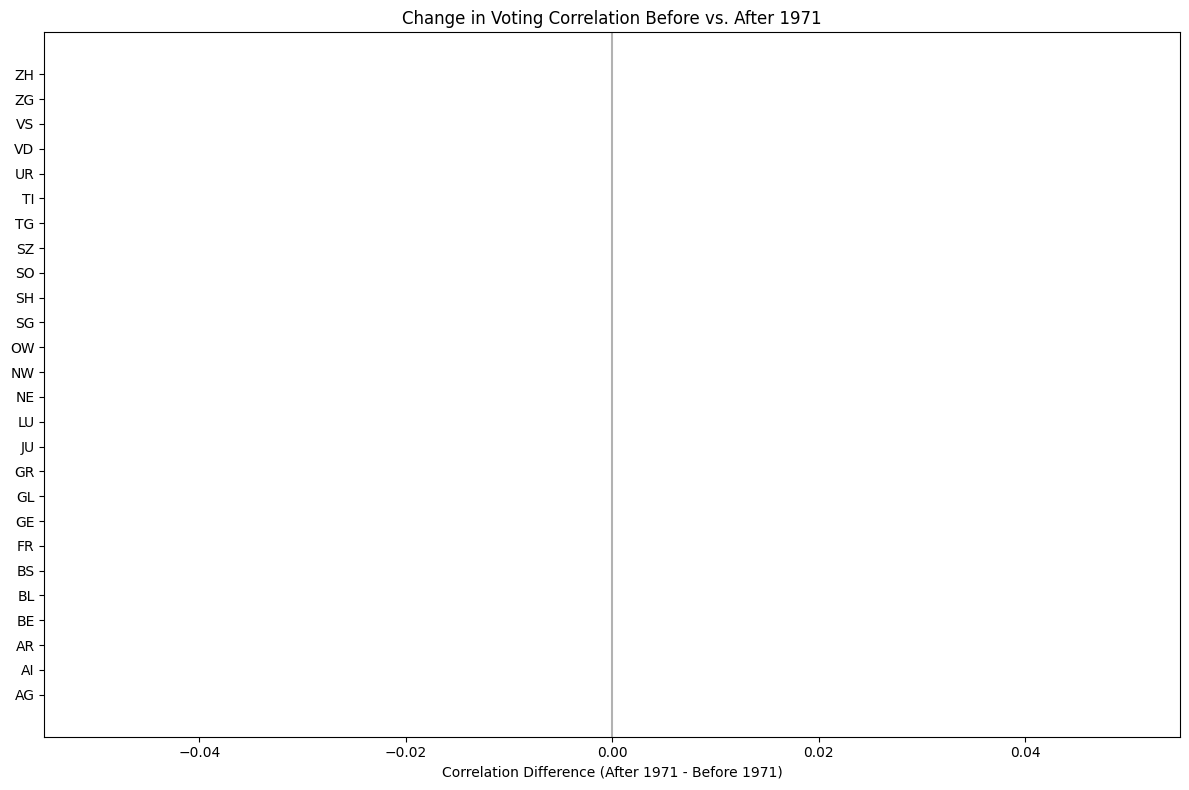

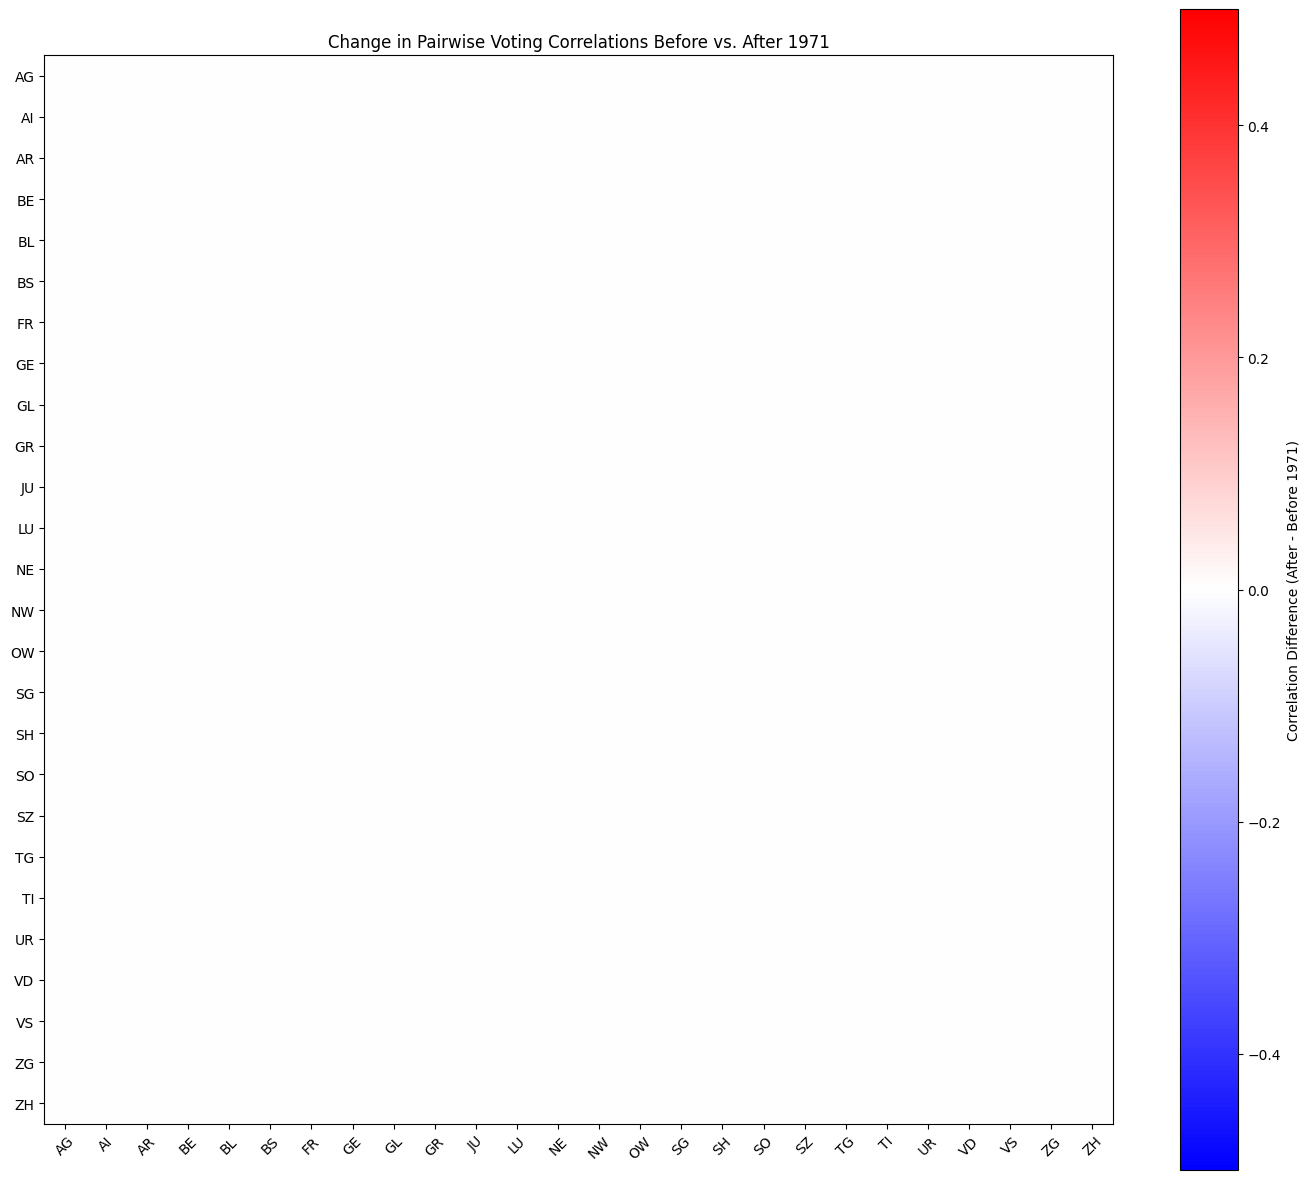

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import requests
import io
import zipfile
import os

# First, let's prepare the data
# Assuming 'df' is your dataframe with the voting data
# We need to extract the canton-level voting data before and after 1971

# First, let's split the data into before and after 1971
init_date = datetime(1971, 2, 7, 0, 0)

# Teile die Daten in Abstimmungen vor und nach der Einführung des Frauenstimmrechts
# Abstimmungen vor 1971 (ohne Frauenstimmrecht)
df_before_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') < init_date]
df_after_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') >= init_date]

# Create a list of all cantons
canton_codes = ['AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 
                'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 
                'TI', 'UR', 'VD', 'VS', 'ZG', 'ZH']

# Function to create a correlation matrix for a given time period
def create_correlation_matrix(data, canton_codes):
    # Create an empty correlation matrix
    corr_matrix = pd.DataFrame(index=canton_codes, columns=canton_codes)
    
    # For each pair of cantons, calculate the correlation of their voting patterns
    for i, canton1 in enumerate(canton_codes):
        for j, canton2 in enumerate(canton_codes):
            if i > j:  # Only calculate for the lower triangle
                continue
                
            # Get the voting data for both cantons
            canton1_col = f"{canton1.lower()}-japroz"
            canton2_col = f"{canton2.lower()}-japroz"
            
            # Check if both columns exist in the dataframe
            if canton1_col in data.columns and canton2_col in data.columns:
                # Get the voting percentages for both cantons
                votes1 = data[canton1_col].dropna()
                votes2 = data[canton2_col].dropna()
                
                # Find common votes (by index)
                common_indices = votes1.index.intersection(votes2.index)
                
                if len(common_indices) > 5:  # Only calculate if there are enough common votes
                    # Calculate correlation
                    correlation = np.corrcoef(
                        votes1.loc[common_indices], 
                        votes2.loc[common_indices]
                    )[0, 1]
                    
                    # Store in the matrix
                    corr_matrix.loc[canton1, canton2] = correlation
                    corr_matrix.loc[canton2, canton1] = correlation
                else:
                    corr_matrix.loc[canton1, canton2] = np.nan
                    corr_matrix.loc[canton2, canton1] = np.nan
            else:
                corr_matrix.loc[canton1, canton2] = np.nan
                corr_matrix.loc[canton2, canton1] = np.nan
                
    # Fill diagonal with 1s
    for canton in canton_codes:
        corr_matrix.loc[canton, canton] = 1.0
        
    return corr_matrix

# Create correlation matrices for both periods
corr_before = create_correlation_matrix(df_before_1971, canton_codes)
corr_after = create_correlation_matrix(df_after_1971, canton_codes)

# Handle the case of Jura (JU) which was created after 1971
if 'JU' in corr_before.index and corr_before.loc['JU'].isna().all():
    corr_before = corr_before.drop('JU', axis=0).drop('JU', axis=1)

# Fill NaN values with the mean of the respective matrix
corr_before = corr_before.fillna(corr_before.mean().mean())
corr_after = corr_after.fillna(corr_after.mean().mean())

# Calculate the difference in correlation patterns
# For each canton, we'll calculate the average correlation with all other cantons
corr_diff = {}
for canton in corr_before.index:
    if canton in corr_after.index:
        # Calculate average correlation with other cantons (excluding self-correlation)
        avg_corr_before = corr_before.loc[canton].drop(canton).mean()
        avg_corr_after = corr_after.loc[canton].drop(canton).mean()
        corr_diff[canton] = avg_corr_after - avg_corr_before

# Download Swiss cantons shapefile if not already available
shapefile_path = 'data/swiss_cantons'
if not os.path.exists(shapefile_path):
    os.makedirs(shapefile_path, exist_ok=True)
    
    # URL for Swiss cantons shapefile (this is an example URL, you may need to find the correct one)
    url = "https://www.swisstopo.admin.ch/content/swisstopo-internet/en/geodata/landscape/boundaries3d/_jcr_content/contentPar/tabs/items/documents_publicatio/tabPar/downloadlist/downloadItems/1_1547207224391.download/BOUNDARIES_2022-01-01_2056_EN.zip"
    
    try:
        print("Downloading Swiss cantons shapefile...")
        response = requests.get(url)
        if response.status_code == 200:
            z = zipfile.ZipFile(io.BytesIO(response.content))
            z.extractall(shapefile_path)
            print("Download and extraction complete.")
        else:
            print(f"Failed to download shapefile: HTTP {response.status_code}")
            raise Exception("Download failed")
    except Exception as e:
        print(f"Error downloading shapefile: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a mask for the upper triangle
        mask = np.triu(np.ones_like(diff_matrix, dtype=bool))
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()
else:
    try:
        # Try to load the shapefile
        shapefile = os.path.join(shapefile_path, 'swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp')
        swiss_map = gpd.read_file(shapefile)
        
        # Map the canton names to match the shapefile
        # This mapping might need adjustment based on your shapefile
        canton_mapping = {
            'AG': 'Aargau', 'AI': 'Appenzell Innerrhoden', 'AR': 'Appenzell Ausserrhoden',
            'BE': 'Bern', 'BL': 'Basel-Landschaft', 'BS': 'Basel-Stadt', 'FR': 'Fribourg',
            'GE': 'Genève', 'GL': 'Glarus', 'GR': 'Graubünden', 'JU': 'Jura', 'LU': 'Luzern',
            'NE': 'Neuchâtel', 'NW': 'Nidwalden', 'OW': 'Obwalden', 'SG': 'St. Gallen',
            'SH': 'Schaffhausen', 'SO': 'Solothurn', 'SZ': 'Schwyz', 'TG': 'Thurgau',
            'TI': 'Ticino', 'UR': 'Uri', 'VD': 'Vaud', 'VS': 'Valais', 'ZG': 'Zug', 'ZH': 'Zürich'
        }
        
        # Create a new column with the correlation differences
        swiss_map['corr_diff'] = swiss_map['NAME'].map(
            lambda x: corr_diff.get(next((k for k, v in canton_mapping.items() if v == x), None), 0)
        )
        
        # Create a custom colormap: blue for negative, white for zero, red for positive
        colors = ['blue', 'white', 'red']
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', colors, N=256)
        
        # Plot the map
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        
        # Find the maximum absolute value for symmetric color scaling
        vmax = max(abs(min(corr_diff.values())), abs(max(corr_diff.values())))
        
        swiss_map.plot(
            column='corr_diff',
            cmap=cmap,
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            vmin=-vmax,
            vmax=vmax,
            legend=True,
            legend_kwds={'label': 'Correlation Difference (After - Before 1971)'}
        )
        
        # Add canton labels
        for idx, row in swiss_map.iterrows():
            plt.annotate(text=row['NAME'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                        horizontalalignment='center', fontsize=8)
        
        plt.title('Change in Voting Correlation Patterns Before vs. After 1971')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating map: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()

C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_before = corr_before.fillna(corr_before.mean().mean())
C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:86: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_after = corr_after.fillna(corr_after.mean().mean())


Error downloading shapefile: File is not a zip file
Creating a simple visualization without the map...


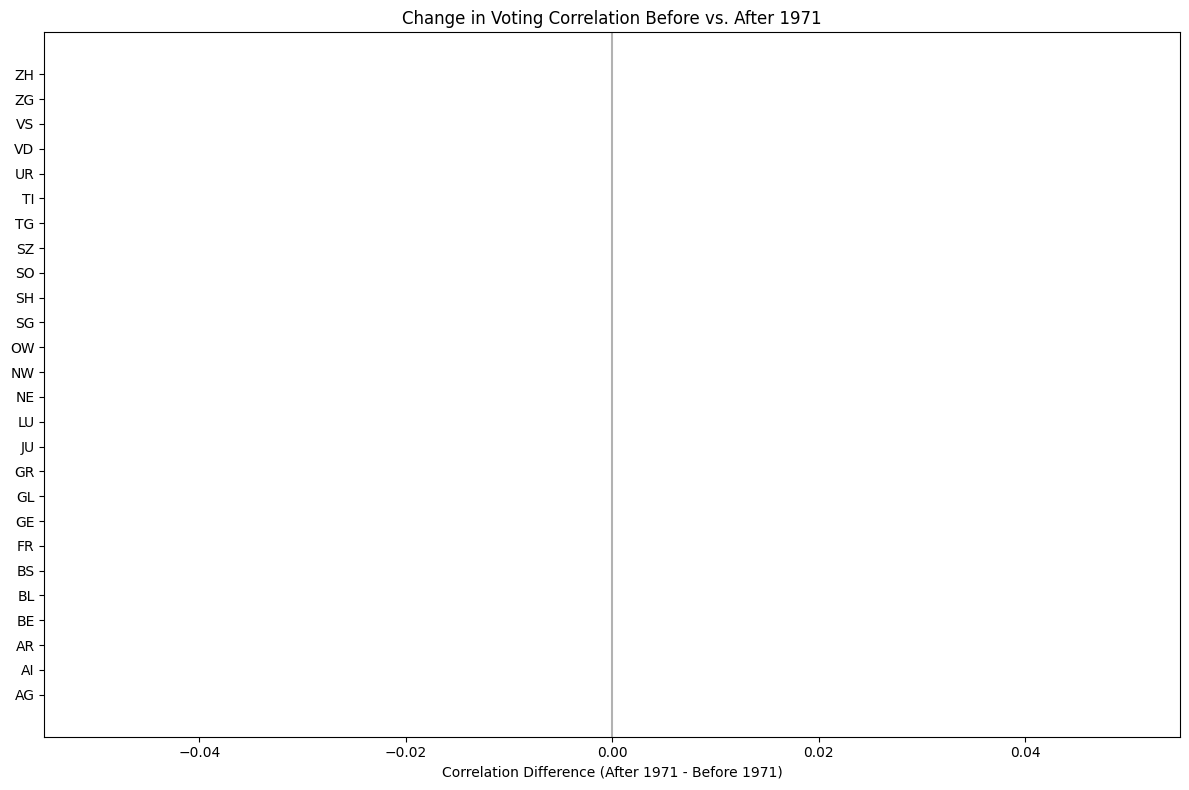

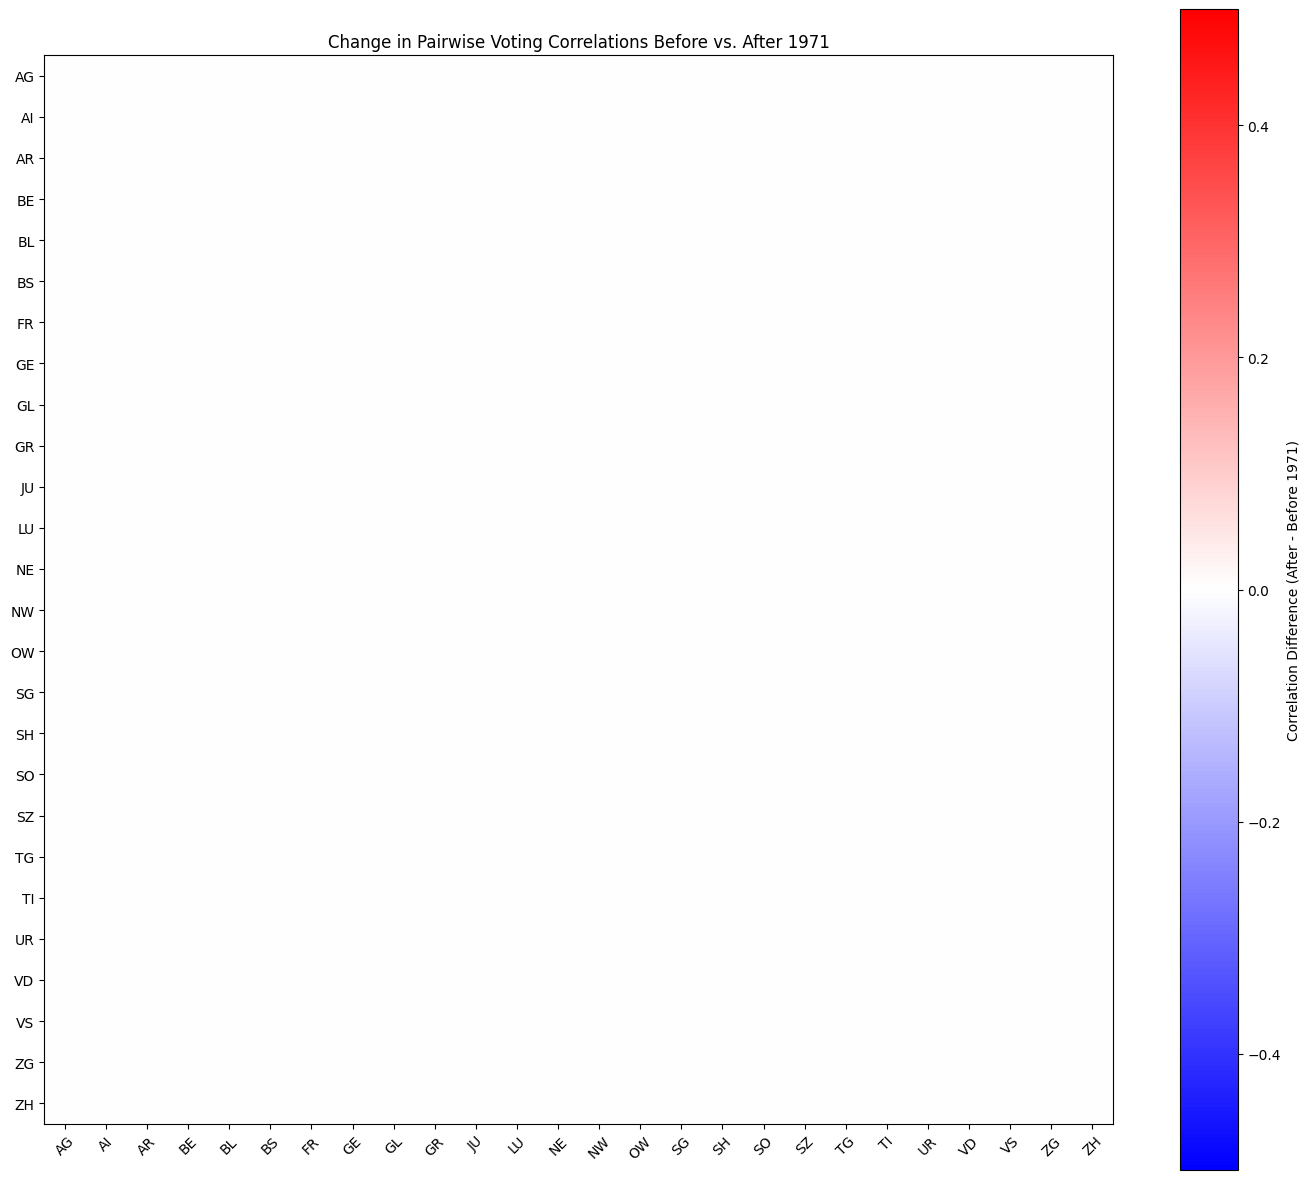

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import requests
import io
import zipfile
import os

# First, let's prepare the data
# Assuming 'df' is your dataframe with the voting data
# We need to extract the canton-level voting data before and after 1971

# First, let's split the data into before and after 1971
init_date = datetime(1971, 2, 7, 0, 0)

# Teile die Daten in Abstimmungen vor und nach der Einführung des Frauenstimmrechts
# Abstimmungen vor 1971 (ohne Frauenstimmrecht)
df_before_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') < init_date]
df_after_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') >= init_date]

# Create a list of all cantons
canton_codes = ['AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 
                'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 
                'TI', 'UR', 'VD', 'VS', 'ZG', 'ZH']

# Function to create a correlation matrix for a given time period
def create_correlation_matrix(data, canton_codes):
    # Create an empty correlation matrix
    corr_matrix = pd.DataFrame(index=canton_codes, columns=canton_codes)
    
    # For each pair of cantons, calculate the correlation of their voting patterns
    for i, canton1 in enumerate(canton_codes):
        for j, canton2 in enumerate(canton_codes):
            if i > j:  # Only calculate for the lower triangle
                continue
                
            # Get the voting data for both cantons
            canton1_col = f"{canton1.lower()}-japroz"
            canton2_col = f"{canton2.lower()}-japroz"
            
            # Check if both columns exist in the dataframe
            if canton1_col in data.columns and canton2_col in data.columns:
                # Get the voting percentages for both cantons
                votes1 = data[canton1_col].dropna()
                votes2 = data[canton2_col].dropna()
                
                # Find common votes (by index)
                common_indices = votes1.index.intersection(votes2.index)
                
                if len(common_indices) > 5:  # Only calculate if there are enough common votes
                    # Calculate correlation
                    correlation = np.corrcoef(
                        votes1.loc[common_indices], 
                        votes2.loc[common_indices]
                    )[0, 1]
                    
                    # Store in the matrix
                    corr_matrix.loc[canton1, canton2] = correlation
                    corr_matrix.loc[canton2, canton1] = correlation
                else:
                    corr_matrix.loc[canton1, canton2] = np.nan
                    corr_matrix.loc[canton2, canton1] = np.nan
            else:
                corr_matrix.loc[canton1, canton2] = np.nan
                corr_matrix.loc[canton2, canton1] = np.nan
                
    # Fill diagonal with 1s
    for canton in canton_codes:
        corr_matrix.loc[canton, canton] = 1.0
        
    return corr_matrix

# Create correlation matrices for both periods
corr_before = create_correlation_matrix(df_before_1971, canton_codes)
corr_after = create_correlation_matrix(df_after_1971, canton_codes)

# Handle the case of Jura (JU) which was created after 1971
if 'JU' in corr_before.index and corr_before.loc['JU'].isna().all():
    corr_before = corr_before.drop('JU', axis=0).drop('JU', axis=1)

# Fill NaN values with the mean of the respective matrix
corr_before = corr_before.fillna(corr_before.mean().mean())
corr_after = corr_after.fillna(corr_after.mean().mean())

# Calculate the difference in correlation patterns
# For each canton, we'll calculate the average correlation with all other cantons
corr_diff = {}
for canton in corr_before.index:
    if canton in corr_after.index:
        # Calculate average correlation with other cantons (excluding self-correlation)
        avg_corr_before = corr_before.loc[canton].drop(canton).mean()
        avg_corr_after = corr_after.loc[canton].drop(canton).mean()
        corr_diff[canton] = avg_corr_after - avg_corr_before

# Download Swiss cantons shapefile if not already available
shapefile_path = 'data/swiss_cantons'
if not os.path.exists(shapefile_path):
    os.makedirs(shapefile_path, exist_ok=True)
    
    # URL for Swiss cantons shapefile (this is an example URL, you may need to find the correct one)
    url = "https://www.swisstopo.admin.ch/content/swisstopo-internet/en/geodata/landscape/boundaries3d/_jcr_content/contentPar/tabs/items/documents_publicatio/tabPar/downloadlist/downloadItems/1_1547207224391.download/BOUNDARIES_2022-01-01_2056_EN.zip"
    
    try:
        print("Downloading Swiss cantons shapefile...")
        response = requests.get(url)
        if response.status_code == 200:
            z = zipfile.ZipFile(io.BytesIO(response.content))
            z.extractall(shapefile_path)
            print("Download and extraction complete.")
        else:
            print(f"Failed to download shapefile: HTTP {response.status_code}")
            raise Exception("Download failed")
    except Exception as e:
        print(f"Error downloading shapefile: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a mask for the upper triangle
        mask = np.triu(np.ones_like(diff_matrix, dtype=bool))
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()
else:
    try:
        # Try to load the shapefile
        shapefile = os.path.join(shapefile_path, 'swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp')
        swiss_map = gpd.read_file(shapefile)
        
        # Map the canton names to match the shapefile
        # This mapping might need adjustment based on your shapefile
        canton_mapping = {
            'AG': 'Aargau', 'AI': 'Appenzell Innerrhoden', 'AR': 'Appenzell Ausserrhoden',
            'BE': 'Bern', 'BL': 'Basel-Landschaft', 'BS': 'Basel-Stadt', 'FR': 'Fribourg',
            'GE': 'Genève', 'GL': 'Glarus', 'GR': 'Graubünden', 'JU': 'Jura', 'LU': 'Luzern',
            'NE': 'Neuchâtel', 'NW': 'Nidwalden', 'OW': 'Obwalden', 'SG': 'St. Gallen',
            'SH': 'Schaffhausen', 'SO': 'Solothurn', 'SZ': 'Schwyz', 'TG': 'Thurgau',
            'TI': 'Ticino', 'UR': 'Uri', 'VD': 'Vaud', 'VS': 'Valais', 'ZG': 'Zug', 'ZH': 'Zürich'
        }
        
        # Create a new column with the correlation differences
        swiss_map['corr_diff'] = swiss_map['NAME'].map(
            lambda x: corr_diff.get(next((k for k, v in canton_mapping.items() if v == x), None), 0)
        )
        
        # Create a custom colormap: blue for negative, white for zero, red for positive
        colors = ['blue', 'white', 'red']
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', colors, N=256)
        
        # Plot the map
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        
        # Find the maximum absolute value for symmetric color scaling
        vmax = max(abs(min(corr_diff.values())), abs(max(corr_diff.values())))
        
        swiss_map.plot(
            column='corr_diff',
            cmap=cmap,
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            vmin=-vmax,
            vmax=vmax,
            legend=True,
            legend_kwds={'label': 'Correlation Difference (After - Before 1971)'}
        )
        
        # Add canton labels
        for idx, row in swiss_map.iterrows():
            plt.annotate(text=row['NAME'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                        horizontalalignment='center', fontsize=8)
        
        plt.title('Change in Voting Correlation Patterns Before vs. After 1971')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating map: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()

C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_before = corr_before.fillna(corr_before.mean().mean())
C:\Users\fabud\AppData\Local\Temp\ipykernel_2816\3343580979.py:86: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_after = corr_after.fillna(corr_after.mean().mean())


Error downloading shapefile: File is not a zip file
Creating a simple visualization without the map...


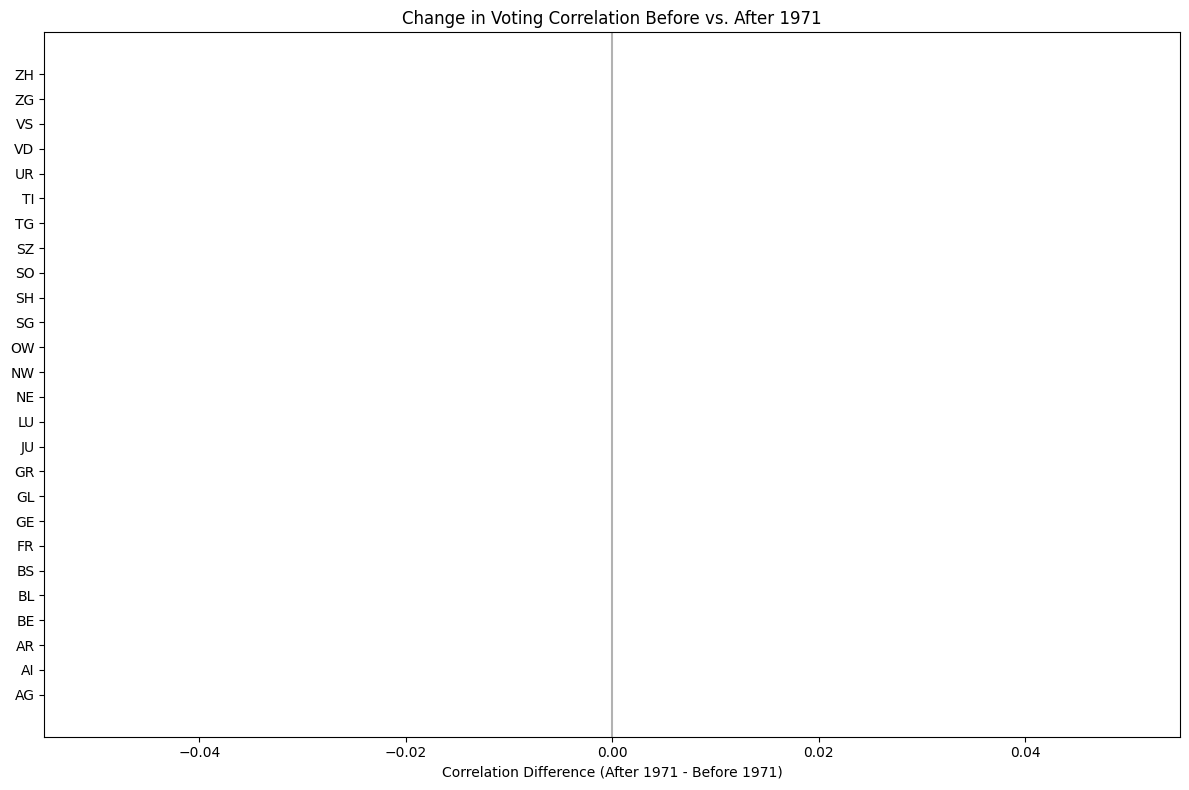

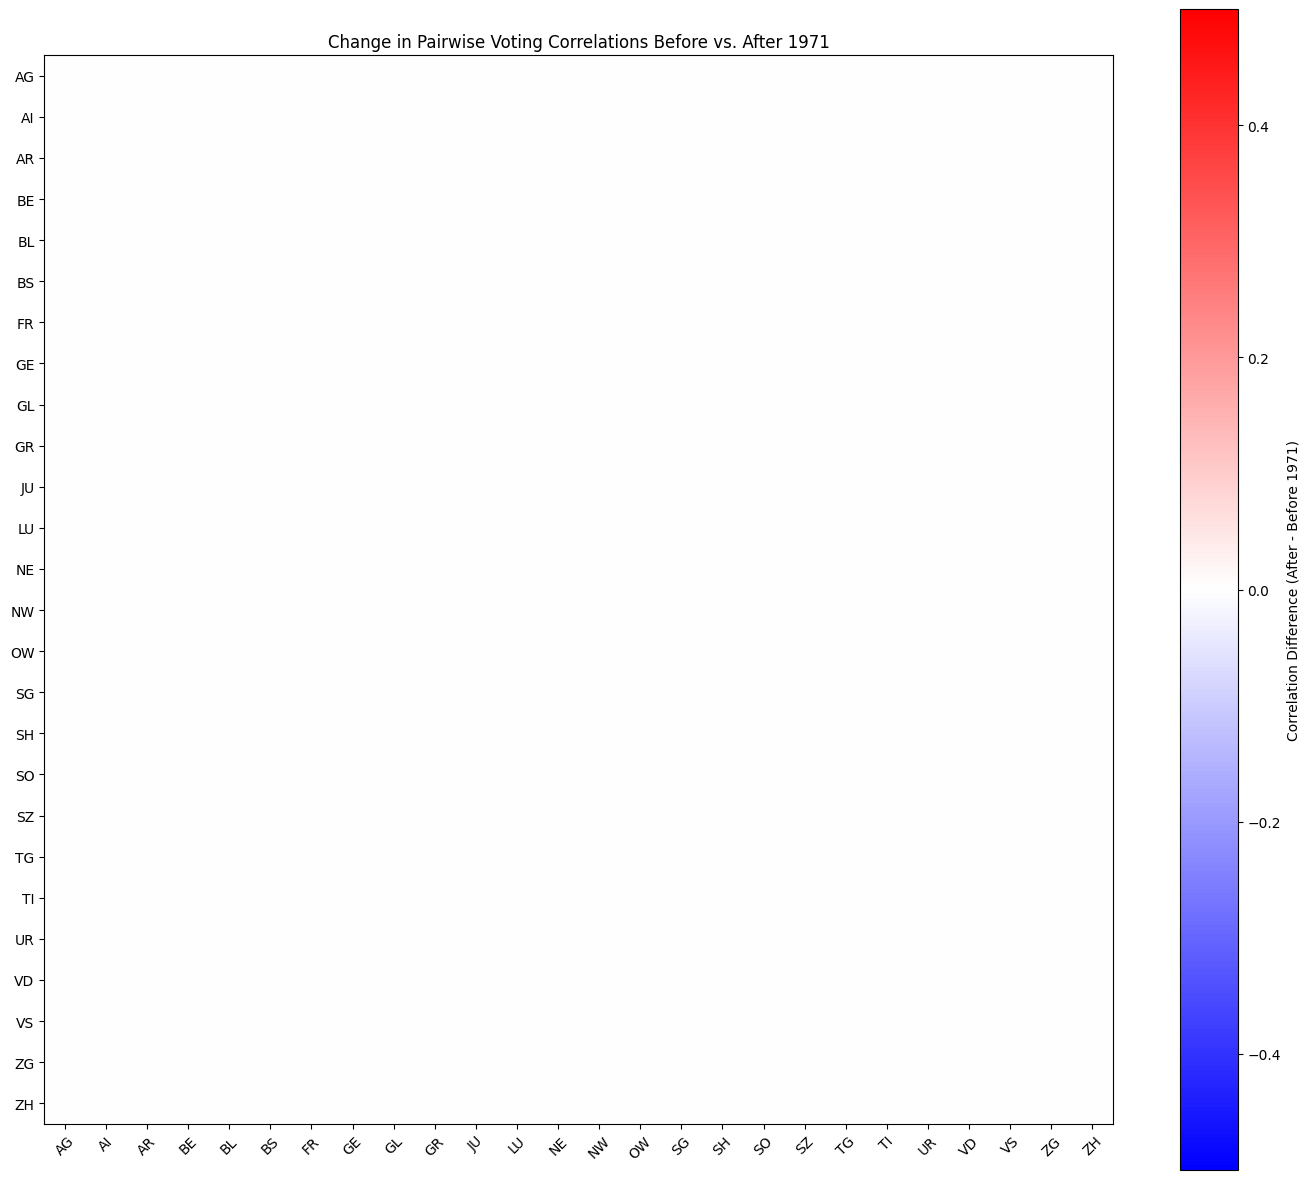

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import requests
import io
import zipfile
import os

# First, let's prepare the data
# Assuming 'df' is your dataframe with the voting data
# We need to extract the canton-level voting data before and after 1971

# First, let's split the data into before and after 1971
init_date = datetime(1971, 2, 7, 0, 0)

# Teile die Daten in Abstimmungen vor und nach der Einführung des Frauenstimmrechts
# Abstimmungen vor 1971 (ohne Frauenstimmrecht)
df_before_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') < init_date]
df_after_1971 = df_filtered.loc[pd.to_datetime(df['datum'], format='%d.%m.%Y') >= init_date]

# Create a list of all cantons
canton_codes = ['AG', 'AI', 'AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 
                'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 
                'TI', 'UR', 'VD', 'VS', 'ZG', 'ZH']

# Function to create a correlation matrix for a given time period
def create_correlation_matrix(data, canton_codes):
    # Create an empty correlation matrix
    corr_matrix = pd.DataFrame(index=canton_codes, columns=canton_codes)
    
    # For each pair of cantons, calculate the correlation of their voting patterns
    for i, canton1 in enumerate(canton_codes):
        for j, canton2 in enumerate(canton_codes):
            if i > j:  # Only calculate for the lower triangle
                continue
                
            # Get the voting data for both cantons
            canton1_col = f"{canton1.lower()}-japroz"
            canton2_col = f"{canton2.lower()}-japroz"
            
            # Check if both columns exist in the dataframe
            if canton1_col in data.columns and canton2_col in data.columns:
                # Get the voting percentages for both cantons
                votes1 = data[canton1_col].dropna()
                votes2 = data[canton2_col].dropna()
                
                # Find common votes (by index)
                common_indices = votes1.index.intersection(votes2.index)
                
                if len(common_indices) > 5:  # Only calculate if there are enough common votes
                    # Calculate correlation
                    correlation = np.corrcoef(
                        votes1.loc[common_indices], 
                        votes2.loc[common_indices]
                    )[0, 1]
                    
                    # Store in the matrix
                    corr_matrix.loc[canton1, canton2] = correlation
                    corr_matrix.loc[canton2, canton1] = correlation
                else:
                    corr_matrix.loc[canton1, canton2] = np.nan
                    corr_matrix.loc[canton2, canton1] = np.nan
            else:
                corr_matrix.loc[canton1, canton2] = np.nan
                corr_matrix.loc[canton2, canton1] = np.nan
                
    # Fill diagonal with 1s
    for canton in canton_codes:
        corr_matrix.loc[canton, canton] = 1.0
        
    return corr_matrix

# Create correlation matrices for both periods
corr_before = create_correlation_matrix(df_before_1971, canton_codes)
corr_after = create_correlation_matrix(df_after_1971, canton_codes)

# Handle the case of Jura (JU) which was created after 1971
if 'JU' in corr_before.index and corr_before.loc['JU'].isna().all():
    corr_before = corr_before.drop('JU', axis=0).drop('JU', axis=1)

# Fill NaN values with the mean of the respective matrix
corr_before = corr_before.fillna(corr_before.mean().mean())
corr_after = corr_after.fillna(corr_after.mean().mean())

# Calculate the difference in correlation patterns
# For each canton, we'll calculate the average correlation with all other cantons
corr_diff = {}
for canton in corr_before.index:
    if canton in corr_after.index:
        # Calculate average correlation with other cantons (excluding self-correlation)
        avg_corr_before = corr_before.loc[canton].drop(canton).mean()
        avg_corr_after = corr_after.loc[canton].drop(canton).mean()
        corr_diff[canton] = avg_corr_after - avg_corr_before

# Download Swiss cantons shapefile if not already available
shapefile_path = 'data/swiss_cantons'
if not os.path.exists(shapefile_path):
    os.makedirs(shapefile_path, exist_ok=True)
    
    # URL for Swiss cantons shapefile (this is an example URL, you may need to find the correct one)
    url = "https://www.swisstopo.admin.ch/content/swisstopo-internet/en/geodata/landscape/boundaries3d/_jcr_content/contentPar/tabs/items/documents_publicatio/tabPar/downloadlist/downloadItems/1_1547207224391.download/BOUNDARIES_2022-01-01_2056_EN.zip"
    
    try:
        print("Downloading Swiss cantons shapefile...")
        response = requests.get(url)
        if response.status_code == 200:
            z = zipfile.ZipFile(io.BytesIO(response.content))
            z.extractall(shapefile_path)
            print("Download and extraction complete.")
        else:
            print(f"Failed to download shapefile: HTTP {response.status_code}")
            raise Exception("Download failed")
    except Exception as e:
        print(f"Error downloading shapefile: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a mask for the upper triangle
        mask = np.triu(np.ones_like(diff_matrix, dtype=bool))
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()
else:
    try:
        # Try to load the shapefile
        shapefile = os.path.join(shapefile_path, 'swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp')
        swiss_map = gpd.read_file(shapefile)
        
        # Map the canton names to match the shapefile
        # This mapping might need adjustment based on your shapefile
        canton_mapping = {
            'AG': 'Aargau', 'AI': 'Appenzell Innerrhoden', 'AR': 'Appenzell Ausserrhoden',
            'BE': 'Bern', 'BL': 'Basel-Landschaft', 'BS': 'Basel-Stadt', 'FR': 'Fribourg',
            'GE': 'Genève', 'GL': 'Glarus', 'GR': 'Graubünden', 'JU': 'Jura', 'LU': 'Luzern',
            'NE': 'Neuchâtel', 'NW': 'Nidwalden', 'OW': 'Obwalden', 'SG': 'St. Gallen',
            'SH': 'Schaffhausen', 'SO': 'Solothurn', 'SZ': 'Schwyz', 'TG': 'Thurgau',
            'TI': 'Ticino', 'UR': 'Uri', 'VD': 'Vaud', 'VS': 'Valais', 'ZG': 'Zug', 'ZH': 'Zürich'
        }
        
        # Create a new column with the correlation differences
        swiss_map['corr_diff'] = swiss_map['NAME'].map(
            lambda x: corr_diff.get(next((k for k, v in canton_mapping.items() if v == x), None), 0)
        )
        
        # Create a custom colormap: blue for negative, white for zero, red for positive
        colors = ['blue', 'white', 'red']
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', colors, N=256)
        
        # Plot the map
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        
        # Find the maximum absolute value for symmetric color scaling
        vmax = max(abs(min(corr_diff.values())), abs(max(corr_diff.values())))
        
        swiss_map.plot(
            column='corr_diff',
            cmap=cmap,
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            vmin=-vmax,
            vmax=vmax,
            legend=True,
            legend_kwds={'label': 'Correlation Difference (After - Before 1971)'}
        )
        
        # Add canton labels
        for idx, row in swiss_map.iterrows():
            plt.annotate(text=row['NAME'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                        horizontalalignment='center', fontsize=8)
        
        plt.title('Change in Voting Correlation Patterns Before vs. After 1971')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating map: {e}")
        print("Creating a simple visualization without the map...")
        
        # Create a simple bar chart instead
        plt.figure(figsize=(12, 8))
        cantons = list(corr_diff.keys())
        values = list(corr_diff.values())
        
        # Sort by correlation difference
        sorted_indices = np.argsort(values)
        sorted_cantons = [cantons[i] for i in sorted_indices]
        sorted_values = [values[i] for i in sorted_indices]
        
        # Create color mapping
        colors = ['blue' if v < 0 else 'red' for v in sorted_values]
        
        plt.barh(sorted_cantons, sorted_values, color=colors)
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Change in Voting Correlation Before vs. After 1971')
        plt.xlabel('Correlation Difference (After 1971 - Before 1971)')
        plt.tight_layout()
        plt.show()
        
        # Also create a heatmap of the correlation differences
        plt.figure(figsize=(14, 12))
        diff_matrix = corr_after - corr_before
        
        # Create a custom colormap
        cmap = LinearSegmentedColormap.from_list('corr_diff_cmap', ['blue', 'white', 'red'], N=256)
        
        # Plot the heatmap
        im = plt.imshow(diff_matrix, cmap=cmap, vmin=-0.5, vmax=0.5)
        plt.colorbar(im, label='Correlation Difference (After - Before 1971)')
        
        # Add canton labels
        plt.xticks(range(len(diff_matrix.columns)), diff_matrix.columns, rotation=45)
        plt.yticks(range(len(diff_matrix.index)), diff_matrix.index)
        
        plt.title('Change in Pairwise Voting Correlations Before vs. After 1971')
        plt.tight_layout()
        plt.show()

### Cluster vor 1971

NaN values detected in the matrix! Replacing NaNs with 0.


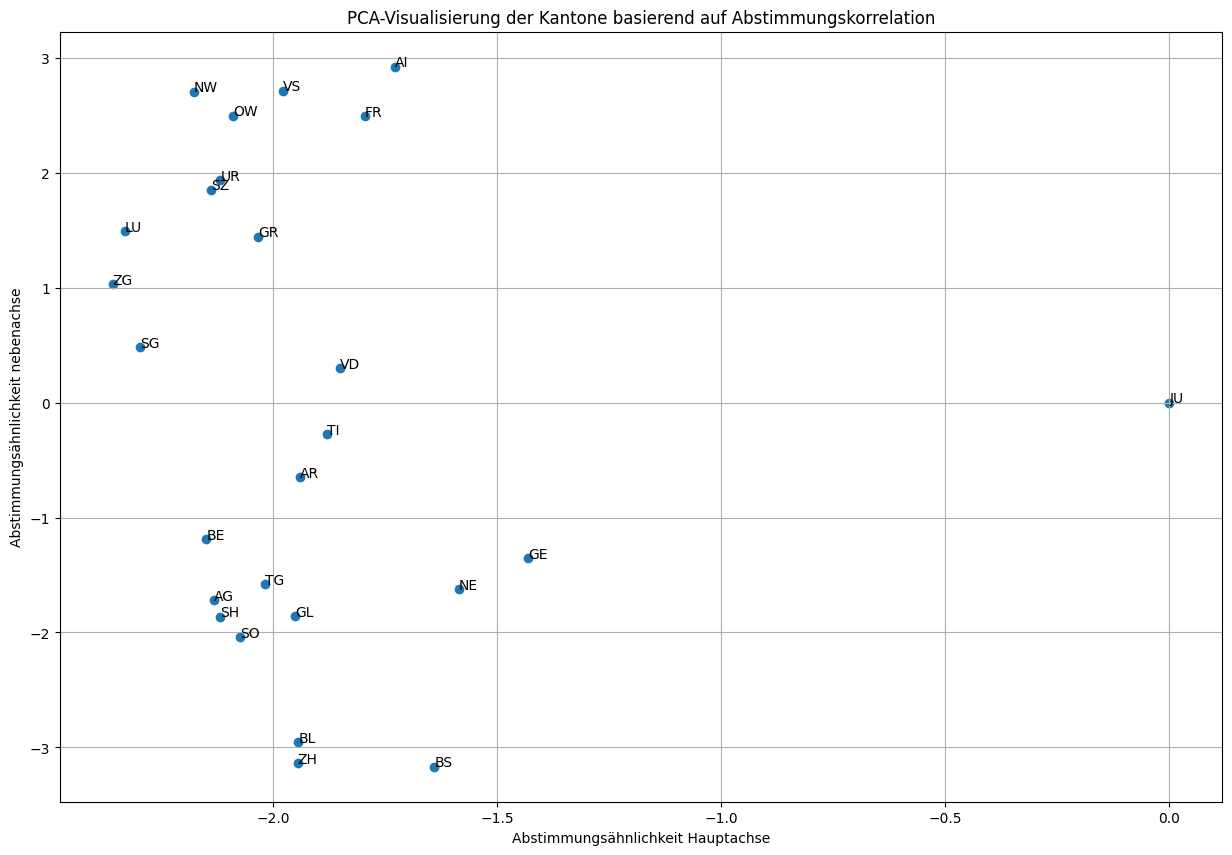

In [ ]:
corr_matrix = df_without_women.corr()

if corr_matrix.isna().sum().sum() > 0:
    print("NaN values detected in the matrix! Replacing NaNs with 0.")
    corr_matrix = corr_matrix.fillna(0)  # Replace NaNs with 0 to avoid errors


# Perform PCA using numpy (Eigen decomposition)
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix)
pca_coords = eigenvectors[:, :2] * 10

# Scatterplot of cantons based on their correlation similarity
plt.figure(figsize=(15, 10))
plt.scatter(pca_coords[:, 0], pca_coords[:, 1])

# Annotate points with canton names
for i, canton in enumerate(corr_matrix.index):
    plt.annotate(canton.upper().replace("-ANNAHME", ""), (pca_coords[i, 0], pca_coords[i, 1]), fontsize=10)

plt.title("PCA-Visualisierung der Kantone basierend auf Abstimmungskorrelation")
plt.xlabel("Abstimmungsähnlichkeit Hauptachse")
plt.ylabel("Abstimmungsähnlichkeit nebenachse")
plt.grid(True)
plt.show()

### Cluster nach 1971

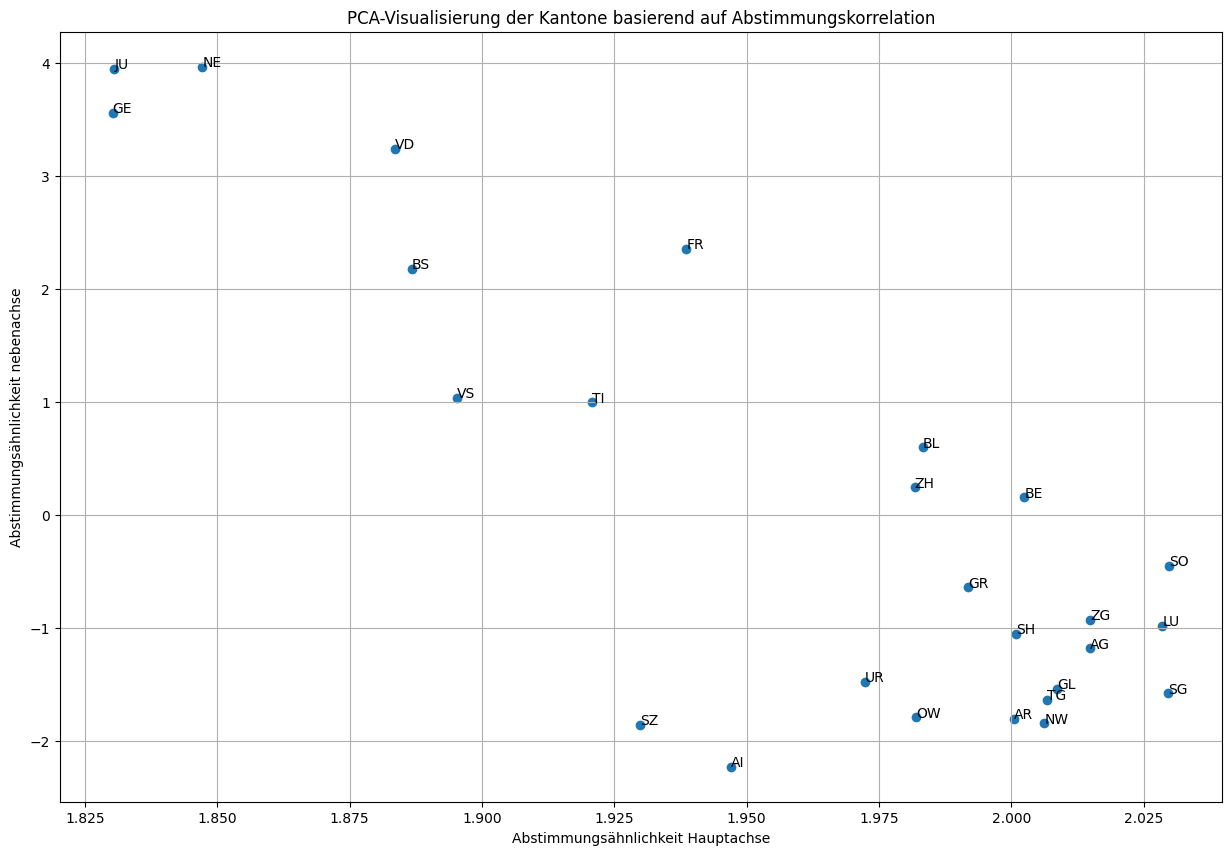

In [ ]:
corr_matrix = df_with_women.corr()

if corr_matrix.isna().sum().sum() > 0:
    print("NaN values detected in the matrix! Replacing NaNs with 0.")
    corr_matrix = corr_matrix.fillna(0)  # Replace NaNs with 0 to avoid errors


# Perform PCA using numpy (Eigen decomposition)
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix)
pca_coords = eigenvectors[:, :2] * 10

# Scatterplot of cantons based on their correlation similarity
plt.figure(figsize=(15, 10))
plt.scatter(pca_coords[:, 0], pca_coords[:, 1])

# Annotate points with canton names
for i, canton in enumerate(corr_matrix.index):
    plt.annotate(canton.upper().replace("-ANNAHME", ""), (pca_coords[i, 0], pca_coords[i, 1]), fontsize=10)

plt.title("PCA-Visualisierung der Kantone basierend auf Abstimmungskorrelation")
plt.xlabel("Abstimmungsähnlichkeit Hauptachse")
plt.ylabel("Abstimmungsähnlichkeit nebenachse")
plt.grid(True)
plt.show()

### Erkenntnisse:
Die Kantone scheinen nach der Abstimmung stärker zu korrelieren.
Ausserdem scheinen eher konservative Kantone wie Uri, Appenzell Innerrhoden und Schwyz sich angeglichen zu haben.
Zudem scheint sich Jura stark an der französischen Schweiz zu orientieren.

## 6. Erweiterte Analyse: Missing-Values-Heatmap

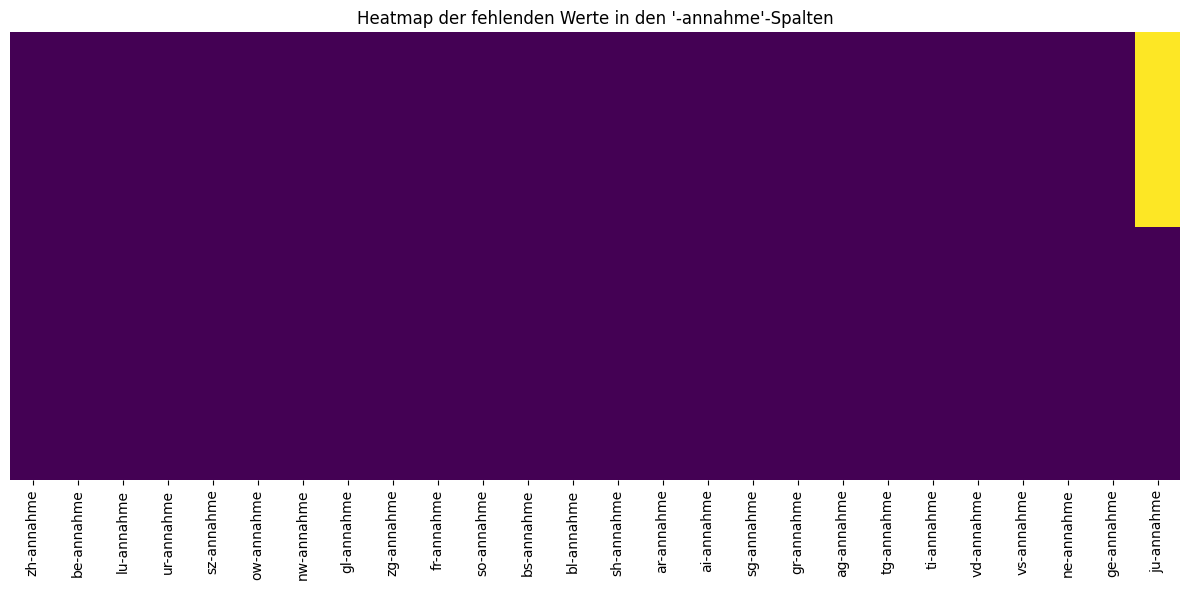

In [ ]:
# Visualisiere fehlende Werte in den Abstimmungsdaten pro Kanton
plt.figure(figsize=(12, 6))
sns.heatmap(df_filtered.isna(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Heatmap der fehlenden Werte in den '-annahme'-Spalten")
plt.tight_layout()
plt.show()

## 7. Analyse der Übereinstimmung zwischen Kantonsstimmen und den Positionen von Ständerat und Nationalrat

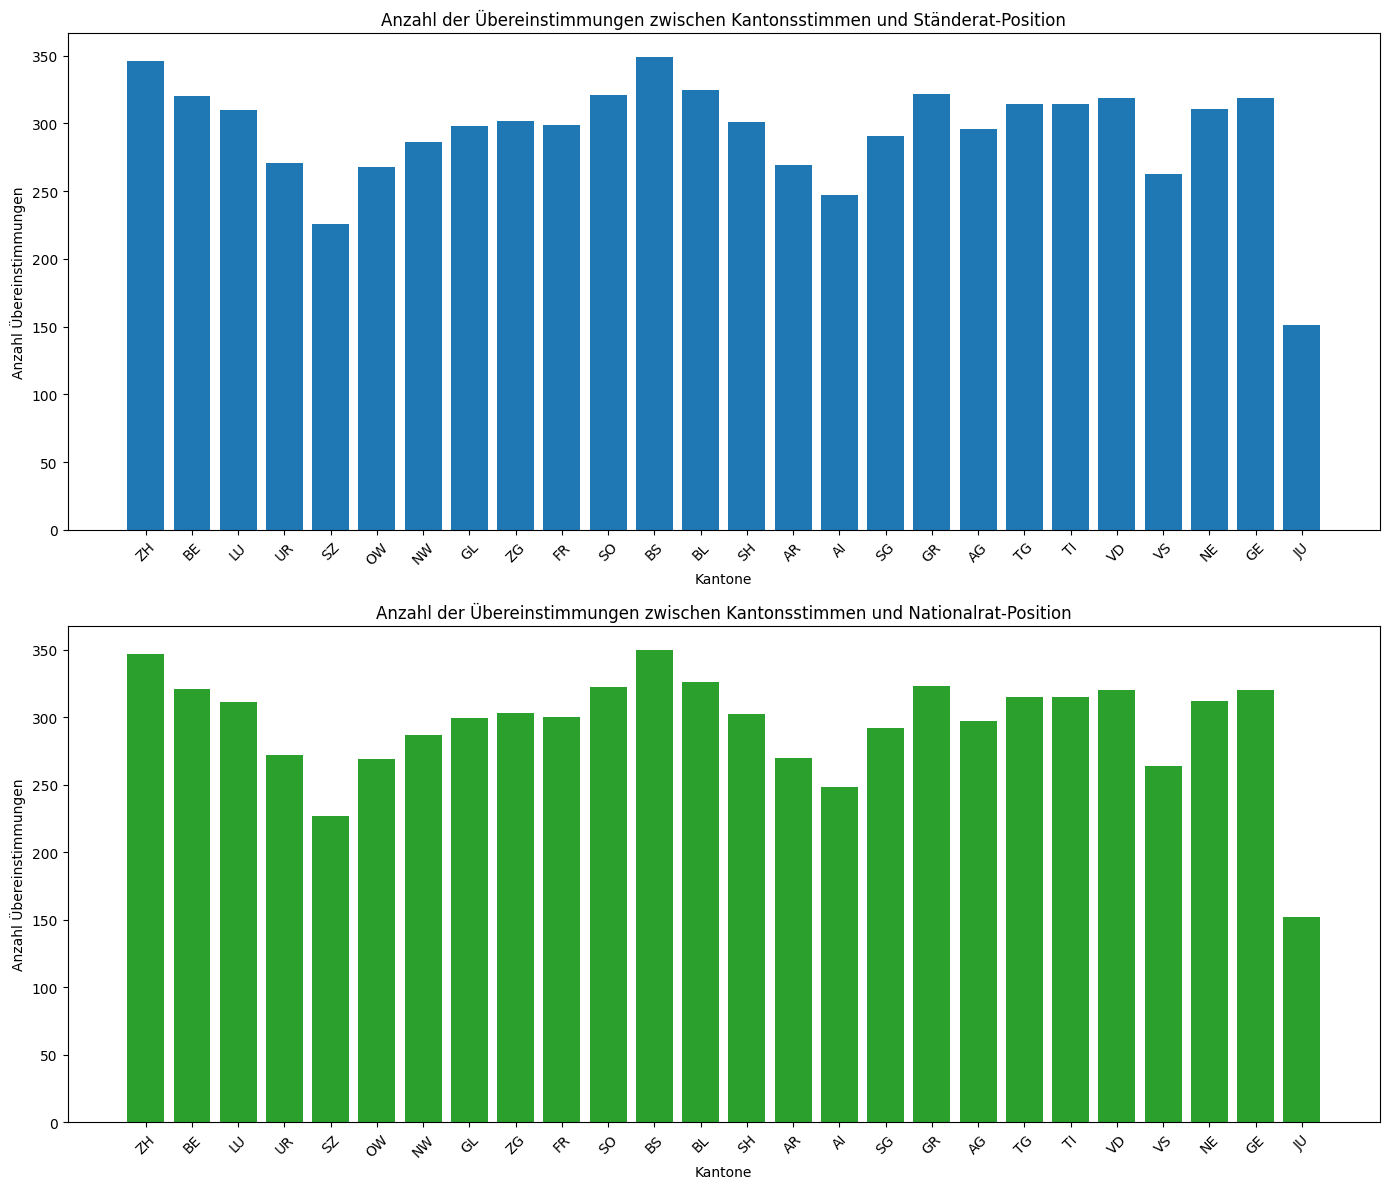

In [ ]:
# -------------------------------
# 7. Analyse der Übereinstimmung zwischen Kantonsstimmen und den Positionen von Ständerat und Nationalrat
# -------------------------------

# Bereite die Spalten 'sr-pos' (Ständerat) und 'nr-pos' (Nationalrat) auf
# Wandle problematische Werte um und konvertiere in numerisches Format
df['sr-pos'] = df['sr-pos'].replace({'.': np.nan, 'z': np.nan, '1': 1, '0': 0})
df['nr-pos'] = df['nr-pos'].replace({'.': np.nan, 'z': np.nan, '1': 1, '0': 0})
df['sr-pos'] = pd.to_numeric(df['sr-pos'], errors='coerce')
df['nr-pos'] = pd.to_numeric(df['nr-pos'], errors='coerce')

# Selektiere alle Kantonsspalten für die Analyse
canton_columns = [col for col in df.columns if '-annahme' in col]

# Erstelle leere DataFrames zur Speicherung der Übereinstimmungen
sr_matches = pd.DataFrame(index=df.index)
nr_matches = pd.DataFrame(index=df.index)

# Vergleiche für jeden Kanton, ob dessen Abstimmung mit der Position von Ständerat und Nationalrat übereinstimmt
for canton in canton_columns:
    # Konvertiere die Kantonsstimme in numerisches Format
    canton_vote = pd.to_numeric(df[canton].replace({'.': np.nan, 'z': np.nan, '1': 1, '0': 0}), errors='coerce')
    
    # Prüfe auf Übereinstimmung (True wenn die Stimme mit der Position übereinstimmt)
    sr_matches[canton] = (canton_vote == df['sr-pos'])
    nr_matches[canton] = (canton_vote == df['nr-pos'])

# Berechne die Anzahl der Übereinstimmungen pro Kanton
sr_match_counts = sr_matches.sum(axis=0)
nr_match_counts = nr_matches.sum(axis=0)

# Extrahiere die Kantonsnamen für die Darstellung
canton_names = [col.replace('-annahme', '').upper() for col in canton_columns]

# Erstelle Diagramme für die absolute Anzahl der Übereinstimmungen
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Diagramm für Übereinstimmungen mit dem Ständerat
ax1.bar(canton_names, sr_match_counts.values, color='tab:blue')
ax1.set_title('Anzahl der Übereinstimmungen zwischen Kantonsstimmen und Ständerat-Position')
ax1.set_ylabel('Anzahl Übereinstimmungen')
ax1.set_xlabel('Kantone')
ax1.tick_params(axis='x', rotation=45)

# Diagramm für Übereinstimmungen mit dem Nationalrat
ax2.bar(canton_names, nr_match_counts.values, color='tab:green')
ax2.set_title('Anzahl der Übereinstimmungen zwischen Kantonsstimmen und Nationalrat-Position')
ax2.set_ylabel('Anzahl Übereinstimmungen')
ax2.set_xlabel('Kantone')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Berechnen und Plotten der Prozentualen Angaben

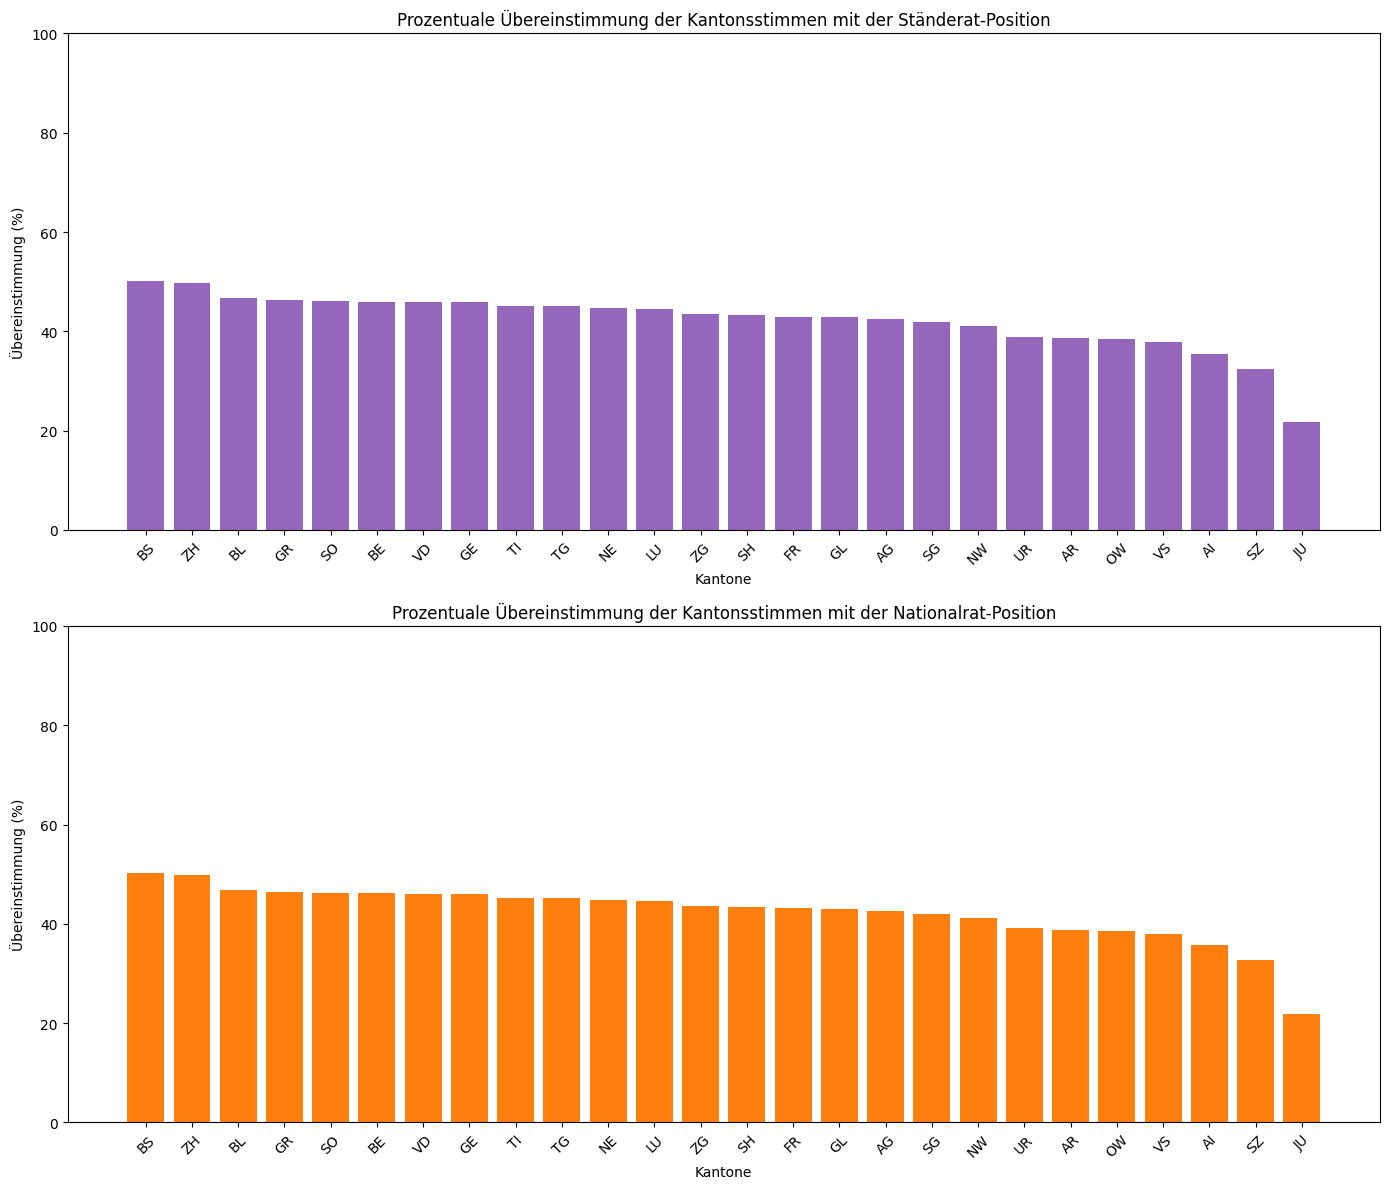

In [ ]:
# Berechne den prozentualen Anteil der Übereinstimmungen
total_valid_votes = (~df['sr-pos'].isna()).sum()  # Anzahl gültiger Abstimmungen
sr_match_percentages = (sr_match_counts / total_valid_votes * 100).sort_values(ascending=False)  # Prozentsatz und absteigende Sortierung
nr_match_percentages = (nr_match_counts / total_valid_votes * 100).sort_values(ascending=False)  # Prozentsatz und absteigende Sortierung

# Erstelle Diagramme für die prozentualen Übereinstimmungen
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Diagramm für prozentuale Übereinstimmungen mit dem Ständerat
ax1.bar(sr_match_percentages.index.str.replace('-annahme', '').str.upper(),
        sr_match_percentages.values, color='tab:purple')
ax1.set_title('Prozentuale Übereinstimmung der Kantonsstimmen mit der Ständerat-Position')
ax1.set_ylabel('Übereinstimmung (%)')
ax1.set_xlabel('Kantone')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(0, 100)  # Y-Achse von 0 bis 100%

# Diagramm für prozentuale Übereinstimmungen mit dem Nationalrat
ax2.bar(nr_match_percentages.index.str.replace('-annahme', '').str.upper(),
        nr_match_percentages.values, color='tab:orange')
ax2.set_title('Prozentuale Übereinstimmung der Kantonsstimmen mit der Nationalrat-Position')
ax2.set_ylabel('Übereinstimmung (%)')
ax2.set_xlabel('Kantone')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylim(0, 100)  # Y-Achse von 0 bis 100%

plt.tight_layout()
plt.show()